# NAMING

## FREQUENCY
- **daily** -> encounters per day
- **busy** -> encounters per hour, on most busy day
- **exp** -> experiment; actual data of the most popular hours on the busiest day

## MOBILITY
- **high** -> high mobility
- **mid** -> medium mobility
- **low** -> low/no mobility
- **all** -> all devices, regardless of mobility

## TYPE
- **ble** -> Bluetooth
- **gsm** -> GSM
- **sensor** -> Sensor Wifi
- **wifi** -> Wifi

Dataframes, Arrays, ... -> [...]\_[TYPE]\_[FREQUENCY]\_[MOBILITY]\_[...]

In [75]:
from __future__ import division
import collections
from datetime import datetime
from datetime import timedelta
from decimal import Decimal
from fastdtw import fastdtw
from dtaidistance import dtw
from dtaidistance import dtw_ndim
from dtaidistance import dtw_visualisation as dtwvis
import geopy.distance as geo
import itertools
import json
import math
from multiprocessing import Process
import numpy as np
import os
import pandas as pd
import pickle
import pydot
import pytz
import scipy.stats as stats
import scipy.spatial.distance as dist
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import statistics

%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
font = {'size' : 30}
matplotlib.rc('font', **font)
matplotlib.rcParams["pdf.fonttype"] = 42 # TrueType
matplotlib.rcParams["ps.fonttype"] = 42 # TrueType
matplotlib.rcParams["lines.linewidth"] = 3
matplotlib.rcParams["lines.markersize"] = 20
matplotlib.rcParams["figure.figsize"] = [15, 10]

pd.set_option('display.max_rows', 200)

# Seed for randomness
RSEED = 69
np.random.seed(RSEED)

#################################################################################################
#################################################################################################


# parquet files opened as byte arrays, transform to string
def b2s(df):
    out = df.copy()
    str_df = df.select_dtypes([np.object])
    str_df = str_df.stack().str.decode('utf-8').unstack()
    for col in str_df:
        out[col] = str_df[col]
    return out

#################################################################################################

# add date column to dataframes
def date_frame(df):
    out = df.copy()
    out['date'] = out['timestamp'].apply(lambda dt: pd.Timestamp(dt.date()))
    return out

#################################################################################################

# clearner plotting
# https://github.com/azaitsev/millify
def millify(n, pos=None):
    millnames = ['', 'k', 'M', 'B', 'T', 'P', 'E', 'Z', 'Y']
    n = float(n)
    millidx = max(0, min(len(millnames) - 1,
                         int(math.floor(0 if n == 0 else math.log10(abs(n)) / 3))))
    result = '{:.{precision}f}'.format(n / 10**(3 * millidx), precision=2)
    d = Decimal(result)
    result = d.quantize(Decimal(1)) if d == d.to_integral() else d.normalize()
    return '{0} {dx}'.format(result, dx=millnames[millidx])

#################################################################################################

def bytify(n):
    millnames = ['B', 'KB', 'MB', 'GB']
    n = float(n)
    millidx = max(0, min(len(millnames) - 1,
                         int(math.floor(0 if n == 0 else math.log10(abs(n)) / 3))))
    result = '{:.{precision}f}'.format(n / 10**(3 * millidx), precision=2)
    d = Decimal(result)
    result = d.quantize(Decimal(1)) if d == d.to_integral() else d.normalize()
    return '{0} {dx}'.format(result, dx=millnames[millidx])

#################################################################################################

def day_from_timestamp(x):
    return pd.datetime.strftime(x, '%Y-%m-%d')

#################################################################################################

def myround(x, prec=0, base=.05):
    return (base * (np.array(x) / base).round()).round(prec)

#################################################################################################
#################################################################################################

# compute distance per day between encountered APs
def dailydistance(dic,df,devices):
    print('initialize')
    dic = {}
    for device in devices:
        dic[device]={}
        for day in timespan:
            dic[device][day] = {
                "APs":[],
                "Distance":0
            }

    print('fill ecountered APs')
    for device in devices:
        for day in timespan:
            records = df[
                (df['device_id'] == device) & (df['date'] == day)
            ].to_records()
            for rec in records:
                # save coordinates of AP
                dic[device][day]["APs"] += [(rec[4],rec[5])]

    print('compute distance')
    for device in dic:
        for day in dic[device]:
            ap_list = dic[device][day]["APs"]
            if len(ap_list) > 0:
                prev = ap_list[0]
            for b in ap_list:
                dic[device][day]["Distance"] += geo.distance(prev,b).meters
                prev = b
                
    return dic

#################################################################################################

# compute unique APs encountered by device per day
def dailyuniqueaps(dic,df,id_field,devices):
    dic = {}
    for device in devices:
        dic[device]={}
        for day in timespan:
            dic[device][day] = {
                "min_time" : None,
                "max_time" : None,
                "APs" : None
            }
            records = df[(df['device_id'] == device) & (df['date'] == day)]
            dic[device][day]["min_time"] = records['timestamp'].min()
            dic[device][day]["max_time"] = records['timestamp'].max()
            dic[device][day]["APs"] = records[id_field].unique()
    return dic

#################################################################################################

'''
df:  pandas Dataframe [timestamp, device_id, MAC, RSSI] with all measurements per iteration
out: pandas Dataframe [timestamp, device_id, MAC, RSSI] with only the highest measurement per iteration
'''
def max_entry_per_iteration(df):
    df_numpy = df.to_numpy()
    data = [[]]
    i_interest = [0]
    for i in range(1, df_numpy.shape[0]):
        if df_numpy[i][1] == df_numpy[i-1][1]:
            if df_numpy[i][0] - df_numpy[i-1][0] > pd.Timedelta(minutes=2):
                i_interest += [i]
        else:
            i_interest += [i]
    for i in range(len(i_interest)):
        tmp_begin = i_interest[i]
        tmp_end = df_numpy.shape[0]
        if i < len(i_interest)-1:
            tmp_end = i_interest[i+1]
        tmp = df_numpy[tmp_begin:tmp_end,:]
        m = 0
        v = tmp[0][3]
        for row in range(tmp.shape[0]):
            if tmp[row][3] > v:
                v = tmp[row][3]
                m = row
        data += [tmp[m]]
    data = data[1:]
    data_np = np.array(data)
    out = pd.DataFrame({'timestamp':data_np[:,0],
                        'device_id':data_np[:,1],
                        'mac':data_np[:,2],
                        'rssi':data_np[:,3]
                       })
    return(out)

#################################################################################################
#################################################################################################

# create dictionary with unique combinations of two devices and dates
def experimentDic(dic_devices, dic_steps, dic_sensor, dic_modes, dic_features):
    dic = {}
    for device in range(len(dic_devices)-1):
        device1 = dic_devices[device]
        for d in range(len(dic_devices)-1-device):
            device2 = dic_devices[device+1+d]
            for day in dic_steps:
                for step in range(len(day) - 1):
                    key = device1 + '|' + device2 + '|' + str(day[step]) + '|' + str(day[step+1])
                    dic[key] = {
                        "key": key,
                        "device_1": device1,
                        "device_2": device2,
                        "starttime": day[step],
                        "endtime": day[step+1]
                    }
                    for mode in dic_modes:
                        if mode == 'groundtruth':
                            dic[key]['encounter_' + dic_sensor] = np.nan
                            continue
                        for f in dic_features:
                            dic[key][mode + '_' + f + '_' + dic_sensor] = np.nan
    return dic

#################################################################################################

def assess_model(accuracy_list,recall_list,precision_list,f1_list,roc_auc_list,true_all,prob_all,plot_title,plot_name):
    print('--- Statistics ---')
    print('Mean accuracy:', np.nanmean(accuracy_list))
    print('Mean recall:', np.nanmean(recall_list))
    print('Mean precision:', np.nanmean(precision_list))
    print('Mean F1:', np.nanmean(f1_list))
    print('Mean ROC-AUC:', np.nanmean(roc_auc_list))

    rf_all_fpr, rf_all_tpr, _ = roc_curve(true_all, prob_all)

    fig, ax = plt.subplots()
    ax.plot(rf_all_fpr, 
            rf_all_tpr, 
            color='darkorange',
            label='ROC curve (area = %0.2f)' % np.nanmean(roc_auc_list)
           )
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_ylim(0,1.05)
    ax.set_xlim(0,1)

    ax.set_title(plot_title)
    ax.set_xlabel('False Positive Rate.')
    ax.set_ylabel('True Positive Rate.')
    ax.legend(loc="lower right")

    fig.savefig(os.path.join(result_path,plot_name),format="pdf", bbox_inches="tight")
    plt.show()
    return (rf_all_fpr, rf_all_tpr, np.nanmean(roc_auc_list))
    
#################################################################################################
    
def opt_forest(X,y,iterations,feature_list,plot_title,plot_name,cv=10,seed=RSEED):
    train, test, train_labels, test_labels = train_test_split(X, y, test_size = 0.3, random_state = seed)

    print('\n--- Data ---')
    print('Training Features Shape:', train.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test.shape)
    print('Testing Labels Shape:', test_labels.shape)
    
    print('\n--- Fitting ---')
    param_grid = {
        'n_estimators': np.linspace(10, 200).astype(int),
        'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
        'max_features': ['log2', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
        'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
        'min_samples_split': [2, 5, 10],
        'bootstrap': [True, False]
    }

    # Estimator for use in random search
    estimator = RandomForestClassifier(random_state = RSEED)

    # Create the random search model
    rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                            scoring = 'roc_auc', cv = cv, 
                            n_iter = iterations, verbose = 1, random_state=RSEED)

    # Fit 
    rs.fit(train, train_labels)
    
    print('\n--- Best Parameters ---')
    # Print best parameters
    for p in rs.best_params_:
        print(p + ': ' + str(rs.best_params_[p]))
    #print(rs.best_params_)
    
    # Use best model
    best_model = rs.best_estimator_

    train_rf_predictions = best_model.predict(train)
    train_rf_probs = best_model.predict_proba(train)[:, 1]

    rf_predictions = best_model.predict(test)
    rf_probs = best_model.predict_proba(test)[:, 1]

    n_nodes = []
    max_depths = []

    for ind_tree in best_model.estimators_:
        n_nodes.append(ind_tree.tree_.node_count)
        max_depths.append(ind_tree.tree_.max_depth)

    print('\n--- Architecture ---')
    print(f'Average number of nodes {int(np.mean(n_nodes))}')
    print(f'Average maximum depth {int(np.mean(max_depths))}')
    
    print('\n--- Features ---')
    importances = list(best_model.feature_importances_)
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
    accuracy_list = [accuracy_score(test_labels, rf_predictions)]
    recall_list = [recall_score(test_labels, rf_predictions)]
    precision_list = [precision_score(test_labels, rf_predictions)]
    f1_list = [f1_score(test_labels, rf_predictions)]
    roc_auc_list = [roc_auc_score(test_labels, rf_predictions)]
    
    rates = assess_model(accuracy_list,recall_list,precision_list,f1_list,roc_auc_list,test_labels,rf_probs,plot_title,plot_name)
    
    return (best_model, rates, feature_importances)

#################################################################################################

def opt_boost(X,y,iterations,feature_list,plot_title,plot_name,cv=10):
    train, test, train_labels, test_labels = train_test_split(X, y, test_size = 0.3, random_state = RSEED)

    print('\n--- Data ---')
    print('Training Features Shape:', train.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test.shape)
    print('Testing Labels Shape:', test_labels.shape)
    
    print('\n--- Fitting ---')
    param_grid = {
        'n_estimators': np.linspace(10, 200).astype(int),
        'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
        'max_features': ['log2', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
        'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
        'min_samples_split': [2, 5, 10],
        "criterion": ["friedman_mse",  "mae"],
        "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
        "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2]
    }

    # Estimator for use in random search
    estimator = GradientBoostingClassifier(random_state = RSEED)

    # Create the random search model
    rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                            scoring = 'roc_auc', cv = cv, 
                            n_iter = iterations, verbose = 1, random_state=RSEED)

    # Fit 
    rs.fit(train, train_labels)
    
    print('\n--- Best Parameters ---')
    # Print best parameters
    for p in rs.best_params_:
        print(p + ': ' + str(rs.best_params_[p]))
    #print(rs.best_params_)
    
    # Use best model
    best_model = rs.best_estimator_

    train_rf_predictions = best_model.predict(train)
    train_rf_probs = best_model.predict_proba(train)[:, 1]

    rf_predictions = best_model.predict(test)
    rf_probs = best_model.predict_proba(test)[:, 1]

    n_nodes = []
    max_depths = []

#    for ind_tree in best_model.estimators_:
#        n_nodes.append(ind_tree.tree_.node_count)
#        max_depths.append(ind_tree.tree_.max_depth)

#    print('\n--- Architecture ---')
#    print(f'Average number of nodes {int(np.mean(n_nodes))}')
#    print(f'Average maximum depth {int(np.mean(max_depths))}')
    
    print('\n--- Features ---')
    importances = list(best_model.feature_importances_)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
    accuracy_list = [accuracy_score(test_labels, rf_predictions)]
    recall_list = [recall_score(test_labels, rf_predictions)]
    precision_list = [precision_score(test_labels, rf_predictions)]
    f1_list = [f1_score(test_labels, rf_predictions)]
    roc_auc_list = [roc_auc_score(test_labels, rf_predictions)]
    
    rates = assess_model(accuracy_list,recall_list,precision_list,f1_list,roc_auc_list,test_labels,rf_probs,plot_title,plot_name)
    
    return (best_model, rates)

#################################################################################################

def k_fold_forest(X,y,folds,estimators,plot_title,plot_name):
    accuracy_list = []
    recall_list = []
    precision_list = []
    f1_list = []
    roc_auc_list = []

    test_labels = []
    test_pred = []
    test_prob = []

    kf = KFold(n_splits=folds, shuffle=True, random_state=RSEED)
    for train, test in kf.split(X):
        X_train = X[train]
        y_train = y[train]

        X_test = X[test]
        y_test = y[test]

        rf = RandomForestClassifier(n_estimators = estimators, random_state = RSEED)
        rf.fit(X_train, y_train)
        predictions = rf.predict(X_test)
        probabilities = rf.predict_proba(X_test)[:, 1]

        test_labels.extend(y_test)
        test_pred.extend(predictions)
        test_prob.extend(probabilities)

        accuracy_list.append(accuracy_score(y_test,predictions))
        f1_list.append(f1_score(y_test,predictions))
        precision_list.append(precision_score(y_test,predictions))
        recall_list.append(recall_score(y_test,predictions))
        roc_auc_list.append(roc_auc_score(y_test,predictions))
    
    return assess_model(accuracy_list,recall_list,precision_list,f1_list,roc_auc_list,test_labels,test_prob,plot_title,plot_name)

#################################################################################################
    
def k_fold_boost(X,y,folds,estimators,plot_title,plot_name):
    accuracy_list = []
    recall_list = []
    precision_list = []
    f1_list = []
    roc_auc_list = []

    test_labels = []
    test_pred = []
    test_prob = []

    kf = KFold(n_splits=folds, shuffle=True)
    for train, test in kf.split(X):
        X_train = X[train]
        y_train = y[train]

        X_test = X[test]
        y_test = y[test]

        rf = GradientBoostingClassifier(n_estimators = estimators, random_state = RSEED)
        rf.fit(X_train, y_train)
        predictions = rf.predict(X_test)
        probabilities = rf.predict_proba(X_test)[:, 1]

        test_labels.extend(y_test)
        test_pred.extend(predictions)
        test_prob.extend(probabilities)

        accuracy_list.append(accuracy_score(y_test,predictions))
        f1_list.append(f1_score(y_test,predictions))
        precision_list.append(precision_score(y_test,predictions))
        recall_list.append(recall_score(y_test,predictions))
        roc_auc_list.append(roc_auc_score(y_test,predictions))
    
    return assess_model(accuracy_list,recall_list,precision_list,f1_list,roc_auc_list,test_labels,test_prob,plot_title,plot_name)
    
    
#################################################################################################
#################################################################################################

log_path = os.path.join(os.getcwd(), "guided-research-results/offscreen.log")
def log(message, file=log_path):
    with open(file, 'a') as f:
        f.write(datetime.now(tz=pytz.timezone('Europe/Berlin')).isoformat() + '\t' + message + '\n')
    
# set options and variables
pd.set_option('display.float_format', lambda x: '%.3f' % x)

result_path = os.path.join(os.getcwd(), "guided-research-results")
experiment_path = os.path.join(result_path, 'experiment_data')
path_data_collection = os.path.join(os.getcwd(), "data-collection")

month_ticks = [0,30,61,91,122,153]
month_labels = ['2018-03','2018-04','2018-05','2018-06','2018-07','2018-08']

timespan = pd.date_range(start=pd.to_datetime('2018-03-01'), end=pd.to_datetime('2018-08-31'))

# Timespan for encounter in drilldown
delta_hourly = pd.Timedelta('00:05:00')
delta_string = '5min'

# encounter = same beacon registered in t-dt/2,t+dt/2 interval
timespans = [5,10,30,45,90,180,360]

# ground truth data: sensor short names
groundtruth = ['BLE','GSM','SENSOR','WIFI']
# sensor types for original features
features = ['BLE','GSM','SENSOR','WIFI']

# Devices with significant records
# Computed from mobility
devices_all_usage = [
    '7a52f62b-b528-40b3-864b-1ae7eed1e189','424bf6cf-a071-4f55-b2a6-2f4e24b46b91','3775c074-44d7-4349-9273-3cd8a959369d',
    'e003fc12-ace7-41ee-b7f6-9dc1b5c5adfd','68ea945e-33eb-44ea-82f9-7ace16ac0d77','b7a60829-bbbe-48d5-9b6b-fc2f2de0a70c',
    '92369119-68fe-436d-8ca8-e7d03d903661','2a3062a6-0eeb-4a8d-9623-adb8d5ca0eda','b3fa9c28-64d5-487b-9775-61ca9d9b3f3b',
    '3f4abf62-e6ad-400c-a2fd-565aecd0f24c','ede758db-b887-4b64-b34c-665130909c6d','5d5561d6-3895-4333-b279-8f32a6676946',
    '0d570dc2-b6fd-4b58-a821-04ca19a63d39','a9391bee-d52e-4477-bb13-f364e532c241','f21c5f10-55ff-46e0-81ec-5d55bda030bc',
    '08ddf60e-af58-46a5-a040-deba1cf9cd5a','62730195-6df3-4cfa-b5fc-b392c3a8fea7','9c57288f-c781-4b6c-b872-220aee5a5619',
    'becac23f-7256-4bc0-a435-08d9eda001ba','4722aba9-f779-4f98-8587-f6200f877428','9e9300f2-4349-4cc0-b358-65b46cb509ae',
    '497e9c46-de36-4867-9bf7-404ab9a6adcd','72c1cc9e-ac9e-4409-aa6e-4e800cef7305','ad4ccb10-837f-42d3-a17e-5498cbbbecb7',
    '49cdb769-2ef6-4111-a405-85d7c1f6a585','39c589bc-201f-449f-b841-7c9c2b99aa76','baf43633-b62d-44c6-8e66-030e72b1235c',
    '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1','3bbcc834-7c27-46b4-aa56-51267ab6e283','b212c0fd-6209-43e8-a2da-d98f31b807dd',
    '275e24d8-634b-4b3c-806d-f5c39feb697e','b60d7582-5851-4927-a8aa-7cdff291cdc7','4e7801df-ed93-43fa-9246-7172d0183f23',
    'aaf1ecc4-fba4-42ac-80b6-0c7b2c8a7735','8ba39613-aeef-4715-8be6-56bad1d20137','19d0f512-cfe8-4758-9b8b-3b9c870a0907',
    '24b4fbdb-9742-4737-87c6-054bb9fbd114','6b856387-0749-47cc-a24a-b9703f281b4f','8b21299a-f3bb-43b3-8e1b-5b9f93696b24',
    '95e1d293-9548-473f-b516-db5580583d34'
]
#debugging
#%pdb

# 1. Raw Data Analysis

## 1.1 Read and clean data

Sensor readings.

In [11]:
#data_accelerometer = b2s(pd.read_parquet(os.path.join(path_data_collection, "accelerometer_5.parquet.snappy")))
data_accelerometer = pd.read_parquet(os.path.join(path_data_collection, "accelerometer.parquet.snappy"))
data_accelerometer = data_accelerometer[pd.notnull(data_accelerometer.device_id)]

In [12]:
data_barometer = b2s(pd.read_parquet(os.path.join(path_data_collection, "barometer.parquet.snappy")))
data_barometer = data_barometer[pd.notnull(data_barometer.device_id)]

In [306]:
data_bluetooth = b2s(pd.read_parquet(os.path.join(path_data_collection, "bluetooth.parquet.snappy")))
data_bluetooth = data_bluetooth[data_bluetooth.bt_address != "disabled"]
data_bluetooth = data_bluetooth[pd.notnull(data_bluetooth.device_id)]

In [308]:
#data_cdma = b2s(pd.read_parquet(os.path.join(path_data_collection, "cdma.parquet.snappy")))
#data_cdma = data_cdma[pd.notnull(data_cdma.device_id)]

In [6]:
data_gravity = b2s(pd.read_parquet(os.path.join(path_data_collection, "gravity.parquet.snappy")))
data_gravity = data_gravity[pd.notnull(data_gravity.device_id)]

In [5]:
data_gsm = b2s(pd.read_parquet(os.path.join(path_data_collection, "gsm.parquet.snappy")))
data_gsm = data_gsm[pd.notnull(data_gsm.device_id)]
# transform signal_strength field to dB
data_gsm['rssi'] = -113 + 2*data_gsm['signal_strength']

In [311]:
data_gsm_neighbor = b2s(pd.read_parquet(os.path.join(path_data_collection, "gsm_neighbor.parquet.snappy")))
data_gsm_neighbor = data_gsm_neighbor[pd.notnull(data_gsm_neighbor.device_id)]

In [312]:
#data_gyroscope = b2s(pd.read_parquet(os.path.join(path_data_collection, "gyroscope.parquet.snappy")))
#data_gyroscope = data_gyroscope[pd.notnull(data_gyroscope.device_id)]

In [313]:
#data_light = b2s(pd.read_parquet(os.path.join(path_data_collection, "light.parquet.snappy")))
#data_light = data_light[pd.notnull(data_light.device_id)]

In [314]:
#data_linear_accelerometer = b2s(pd.read_parquet(os.path.join(path_data_collection, "linear_accelerometer.parquet.snappy")))
#data_linear_accelerometer = data_linear_accelerometer[pd.notnull(data_linear_accelerometer.device_id)]

In [315]:
data_locations = b2s(pd.read_parquet(os.path.join(path_data_collection, "locations.parquet.snappy")))
data_locations = data_locations[pd.notnull(data_locations.device_id)]

In [13]:
data_magnetometer = b2s(pd.read_parquet(os.path.join(path_data_collection, "magnetometer.parquet.snappy")))
data_magnetometer = data_magnetometer[pd.notnull(data_magnetometer.device_id)]

In [317]:
data_network = b2s(pd.read_parquet(os.path.join(path_data_collection, "network.parquet.snappy")))
data_network = data_network[pd.notnull(data_network.device_id)]

In [318]:
data_network_traffic = b2s(pd.read_parquet(os.path.join(path_data_collection, "network_traffic.parquet.snappy")))
data_network_traffic = data_network_traffic[pd.notnull(data_network_traffic.device_id)]

In [319]:
#data_proximity = b2s(pd.read_parquet(os.path.join(path_data_collection, "proximity.parquet.snappy")))
#data_proximity = data_proximity[pd.notnull(data_proximity.device_id)]

In [320]:
#data_rotation = b2s(pd.read_parquet(os.path.join(path_data_collection, "rotation.parquet.snappy")))
#data_rotation = data_rotation[pd.notnull(data_rotation.device_id)]

In [7]:
# connected WiFi
data_sensor = b2s(pd.read_parquet(os.path.join(path_data_collection, "sensor_wifi.parquet.snappy")))
data_sensor = data_sensor[pd.notnull(data_sensor.bssid)]
data_sensor = data_sensor[pd.notnull(data_sensor.device_id)]
data_sensor = data_sensor[data_sensor.bssid != "00:00:00:00:00:00"]
data_sensor = data_sensor[data_sensor.ssid != "<unknown ssid>"]
# remove last digit from bssid if eduroam router, as broadcast mac is not the same as connected mac
data_sensor.loc[data_sensor.ssid == '\\\"eduroam\\\"', 'bssid'] = data_sensor.where(data_sensor.ssid == '\\\"eduroam\\\"').bssid.str[:-1]

In [322]:
#data_telephony = b2s(pd.read_parquet(os.path.join(path_data_collection, "telephony.parquet.snappy")))
#data_telephony = data_telephony[pd.notnull(data_telephony.device_id)]

In [307]:
# available WiFi connections not connected to
data_wifi = b2s(pd.read_parquet(os.path.join(path_data_collection, "wifi.parquet.snappy")))
data_wifi = data_wifi[pd.notnull(data_wifi.bssid)]
data_wifi = data_wifi[pd.notnull(data_wifi.device_id)]

Data about devices and known WiFi/Bluetooth locations.

In [9]:
devices = b2s(pd.read_parquet(os.path.join(path_data_collection, "aware_device.parquet.snappy")))

In [10]:
data_beacons = pd.read_csv(os.path.join(path_data_collection, "ble-beacons-location.csv"),sep=";")
data_beacons = data_beacons[pd.notnull(data_beacons.mac)]

In [11]:
data_eduroam = pd.read_csv(os.path.join(path_data_collection, "eduroam.csv"),sep=";")
data_eduroam = data_eduroam[pd.notnull(data_eduroam['mac'])]
data_eduroam = data_eduroam[pd.notnull(data_eduroam['lat'])]
data_eduroam['mac_short'] = data_eduroam.mac.str[:-1]

### 1.1.1 Remove Sensor Readings from Unknown Devices

In [ ]:
unique = {}
unique['devices'] = devices['device_id'].unique()
unique['data_accelerometer'] = data_accelerometer['device_id'].unique()
unique['data_barometer'] = data_barometer['device_id'].unique()
unique['data_bluetooth'] = data_bluetooth['device_id'].unique()
#unique['data_cdma'] = data_cdma['device_id'].unique()
unique['data_gravity'] = data_gravity['device_id'].unique()
unique['data_gsm'] = data_gsm['device_id'].unique()
unique['data_gsm_neighbor'] = data_gsm_neighbor['device_id'].unique()
#unique['data_gyroscope'] = data_gyroscope['device_id'].unique()
#unique['data_light'] = data_light['device_id'].unique()
#unique['data_linear_accelerometer'] = data_linear_accelerometer['device_id'].unique()
unique['data_locations'] = data_locations['device_id'].unique()
unique['data_magnetometer'] = data_magnetometer['device_id'].unique()
unique['data_network'] = data_network['device_id'].unique()
unique['data_network_traffic'] = data_network_traffic['device_id'].unique()
#unique['data_proximity'] = data_proximity['device_id'].unique()
#unique['data_rotation'] = data_rotation['device_id'].unique()
unique['data_sensor'] = data_sensor['device_id'].unique()
#unique['data_telephony'] = data_telephony['device_id'].unique()
unique['data_wifi'] = data_wifi['device_id'].unique()

In [ ]:
#for u in unique:
#    for d in unique[u]:
#        if d not in unique['devices']:
#            print(u, ': ', d)
#            
#data_telephony[data_telephony['device_id'] == 'cb3413fa-6444-4f8d-af07-22be1233d3c5'].shape[0]

In [ ]:
#data_telephony = data_telephony[data_telephony['device_id'] != 'cb3413fa-6444-4f8d-af07-22be1233d3c5']

### 1.1.2 Create table where timestamp of sensor reading is rounded to day, as to be able to cluster per day and not distinct timestamps.

In [333]:
day_accelerometer = date_frame(data_accelerometer[['device_id','timestamp']])

In [334]:
day_barometer = date_frame(data_barometer[['device_id','timestamp']])

In [335]:
day_bluetooth = date_frame(data_bluetooth[['device_id','timestamp']])

In [ ]:
#day_cdma = date_frame(data_cdma[['device_id','timestamp']])

In [336]:
day_gravity = date_frame(data_gravity[['device_id','timestamp']])

In [337]:
day_gsm = date_frame(data_gsm[['device_id','timestamp']])

In [338]:
day_gsm_neighbor = date_frame(data_gsm_neighbor[['device_id','timestamp']])

In [ ]:
#day_gyroscope = date_frame(data_gyroscope[['device_id','timestamp']])

In [ ]:
#day_light = date_frame(data_light[['device_id','timestamp']])

In [ ]:
#day_linear_accelerometer = date_frame(data_linear_accelerometer[['device_id','timestamp']])

In [339]:
day_locations = date_frame(data_locations[['device_id','timestamp']])

In [340]:
day_magnetometer = date_frame(data_magnetometer[['device_id','timestamp']])

In [341]:
day_network = date_frame(data_network[['device_id','timestamp']])

In [342]:
day_network_traffic = date_frame(data_network_traffic[['device_id','timestamp']])

In [ ]:
#day_proximity = date_frame(data_proximity[['device_id','timestamp']])

In [ ]:
#day_rotation = date_frame(data_rotation[['device_id','timestamp']])

In [343]:
day_sensor = date_frame(data_sensor[['device_id','timestamp']])

In [ ]:
#day_telephony = date_frame(data_telephony[['device_id','timestamp']])

In [132]:
day_wifi = date_frame(data_wifi[['device_id','timestamp']])

NameError: name 'data_wifi' is not defined

## 1.2 Overview Recorded Data

The following data seems to be useless and will not be used for the proximity analysis:
- CDMA
- Gyroscope
- Light
- Linear Accelerometer
- Proximity
- Rotation
- Telephony

### 1.2.1 Records/minute by sensor type

While the frequency of sensor readings is the same for all the sensors but the accelerometer, the number of data points collected per reading differs widely.

In [52]:
records = {}
records['Accelerometer'] = {'min': data_accelerometer.timestamp.min(),
                            'max': data_accelerometer.timestamp.max(),
                            'count': data_accelerometer.shape[0]
                           }
records['Barometer'] = {'min': data_barometer.timestamp.min(),
                        'max': data_barometer.timestamp.max(),
                        'count': data_barometer.shape[0]
                       }
records['Bluetooth'] = {'min': data_bluetooth.timestamp.min(),
                        'max': data_bluetooth.timestamp.max(),
                        'count': data_bluetooth.shape[0]
                       }
#records['CDMA'] = {'min': data_cdma.timestamp.min(),
#                        'max': data_cdma.timestamp.max(),
#                        'count': data_cdma.shape[0]
#                       }
records['Gravity'] = {'min': data_gravity.timestamp.min(),
                      'max': data_gravity.timestamp.max(),
                      'count': data_gravity.shape[0]
                     }
records['GSM'] = {'min': data_gsm.timestamp.min(),
                  'max': data_gsm.timestamp.max(),
                  'count': data_gsm.shape[0]
                 }
records['GSM Neighbor'] = {'min': data_gsm_neighbor.timestamp.min(),
                           'max': data_gsm_neighbor.timestamp.max(),
                           'count': data_gsm_neighbor.shape[0]
                          }
#records['Gyroscope'] = {'min': data_gyroscope.timestamp.min(),
#                             'max': data_gyroscope.timestamp.max(),
#                             'count': data_gyroscope.shape[0]
#                            }
#records['Light'] = {'min': data_light.timestamp.min(),
#                         'max': data_light.timestamp.max(),
#                         'count': data_light.shape[0]
#                        }
#records['Linear Accelerometer'] = {'min': data_linear_accelerometer.timestamp.min(),
#                                        'max': data_linear_accelerometer.timestamp.max(),
#                                        'count': data_linear_accelerometer.shape[0]
#                                       }
records['Locations'] = {'min': data_locations.timestamp.min(),
                        'max': data_locations.timestamp.max(),
                        'count': data_locations.shape[0]
                       }
records['Magnetometer'] = {'min': data_magnetometer.timestamp.min(),
                           'max': data_magnetometer.timestamp.max(),
                           'count': data_magnetometer.shape[0]
                          }
records['Network'] = {'min': data_network.timestamp.min(),
                      'max': data_network.timestamp.max(),
                      'count': data_network.shape[0]
                     }
records['Network Traffic'] = {'min': data_network_traffic.timestamp.min(),
                              'max': data_network_traffic.timestamp.max(),
                              'count': data_network_traffic.shape[0]
                             }
#records['Proximity'] = {'min': data_proximity.timestamp.min(),
#                             'max': data_proximity.timestamp.max(),
#                             'count': data_proximity.shape[0]
#                            }
#records['Rotation'] = {'min': data_rotation.timestamp.min(),
#                            'max': data_rotation.timestamp.max(),
#                            'count': data_rotation.shape[0]
#                           }
records['Sensor Wifi'] = {'min': data_sensor.timestamp.min(),
                          'max': data_sensor.timestamp.max(),
                          'count': data_sensor.shape[0]
                         }
#records['Telephony'] = {'min': data_telephony.timestamp.min(),
#                             'max': data_telephony.timestamp.max(),
#                             'count': data_telephony.shape[0]
#                            }
records['Wifi'] = {'min': data_wifi.timestamp.min(),
                   'max': data_wifi.timestamp.max(),
                   'count': data_wifi.shape[0]
                  }

In [53]:
rate = {}
for r in records:
    dt = (records[r]['max']-records[r]['min']).round('12h')
    dt_rounded = dt.days + dt.seconds/(24*3600)
    rate[r] = records[r]['count']//dt_rounded

In [ ]:
#rate = {sensor: entries for sensor, entries in rate.items() if entries > np.median(list(rate.values()))}
#rate = collections.OrderedDict(sorted(rate.items(), key=lambda kv: kv[1]))

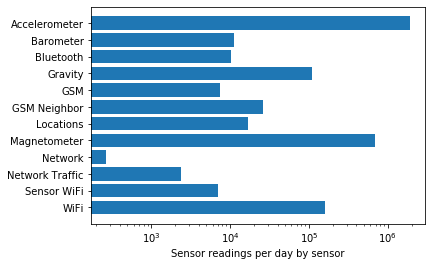

In [54]:
fig, ax = plt.subplots()
ax.barh(range(len(rate)), rate.values(), align='center')
ax.set_yticks(range(len(rate)))
ax.set_yticklabels(rate.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millify))
ax.set_xscale("log", nonposx='clip')
ax.set_xlabel('Sensor readings per day by sensor')


fig.savefig("guided-research-results/sensor-readings_perday_barplot.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [55]:
sensors = {}
for k in records.keys():
    sensors[k] = {}
        
for day in timespan:
    sensors['Accelerometer'][day] = day_accelerometer[day_accelerometer['date'] == day].shape[0]
    sensors['Barometer'][day] = day_barometer[day_barometer['date'] == day].shape[0]
    sensors['Bluetooth'][day] = day_bluetooth[day_bluetooth['date'] == day].shape[0]
#    sensors['CDMA'][day] = day_cdma[day_cdma['date'] == day].shape[0]
    sensors['Gravity'][day] = day_gravity[day_gravity['date'] == day].shape[0]
    sensors['GSM'][day] = day_gsm[day_gsm['date'] == day].shape[0]
    sensors['GSM Neighbor'][day] = day_gsm_neighbor[day_gsm_neighbor['date'] == day].shape[0]
#    sensors['Gyroscope'][day] = day_gyroscope[day_gyroscope['date'] == day].shape[0]
#    sensors['Light'][day] = day_light[day_light['date'] == day].shape[0]
#    sensors['Linear Accelerometer'][day] = day_linear_accelerometer[day_linear_accelerometer['date'] == day].shape[0]
    sensors['Locations'][day] = day_locations[day_locations['date'] == day].shape[0]
    sensors['Magnetometer'][day] = day_magnetometer[day_magnetometer['date'] == day].shape[0]
    sensors['Network'][day] = day_network[day_network['date'] == day].shape[0]
    sensors['Network Traffic'][day] = day_network_traffic[day_network_traffic['date'] == day].shape[0]
#    sensors['Proximity'][day] = day_proximity[day_proximity['date'] == day].shape[0]
#    sensors['Rotation'][day] = day_rotation[day_rotation['date'] == day].shape[0]
    sensors['Sensor Wifi'][day] = day_sensor[day_sensor['date'] == day].shape[0]
#    sensors['Telephony'][day] = day_telephony[day_telephony['date'] == day].shape[0]
    sensors['Wifi'][day] = day_wifi[day_wifi['date'] == day].shape[0]

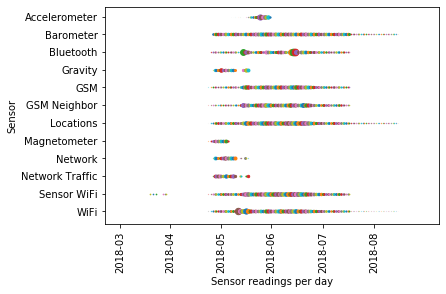

In [56]:
fig, ax = plt.subplots()

d = -1
for sensor in sensors:
    d += 1
    i = 0
    for day in timespan:
        normalized = 5*sensors[sensor][day]/(rate[sensor]+1)
        ax.scatter(i, d, normalized)
        i += 1    
    
ax.set_yticks(range(len(sensors.keys())))
ax.set_yticklabels(sensors.keys())
ax.set_ylabel('Sensor')
ax.invert_yaxis()
    
ax.set_xticks(month_ticks)
ax.set_xticklabels(month_labels,rotation='vertical')
ax.set_xlabel('Sensor readings per day')
    
fig.savefig("guided-research-results/sensor_readings_perday_bubbleplot.pdf", format="pdf", bbox_inches="tight")
plt.show()

### 1.2.2 Data Size

In [57]:
columns = ['Sensor','Readings','Size in Memory']
content = [
    ('Accelerometer',data_accelerometer.size,bytify(data_accelerometer.memory_usage(deep=True).sum())),
    ('Barometer',data_barometer.size,bytify(data_barometer.memory_usage(deep=True).sum())),
    ('Bluetooth',data_bluetooth.size,bytify(data_bluetooth.memory_usage(deep=True).sum())),
#    ('CDMA',data_cdma.size,bytify(data_cdma.memory_usage(deep=True).sum())),
    ('Gravity',data_gravity.size,bytify(data_gravity.memory_usage(deep=True).sum())),
    ('GSM',data_gsm.size,bytify(data_gsm.memory_usage(deep=True).sum())),
    ('GSM Neighbor',data_gsm_neighbor.size,bytify(data_gsm_neighbor.memory_usage(deep=True).sum())),
#    ('Gyroscope',data_gyroscope.size,bytify(data_gyroscope.memory_usage(deep=True).sum())),
#    ('Light',data_light.size,bytify(data_light.memory_usage(deep=True).sum())),
#    ('Linear Accelerometer',data_linear_accelerometer.size,bytify(data_linear_accelerometer.memory_usage(deep=True).sum())),
    ('Locations',data_locations.size,bytify(data_locations.memory_usage(deep=True).sum())),
    ('Magnetometer',data_magnetometer.size,bytify(data_magnetometer.memory_usage(deep=True).sum())),
    ('Network',data_network.size,bytify(data_network.memory_usage(deep=True).sum())),
    ('Network Traffic',data_network_traffic.size,bytify(data_network_traffic.memory_usage(deep=True).sum())),
#    ('Proximity',data_proximity.size,bytify(data_proximity.memory_usage(deep=True).sum())),
#    ('Rotation',data_rotation.size,bytify(data_rotation.memory_usage(deep=True).sum())),
    ('Sensor Wifi',data_sensor.size,bytify(data_sensor.memory_usage(deep=True).sum())),
#    ('Telephony',data_telephony.size,bytify(data_telephony.memory_usage(deep=True).sum())),
    ('Wifi',data_wifi.size,bytify(data_wifi.memory_usage(deep=True).sum()))
]

data_info = pd.DataFrame(content,columns=columns)
data_info

Sensor   Readings Size in Memory
0     Accelerometer  346071360        6.79 GB
1         Barometer    7481898      175.82 MB
2         Bluetooth    6058479      268.36 MB
3           Gravity   17862544      350.55 MB
4               GSM    5091784       99.93 MB
5      GSM Neighbor   15567125      331.36 MB
6         Locations   20848443      492.76 MB
7      Magnetometer   63231448        1.24 GB
8           Network      32070        1.05 MB
9   Network Traffic     407344        7.99 MB
10      Sensor WiFi    5045136      283.74 MB
11             WiFi  162968094           7 GB

### 1.2.3 App Usage

Usage of the app on a daily basis, where a "usage day" is a day with at least one measurement.

In [345]:
usage = {}
for t in timespan:
    usage[t] = []

For every day in the recorded months, create one (unique) list of devices per sensor.
Concatenating these lists leads to double entries, which has to be taken care of in the visualization process.

In [346]:
for date in usage:
    usage[date] += day_accelerometer[day_accelerometer['date'] == date]['device_id'].unique().tolist()

In [347]:
for date in usage:
    usage[date] += day_barometer[day_barometer['date'] == date]['device_id'].unique().tolist()

In [348]:
for date in usage:
    usage[date] += day_bluetooth[day_bluetooth['date'] == date]['device_id'].unique().tolist()

In [ ]:
#for date in usage:
#    usage[date] += day_cdma[day_cdma['date'] == date]['device_id'].unique().tolist()

In [349]:
for date in usage:
    usage[date] += day_gravity[day_gravity['date'] == date]['device_id'].unique().tolist()

In [350]:
for date in usage:
    usage[date] += day_gsm[day_gsm['date'] == date]['device_id'].unique().tolist()

In [351]:
for date in usage:
    usage[date] += day_gsm_neighbor[day_gsm_neighbor['date'] == date]['device_id'].unique().tolist()

In [ ]:
#for date in usage:
#    usage[date] += day_gyroscope[day_gyroscope['date'] == date]['device_id'].unique().tolist()

In [ ]:
#for date in usage:
#    usage[date] += day_light[day_light['date'] == date]['device_id'].unique().tolist()

In [ ]:
#for date in usage:
#    usage[date] += day_linear_accelerometer[day_linear_accelerometer['date'] == date]['device_id'].unique().tolist()

In [352]:
for date in usage:
    usage[date] += day_locations[day_locations['date'] == date]['device_id'].unique().tolist()

In [353]:
for date in usage:
    usage[date] += day_magnetometer[day_magnetometer['date'] == date]['device_id'].unique().tolist()

In [354]:
for date in usage:
    usage[date] += day_network[day_network['date'] == date]['device_id'].unique().tolist()

In [355]:
for date in usage:
    usage[date] += day_network_traffic[day_network_traffic['date'] == date]['device_id'].unique().tolist()

In [ ]:
#for date in usage:
#    usage[date] += day_proximity[day_proximity['date'] == date]['device_id'].unique().tolist()

In [ ]:
#for date in usage:
#    usage[date] += day_rotation[day_rotation['date'] == date]['device_id'].unique().tolist()

In [ ]:
#for date in usage:
#    usage[date] += day_telephony[day_telephony['date'] == date]['device_id'].unique().tolist()

In [356]:
for date in usage:
    usage[date] += day_wifi[day_wifi['date'] == date]['device_id'].unique().tolist()

#### 1.2.3.1 Number of distinct device IDs with sensor recording by day.

In [357]:
user_count = {}
for t in usage:
    user_count[t] = len(list(set(usage[t])))

FileNotFoundError: [Errno 2] No such file or directory: 'figures/active_devices_perday_barplot.pdf'

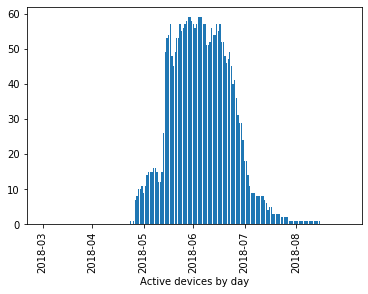

In [358]:
fig, ax = plt.subplots()
ax.bar(range(len(user_count)), user_count.values(), align='center')
ax.set_xticks(month_ticks)
ax.set_xticklabels(month_labels,rotation='vertical')
ax.set_xlabel('Active devices by day')

fig.savefig("guided-research-results/active_devices_perday_barplot.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### 1.2.3.2 Total Days of Usage by Device

In [ ]:
device_usage = {}
for device in devices['device_id'].unique():
    device_usage[device]={}
    for day in timespan:
        device_usage[device][day] = 0
    
for day in usage:
    for device in usage[day]:
        device_usage[device][day] = 1
        
for device in device_usage:
    for day in device_usage[device]:
        if device_usage[device][day] > 1:
            device_usage[device][day] = 1

In [ ]:
usage_days = {}
for device in device_usage:
    usage_days[device] = sum(device_usage[device].values())

Cluster by number of days with usage using x-means.

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# turn usage dictionary into list
usage_day_values = [[v] for v in list(usage_days.values())]

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(usage_day_values, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(usage_day_values, initial_centers, 20)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters_usage = xmeans_instance.get_clusters()
centers_usage = xmeans_instance.get_centers()

In [ ]:
fig, ax = plt.subplots()
ax.hist(list(usage_days.values()))
ax.set_xlabel('Number of days devices were active')
ax.set_ylabel('Number of devices')

# add centers from x-means for cluster indication
for center in centers_usage:
    ax.axvline(center[0], color='r', linestyle='--')

fig.savefig("guided-research-results/activity_days_histogram10.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.hist(list(usage_days.values()), bins=60)
ax.set_xlabel('Number of days devices were active')
ax.set_ylabel('Number of devices')

# add centers from x-means for cluster indication
for center in centers_usage:
    ax.axvline(center[0], color='r', linestyle='--')

fig.savefig("guided-research-results/activity_days_histogram60.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### 1.2.3.3 Usage patterns by device

Users might stop the app from running in the background, or uninstall it. Of course, they might also restart it. Here we show days when sensor readings whe

In [ ]:
bars = {}
colours = {}

for device in devices['device_id'].unique():
    bars[device] = [0]
    colours[device] = ['w']
    current_state = 0
    b = 0
    c = 0
    for day in device_usage[device]:
        # same state as day before => still same bar colour needed
        if device_usage[device][day] == current_state:
            bars[device][b] += 1
        # state changed => next bar to be stacked in different colour
        else:
            b += 1
            c += 1
            bars[device].append(1)
            current_state = device_usage[device][day]
            if c%2 == 0:
                colours[device].append('w')
            else:
                colours[device].append('#1f77b4')

In [ ]:
fig, ax = plt.subplots()

ax.set_xticks(range(1,len(bars),10))
#ax.set_xticklabels(, rotation='vertical') # really crowded label place
ax.set_xticklabels(range(1,len(bars),10))
ax.set_yticks(month_ticks)
ax.set_yticklabels(month_labels)
ax.set_xlabel('Activity pattern by device')

d = 0
for device in bars:
    height = 0
    for b in range(len(bars[device])):
        ax.bar(d, bars[device][b], bottom=height, color=colours[device][b], align='center')
        height += bars[device][b]
    d += 1

fig.savefig("guided-research-results/activity_patterns_barplot.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### 1.2.3.4 User clustering

In [ ]:
X = [[] for device in device_usage]

d = 0
for device in device_usage:
    for day in device_usage[device]:
        X[d] += [device_usage[device][day]]
    d += 1

Grouping the devices/users into 3 clusters offers the best silhouette score, while still having a well interpretable number of groups. 3 clusters also reflect well the impression obtained from the total usage days histogram (see 1.2.3.2). X-Means proposes 4 different clusters, however, the first two groups are very close to each other and can be treated as the same in our use case.

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6]
labels = [[] for device in range_n_clusters]
r = 0

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 7)

    # Silhouette plot
    # The silhouette coefficient can range from -1, 1 
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    labels[r] = cluster_labels
    r += 1

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    fig.savefig("guided-research-results/activity_patterns_silhouette_plot_" + str(i+1) + ".pdf", format="pdf", bbox_inches="tight")


In [ ]:
devices_labeled = {}

n = -1
for n_clusters in range_n_clusters:
    n += 1
    i = -1
    devices_labeled[n_clusters] = {}
    for device in device_usage:
        i += 1
        devices_labeled[n_clusters][device] = labels[n][i]

### 1.2.4 User Mobility

#### 1.2.4.1 Unique APs encountered by device per day

The analyses based on days with usage indicate a clustering in the following groups:
- no/low usage
- medium usage
- high usage

Clustering devices by the days of usage did not lead to any satisfactory result for the mobility analysis, clusters will thus be built based on hours/number of distinct AP detected.

In [12]:
data_bluetooth_daily = date_frame(data_bluetooth)

In [13]:
daily_unique_ble = {}
daily_unique_ble = dailyuniqueaps(daily_unique_ble,
                                  pd.merge(data_bluetooth_daily, data_beacons, left_on="bt_address", right_on="mac"),
                                  'bt_address',
                                  devices['device_id'].unique()
                                 )

density_daily_ble = {}
for device in daily_unique_ble:
    density_daily_ble[device] = {}
    for day in timespan:
        count = len(daily_unique_ble[device][day]["APs"])
        density = 0
        if count > 0:
            timedelta = daily_unique_ble[device][day]["max_time"] - daily_unique_ble[device][day]["min_time"]
            density = (timedelta.seconds/3600)/count
        density_daily_ble[device][day] = density 

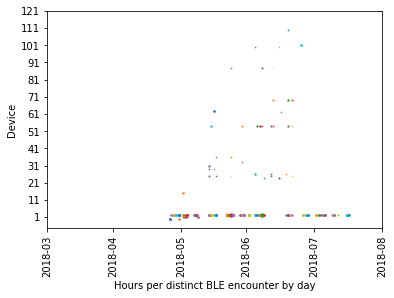

In [365]:
fig, ax = plt.subplots()

d = -1
for device in daily_unique_ble:
    d += 1
    i = 0
    for day in timespan:
        if density_daily_ble[device][day] > 0:
            ax.scatter(i, d, density_daily_ble[device][day])
        i += 1    
    
ax.set_yticks(range(1,d+1,10))
ax.set_yticklabels(range(1,d+1,10))
ax.set_ylabel('Device')
    
ax.set_xticks(month_ticks)
ax.set_xticklabels(month_labels,rotation='vertical')
ax.set_xlabel('Hours per distinct BLE encounter by day')
    
fig.savefig("guided-research-results/density_ble_perday_bubbleplot.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [14]:
data_wifi_daily = date_frame(data_wifi)

In [15]:
daily_unique_wifi = {}
daily_unique_wifi = dailyuniqueaps(daily_unique_wifi,
                                   pd.merge(data_wifi_daily, data_eduroam, left_on="bssid", right_on="mac"),
                                   'bssid',
                                   devices['device_id'].unique()
                                  )

density_daily_wifi = {}
for device in daily_unique_wifi:
    density_daily_wifi[device] = {}
    for day in timespan:
        count = len(daily_unique_wifi[device][day]["APs"])
        density = 0
        if count > 0:
            timedelta = daily_unique_wifi[device][day]["max_time"] - daily_unique_wifi[device][day]["min_time"]
            density = (timedelta.seconds/3600)/count
        density_daily_wifi[device][day] = density 

In [ ]:
fig, ax = plt.subplots()

d = -1
for device in density_daily_wifi:
    d += 1
    i = 0
    for day in timespan:
        if density_daily_wifi[device][day] > 0:
            ax.scatter(i, d, density_daily_wifi[device][day])
        i += 1    
    
ax.set_yticks(range(1,d+1,10))
ax.set_yticklabels(range(1,d+1,10))
ax.set_ylabel('Device')
    
ax.set_xticks(month_ticks)
ax.set_xticklabels(month_labels,rotation='vertical')
ax.set_xlabel('Hours per distinct eduroam WiFi AP encounter by day')
    
fig.savefig("guided-research-results/density_wifi_perday_bubbleplot.pdf", format="pdf", bbox_inches="tight")
plt.show()

Use x-means clustering to group based on AP density.

In [627]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# turn ble density dictionary into list
density_ble_values = []
for device in density_daily_ble:
    np_density = np.array(list(density_daily_ble[device].values()))
    density_ble_values += [[np.median(np_density[np_density>0]),np_density[np_density>0].shape[0]]]

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(density_ble_values, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(density_ble_values, initial_centers, 20)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters_density_ble = xmeans_instance.get_clusters()
centers_density_ble = xmeans_instance.get_centers()

/u/home/starkc/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/u/home/starkc/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


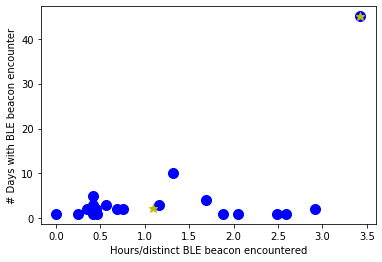

In [781]:
fig, ax = plt.subplots()
ax.set_xlabel('Hours/distinct BLE beacon encountered')
ax.set_ylabel('# Days with BLE beacon encounter')
for point in density_ble_values:
    ax.plot(point[0], point[1], color='b', marker='.', markersize='20')
for center in centers_density_ble:
    ax.plot(center[0], center[1], color='y', marker='*')
# ax.set_xscale("log")
fig.savefig("guided-research-results/density_ble_median_x-means_2d.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [606]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# turn wifi density dictionary into list
density_wifi_values = []
for device in density_daily_ble:
    np_density = np.array(list(density_daily_wifi[device].values()))
    density_wifi_values += [[np.median(np_density[np_density>0]),np_density[np_density>0].shape[0]]]

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(density_wifi_values, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(density_wifi_values, initial_centers, 20)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters_density_wifi = xmeans_instance.get_clusters()
centers_density_wifi = xmeans_instance.get_centers()

/u/home/starkc/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/u/home/starkc/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


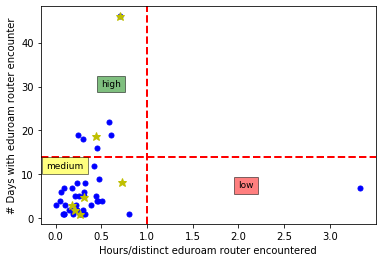

In [782]:
fig, ax = plt.subplots()
ax.set_xlabel('Hours/distinct eduroam router encountered')
ax.set_ylabel('# Days with eduroam router encounter')
for point in density_wifi_values:
    ax.plot(point[0], point[1], color='b', marker='.', markersize='10')
for center in centers_density_wifi:
    ax.plot(center[0], center[1], color='y', marker='*')
    
ax.axhline(14, color='r', linestyle='--', linewidth=2)
ax.axvline(1.0, color='r', linestyle='--', linewidth=2)

ax.text(2,7,'low',fontsize=9,bbox=dict(facecolor='red', alpha=0.5))
ax.text(-0.1,11.5,'medium',fontsize=9,bbox=dict(facecolor='yellow', alpha=0.5))
ax.text(0.5,30,'high',fontsize=9,bbox=dict(facecolor='green', alpha=0.5))

fig.savefig("guided-research-results/density_wifi_median_x-means_2d.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [713]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# turn wifi density dictionary into list
density_wifi_values_1d = []
for device in density_daily_ble:
    np_density = np.array(list(density_daily_wifi[device].values()))
    density_wifi_values_1d += [[np.nan_to_num(np.median(np_density[np_density>0]))]]

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(density_wifi_values_1d, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(density_wifi_values_1d, initial_centers, 20)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters_density_wifi_1d = xmeans_instance.get_clusters()
centers_density_wifi_1d = xmeans_instance.get_centers()

/u/home/starkc/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/u/home/starkc/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


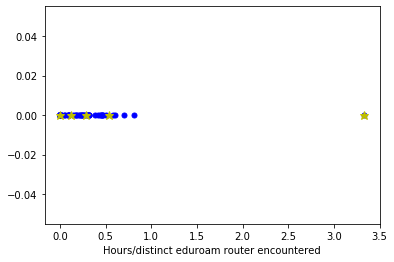

In [783]:
fig, ax = plt.subplots()
ax.set_xlabel('Hours/distinct eduroam router encountered')
for point in density_wifi_values_1d:
    ax.plot(point[0], 0, color='b', marker='.', markersize='10')
for center in centers_density_wifi_1d:
    ax.plot(center[0], 0, color='y', marker='*')
    
# ax.axhline(14, color='r', linestyle='--', linewidth=2)
# ax.axvline(1.0, color='r', linestyle='--', linewidth=2)

# ax.text(2,7,'low',fontsize=9,bbox=dict(facecolor='red', alpha=0.5))
# ax.text(-0.1,11.5,'medium',fontsize=9,bbox=dict(facecolor='yellow', alpha=0.5))
# ax.text(0.5,30,'high',fontsize=9,bbox=dict(facecolor='green', alpha=0.5))

fig.savefig("guided-research-results/density_wifi_median_x-means_1d.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [715]:
centers_density_wifi_1d

[[0.0006281377765752767],
 [0.12085388322830852],
 [0.28158105532651817],
 [0.5375850921130526],
 [3.333333333333333]]

Same analysis as above, but now remove devices with 0 density. In order to still create low, middle and high usage clusters I set the number of initial centers to 3.

In [727]:
density_wifi_values_1d_filtered = [[d] for [d] in density_wifi_values_1d if d > 0]

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 3
initial_centers = kmeans_plusplus_initializer(density_wifi_values_1d_filtered, amount_initial_centers).initialize()

# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(density_wifi_values_1d_filtered, initial_centers, 20)
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters_density_wifi_1d_filtered = xmeans_instance.get_clusters()
centers_density_wifi_1d_filtered = xmeans_instance.get_centers()

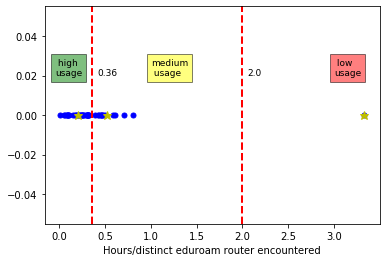

In [784]:
fig, ax = plt.subplots()
ax.set_xlabel('Hours/distinct eduroam router encountered')
for point in density_wifi_values_1d_filtered:
    ax.plot(point[0], 0, color='b', marker='.', markersize='10')
for center in centers_density_wifi_1d_filtered:
    ax.plot(center[0], 0, color='y', marker='*')
    
ax.axvline(0.36, color='r', linestyle='--', linewidth=2)
ax.text(0.41,0.02,'0.36',fontsize=9)
ax.axvline(2, color='r', linestyle='--', linewidth=2)
ax.text(2.05,0.02,'2.0',fontsize=9)

ax.text(3,0.02,' low\nusage',fontsize=9,bbox=dict(facecolor='red', alpha=0.5))
ax.text(1,0.02,'medium\n usage',fontsize=9,bbox=dict(facecolor='yellow', alpha=0.5))
ax.text(-0.05,0.02,' high\nusage',fontsize=9,bbox=dict(facecolor='green', alpha=0.5))

fig.savefig("guided-research-results/density_wifi_median_x-means_1d_filtered.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [16]:
devices_no_usage = []
devices_low_usage = []
devices_medium_usage = []
devices_high_usage = []

for device in density_daily_ble:
    np_density = np.array(list(density_daily_wifi[device].values()))
    median_density = np.nan_to_num(np.median(np_density[np_density>0]))
    if median_density == 0:
        devices_no_usage += [device]
    elif median_density < 0.36:
        devices_high_usage += [device]
    elif median_density < 2.0:
        devices_medium_usage += [device]
    else:
        devices_low_usage += [device]
        
print('no usage: ', len(devices_no_usage))
print('low usage: ', len(devices_low_usage))
print('medium usage: ', len(devices_medium_usage))
print('high usage: ', len(devices_high_usage))

devices_little_usage = devices_no_usage + devices_low_usage

no usage:  86
low usage:  1
medium usage:  12
high usage:  27


/u/home/starkc/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/u/home/starkc/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### 1.2.4.2 Mobility Based on BLE

User mobility copmuted by computing the distance between encountered bluetooth beacons on the same day. Compute overall mobility by summing up.

In [362]:
data_bluetooth_daily = date_frame(data_bluetooth)
device_location_ble = pd.merge(data_bluetooth_daily, data_beacons, left_on="bt_address", right_on="mac")
device_location_ble = device_location_ble[['timestamp','date','device_id','lat','long']]
device_coordinates_ble = {}
device_coordinates_ble = dailydistance(device_coordinates_ble, device_location_ble, devices_little_usage)

total_distance_ble = {}
for device in device_coordinates_ble:
    total_distance_ble[device] = 0
    for day in device_coordinates_ble[device]:
        total_distance_ble[device] += device_coordinates_ble[device][day]["Distance"]

total_distance_ble_sorted = list(total_distance_ble.values())
total_distance_ble_sorted.sort()

fig, ax = plt.subplots()
ax.plot(total_distance_ble_sorted, (np.arange(len(total_distance_ble_sorted))/len(total_distance_ble_sorted)))
ax.set_xlabel('Distance (m)')
ax.set_ylabel('CDF')
ax.set_xscale("log", nonposx='clip')

fig.savefig("guided-research-results/mobility_cdf_ble_lowusage.pdf",format="pdf", bbox_inches="tight")
plt.show()

for device in total_distance_ble:
    print(device)
    print('usage: ', usage_days[device])
    print('distance: ', total_distance_ble[device])

NameError: name 'devices_little_usage' is not defined

initialize
fill ecountered APs
compute distance


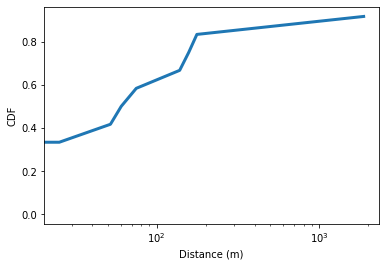

2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1
usage:  6
distance:  0.0
3bbcc834-7c27-46b4-aa56-51267ab6e283
usage:  15
distance:  176.57809381442166
b212c0fd-6209-43e8-a2da-d98f31b807dd
usage:  83
distance:  1873.7692044168514
275e24d8-634b-4b3c-806d-f5c39feb697e
usage:  1
distance:  25.15917536250197
b60d7582-5851-4927-a8aa-7cdff291cdc7
usage:  37
distance:  74.84685957742754
4e7801df-ed93-43fa-9246-7172d0183f23
usage:  46
distance:  60.512251203809626
aaf1ecc4-fba4-42ac-80b6-0c7b2c8a7735
usage:  44
distance:  138.36204644048186
8ba39613-aeef-4715-8be6-56bad1d20137
usage:  5
distance:  0.0
19d0f512-cfe8-4758-9b8b-3b9c870a0907
usage:  45
distance:  51.91865461891496
24b4fbdb-9742-4737-87c6-054bb9fbd114
usage:  46
distance:  157.32161729126588
6b856387-0749-47cc-a24a-b9703f281b4f
usage:  18
distance:  0
8b21299a-f3bb-43b3-8e1b-5b9f93696b24
usage:  22
distance:  0


In [786]:
data_bluetooth_daily = date_frame(data_bluetooth)
device_location_ble = pd.merge(data_bluetooth_daily, data_beacons, left_on="bt_address", right_on="mac")
device_location_ble = device_location_ble[['timestamp','date','device_id','lat','long']]
device_coordinates_ble = {}
device_coordinates_ble = dailydistance(device_coordinates_ble, device_location_ble, devices_medium_usage)

total_distance_ble = {}
for device in device_coordinates_ble:
    total_distance_ble[device] = 0
    for day in device_coordinates_ble[device]:
        total_distance_ble[device] += device_coordinates_ble[device][day]["Distance"]

total_distance_ble_sorted = list(total_distance_ble.values())
total_distance_ble_sorted.sort()

fig, ax = plt.subplots()
ax.plot(total_distance_ble_sorted, (np.arange(len(total_distance_ble_sorted))/len(total_distance_ble_sorted)))
ax.set_xlabel('Distance (m)')
ax.set_ylabel('CDF')
ax.set_xscale("log", nonposx='clip')

fig.savefig("guided-research-results/mobility_cdf_ble_mediumusage.pdf",format="pdf", bbox_inches="tight")
plt.show()

for device in total_distance_ble:
    print(device)
    print('usage: ', usage_days[device])
    print('distance: ', total_distance_ble[device])

initialize
fill ecountered APs
compute distance


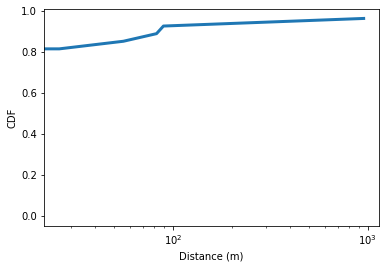

7a52f62b-b528-40b3-864b-1ae7eed1e189
usage:  63
distance:  0
424bf6cf-a071-4f55-b2a6-2f4e24b46b91
usage:  1
distance:  0
3775c074-44d7-4349-9273-3cd8a959369d
usage:  6
distance:  89.44295203472396
e003fc12-ace7-41ee-b7f6-9dc1b5c5adfd
usage:  30
distance:  0.0
68ea945e-33eb-44ea-82f9-7ace16ac0d77
usage:  42
distance:  0.0
b7a60829-bbbe-48d5-9b6b-fc2f2de0a70c
usage:  48
distance:  0
92369119-68fe-436d-8ca8-e7d03d903661
usage:  43
distance:  0
2a3062a6-0eeb-4a8d-9623-adb8d5ca0eda
usage:  23
distance:  0
b3fa9c28-64d5-487b-9775-61ca9d9b3f3b
usage:  4
distance:  0
3f4abf62-e6ad-400c-a2fd-565aecd0f24c
usage:  41
distance:  951.5921768574641
ede758db-b887-4b64-b34c-665130909c6d
usage:  4
distance:  0
5d5561d6-3895-4333-b279-8f32a6676946
usage:  4
distance:  0
0d570dc2-b6fd-4b58-a821-04ca19a63d39
usage:  37
distance:  0.0
a9391bee-d52e-4477-bb13-f364e532c241
usage:  31
distance:  82.42236810430127
f21c5f10-55ff-46e0-81ec-5d55bda030bc
usage:  3
distance:  0
08ddf60e-af58-46a5-a040-deba1cf9cd5a


In [787]:
data_bluetooth_daily = date_frame(data_bluetooth)
device_location_ble = pd.merge(data_bluetooth_daily, data_beacons, left_on="bt_address", right_on="mac")
device_location_ble = device_location_ble[['timestamp','date','device_id','lat','long']]
device_coordinates_ble = {}
device_coordinates_ble = dailydistance(device_coordinates_ble, device_location_ble, devices_high_usage)

total_distance_ble = {}
for device in device_coordinates_ble:
    total_distance_ble[device] = 0
    for day in device_coordinates_ble[device]:
        total_distance_ble[device] += device_coordinates_ble[device][day]["Distance"]

total_distance_ble_sorted = list(total_distance_ble.values())
total_distance_ble_sorted.sort()

fig, ax = plt.subplots()
ax.plot(total_distance_ble_sorted, (np.arange(len(total_distance_ble_sorted))/len(total_distance_ble_sorted)))
ax.set_xlabel('Distance (m)')
ax.set_ylabel('CDF')
ax.set_xscale("log", nonposx='clip')

fig.savefig("guided-research-results/mobility_cdf_ble_highusage.pdf",format="pdf", bbox_inches="tight")
plt.show()

for device in total_distance_ble:
    print(device)
    print('usage: ', usage_days[device])
    print('distance: ', total_distance_ble[device])

#### 1.2.4.3 Mobility Based on eduroam routers

Retrieve coordinates from TUM roomfinder for the eduram WiFi routers. **ALREADY DONE, NO NEED TO RUN AGAIN**

In [86]:
import re
import ssl
import urllib.request
from bs4 import BeautifulSoup

p = re.compile("^\d\d\.\d\d\.\d\d\d")

for i in range(data_eduroam.shape[0]):
    mac = data_eduroam.iloc[i]['mac']
    room = p.search(data_eduroam.iloc[i]['room'])
    if room != None:
        url = 'https://portal.mytum.de/campus/roomfinder/roomfinder_viewmap?mapid=156&roomid=' + room[0] + '@56' + room[0].split('.')[1]
        with urllib.request.urlopen(url, context=ssl.SSLContext()) as response:
            html = response.read()
            soup = BeautifulSoup(html, 'html.parser')
            link = str(soup.find('a', attrs={'target':'googlemap'}))
            lat = link.find('mlat=')
            amp1 = link.find('&',lat)
            long = link.find('mlon=')
            amp2 = link.find('&',long)
            data_eduroam.loc[data_eduroam['mac']==mac,'lat'] = link[lat+5:amp1]
            data_eduroam.loc[data_eduroam['mac']==mac,'long'] = link[long+5:amp2]
            
data_eduroam.to_csv(os.path.join(path_data_collection, "eduroam.csv"),sep=";",index=False)

Compute daily distances and sum them up.

(44898, 5)
initialize
fill ecountered APs
compute distance


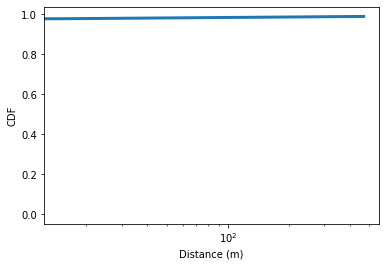

8cbb4f59-2635-4ac7-b81a-138b4f0f085e
usage:  112
distance:  0
6e05ff54-0410-4d17-8010-3cb143f4b2b3
usage:  56
distance:  0
0aa8a473-873a-46cf-a404-1721d24f3057
usage:  0
distance:  0
cb8aa48d-ed6a-46c1-aa73-2e278fb502f5
usage:  14
distance:  0
6db4d30d-da5f-489d-a697-311c2c36804d
usage:  60
distance:  0
3dc6770c-ce88-406b-a53b-fa544d7bbb64
usage:  72
distance:  0
5b108926-9f88-426b-8c69-9804642333d9
usage:  68
distance:  0
7355074b-6a17-47dd-8f9d-c5a6e3e94422
usage:  40
distance:  0
8062f341-d65a-4939-baa7-17e04b685e90
usage:  0
distance:  0
a96a1f11-5fca-4eaa-a297-3fdf226f3a56
usage:  61
distance:  0
eeed598a-9824-4a97-9def-85599d2df0b7
usage:  0
distance:  0
2fae703d-b016-4a89-8f2e-de8808379d1e
usage:  31
distance:  0
169d4cd3-7033-409d-b80b-5ff8b8b7c8f5
usage:  34
distance:  0
45c1a721-92d1-4fd9-b747-0e70d5de7192
usage:  0
distance:  0
476769a4-ee47-4355-add1-756a17749e69
usage:  3
distance:  0
e1c244a5-8e63-45eb-8a43-62da6fe053ff
usage:  4
distance:  0
82d3d81c-36bf-44ce-8cb7-3be2d

In [790]:
data_wifi_daily = date_frame(data_wifi)
device_location_wifi = pd.merge(data_wifi_daily, data_eduroam, left_on="bssid", right_on="mac")
device_location_wifi = device_location_wifi[['timestamp','date','device_id','lat','long']]
print(device_location_wifi.shape)
device_coordinates_wifi = {}
device_coordinates_wifi = dailydistance(device_coordinates_wifi, device_location_wifi, devices_little_usage)

total_distance_wifi = {}
for device in device_coordinates_wifi:
    total_distance_wifi[device] = 0
    for day in device_coordinates_wifi[device]:
        total_distance_wifi[device] += device_coordinates_wifi[device][day]["Distance"]

total_distance_wifi_sorted = list(total_distance_wifi.values())
total_distance_wifi_sorted.sort()

fig, ax = plt.subplots()
ax.plot(total_distance_wifi_sorted, (np.arange(len(total_distance_wifi_sorted))/len(total_distance_wifi_sorted)))
ax.set_xlabel('Distance (m)')
ax.set_ylabel('CDF')
ax.set_xscale("log", nonposx='clip')

fig.savefig("guided-research-results/mobility_cdf_wifi_lowusage.pdf",format="pdf", bbox_inches="tight")
plt.show()

for device in total_distance_wifi:
    print(device)
    print('usage: ', usage_days[device])
    print('distance: ', total_distance_wifi[device])

(44898, 5)
initialize
fill ecountered APs
compute distance


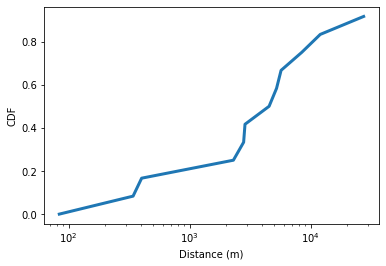

2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1
usage:  6
distance:  341.1679845189389
3bbcc834-7c27-46b4-aa56-51267ab6e283
usage:  15
distance:  5235.629385096119
b212c0fd-6209-43e8-a2da-d98f31b807dd
usage:  83
distance:  27476.61588323934
275e24d8-634b-4b3c-806d-f5c39feb697e
usage:  1
distance:  83.77629290140207
b60d7582-5851-4927-a8aa-7cdff291cdc7
usage:  37
distance:  2301.9082204840474
4e7801df-ed93-43fa-9246-7172d0183f23
usage:  46
distance:  8450.852957034289
aaf1ecc4-fba4-42ac-80b6-0c7b2c8a7735
usage:  44
distance:  5706.355043930298
8ba39613-aeef-4715-8be6-56bad1d20137
usage:  5
distance:  2798.0099570910247
19d0f512-cfe8-4758-9b8b-3b9c870a0907
usage:  45
distance:  4542.4344714537465
24b4fbdb-9742-4737-87c6-054bb9fbd114
usage:  46
distance:  12028.372314000519
6b856387-0749-47cc-a24a-b9703f281b4f
usage:  18
distance:  401.7207440191177
8b21299a-f3bb-43b3-8e1b-5b9f93696b24
usage:  22
distance:  2871.9262958466797


In [791]:
data_wifi_daily = date_frame(data_wifi)
device_location_wifi = pd.merge(data_wifi_daily, data_eduroam, left_on="bssid", right_on="mac")
device_location_wifi = device_location_wifi[['timestamp','date','device_id','lat','long']]
print(device_location_wifi.shape)
device_coordinates_wifi = {}
device_coordinates_wifi = dailydistance(device_coordinates_wifi, device_location_wifi, devices_medium_usage)

total_distance_wifi = {}
for device in device_coordinates_wifi:
    total_distance_wifi[device] = 0
    for day in device_coordinates_wifi[device]:
        total_distance_wifi[device] += device_coordinates_wifi[device][day]["Distance"]

total_distance_wifi_sorted = list(total_distance_wifi.values())
total_distance_wifi_sorted.sort()

fig, ax = plt.subplots()
ax.plot(total_distance_wifi_sorted, (np.arange(len(total_distance_wifi_sorted))/len(total_distance_wifi_sorted)))
ax.set_xlabel('Distance (m)')
ax.set_ylabel('CDF')
ax.set_xscale("log", nonposx='clip')

fig.savefig("guided-research-results/mobility_cdf_wifi_mediumusage.pdf",format="pdf", bbox_inches="tight")
plt.show()

for device in total_distance_wifi:
    print(device)
    print('usage: ', usage_days[device])
    print('distance: ', total_distance_wifi[device])

(44898, 5)
initialize
fill ecountered APs
compute distance


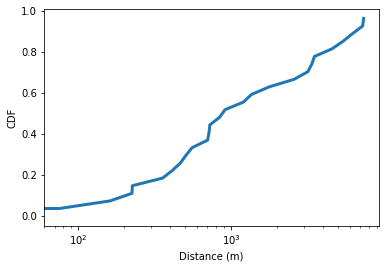

7a52f62b-b528-40b3-864b-1ae7eed1e189
usage:  63
distance:  161.70054341227865
424bf6cf-a071-4f55-b2a6-2f4e24b46b91
usage:  1
distance:  0.0
3775c074-44d7-4349-9273-3cd8a959369d
usage:  6
distance:  1361.804692104975
e003fc12-ace7-41ee-b7f6-9dc1b5c5adfd
usage:  30
distance:  6242.09088776492
68ea945e-33eb-44ea-82f9-7ace16ac0d77
usage:  42
distance:  1780.0799843023378
b7a60829-bbbe-48d5-9b6b-fc2f2de0a70c
usage:  48
distance:  718.6251433242953
92369119-68fe-436d-8ca8-e7d03d903661
usage:  43
distance:  7388.497910681897
2a3062a6-0eeb-4a8d-9623-adb8d5ca0eda
usage:  23
distance:  703.6226358774883
b3fa9c28-64d5-487b-9775-61ca9d9b3f3b
usage:  4
distance:  3187.049667452076
3f4abf62-e6ad-400c-a2fd-565aecd0f24c
usage:  41
distance:  914.4958957146952
ede758db-b887-4b64-b34c-665130909c6d
usage:  4
distance:  225.08553129675067
5d5561d6-3895-4333-b279-8f32a6676946
usage:  4
distance:  556.6130688097189
0d570dc2-b6fd-4b58-a821-04ca19a63d39
usage:  37
distance:  7276.562921538346
a9391bee-d52e-44

In [792]:
data_wifi_daily = date_frame(data_wifi)
device_location_wifi = pd.merge(data_wifi_daily, data_eduroam, left_on="bssid", right_on="mac")
device_location_wifi = device_location_wifi[['timestamp','date','device_id','lat','long']]
print(device_location_wifi.shape)
device_coordinates_wifi = {}
device_coordinates_wifi = dailydistance(device_coordinates_wifi, device_location_wifi, devices_high_usage)

total_distance_wifi = {}
for device in device_coordinates_wifi:
    total_distance_wifi[device] = 0
    for day in device_coordinates_wifi[device]:
        total_distance_wifi[device] += device_coordinates_wifi[device][day]["Distance"]

total_distance_wifi_sorted = list(total_distance_wifi.values())
total_distance_wifi_sorted.sort()

fig, ax = plt.subplots()
ax.plot(total_distance_wifi_sorted, (np.arange(len(total_distance_wifi_sorted))/len(total_distance_wifi_sorted)))
ax.set_xlabel('Distance (m)')
ax.set_ylabel('CDF')
ax.set_xscale("log", nonposx='clip')

fig.savefig("guided-research-results/mobility_cdf_wifi_highusageh.pdf",format="pdf", bbox_inches="tight")
plt.show()

for device in total_distance_wifi:
    print(device)
    print('usage: ', usage_days[device])
    print('distance: ', total_distance_wifi[device])

Only use the router with the highest RSSI per iteration to get more precise location.

In [794]:
data_wifi_eduroam_highest_rssi.head()

timestamp                             device_id  \
0 2018-04-23 11:06:49.304  2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1   
1 2018-04-23 11:16:48.498  2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1   
2 2018-04-23 11:22:38.126  2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1   
3 2018-04-25 15:32:21.279  3bbcc834-7c27-46b4-aa56-51267ab6e283   
4 2018-04-25 15:35:48.919  3bbcc834-7c27-46b4-aa56-51267ab6e283   

                 mac    rssi  
0  00:26:3e:f4:d1:00 -70.000  
1  00:26:3e:f4:d1:00 -71.000  
2  00:26:3e:f4:d1:00 -75.000  
3  00:26:3e:f4:d1:00 -36.000  
4  00:26:3e:f4:d1:00 -77.000

(20287, 5)
initialize
fill ecountered APs
compute distance


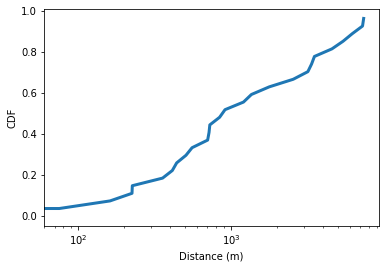

7a52f62b-b528-40b3-864b-1ae7eed1e189
usage:  63
distance:  161.70054341227865
424bf6cf-a071-4f55-b2a6-2f4e24b46b91
usage:  1
distance:  0.0
3775c074-44d7-4349-9273-3cd8a959369d
usage:  6
distance:  1361.804692104975
e003fc12-ace7-41ee-b7f6-9dc1b5c5adfd
usage:  30
distance:  6226.432710329169
68ea945e-33eb-44ea-82f9-7ace16ac0d77
usage:  42
distance:  1780.0799843023378
b7a60829-bbbe-48d5-9b6b-fc2f2de0a70c
usage:  48
distance:  718.6251433242953
92369119-68fe-436d-8ca8-e7d03d903661
usage:  43
distance:  7388.497910681897
2a3062a6-0eeb-4a8d-9623-adb8d5ca0eda
usage:  23
distance:  703.6226358774883
b3fa9c28-64d5-487b-9775-61ca9d9b3f3b
usage:  4
distance:  3187.049667452076
3f4abf62-e6ad-400c-a2fd-565aecd0f24c
usage:  41
distance:  914.4958957146952
ede758db-b887-4b64-b34c-665130909c6d
usage:  4
distance:  225.08553129675067
5d5561d6-3895-4333-b279-8f32a6676946
usage:  4
distance:  556.6130688097189
0d570dc2-b6fd-4b58-a821-04ca19a63d39
usage:  37
distance:  7264.18364606038
a9391bee-d52e-44

In [793]:
data_wifi_daily = date_frame(data_wifi_eduroam_highest_rssi)
device_location_wifi = pd.merge(data_wifi_daily, data_eduroam, left_on="mac", right_on="mac")
device_location_wifi = device_location_wifi[['timestamp','date','device_id','lat','long']]
print(device_location_wifi.shape)
device_coordinates_wifi = {}
device_coordinates_wifi = dailydistance(device_coordinates_wifi, device_location_wifi, devices_high_usage)

total_distance_wifi = {}
for device in device_coordinates_wifi:
    total_distance_wifi[device] = 0
    for day in device_coordinates_wifi[device]:
        total_distance_wifi[device] += device_coordinates_wifi[device][day]["Distance"]

total_distance_wifi_sorted = list(total_distance_wifi.values())
total_distance_wifi_sorted.sort()

fig, ax = plt.subplots()
ax.plot(total_distance_wifi_sorted, (np.arange(len(total_distance_wifi_sorted))/len(total_distance_wifi_sorted)))
ax.set_xlabel('Distance (m)')
ax.set_ylabel('CDF')
ax.set_xscale("log", nonposx='clip')

fig.savefig("guided-research-results/mobility_cdf_highestrssi_wifi_highusage.pdf",format="pdf", bbox_inches="tight")
plt.show()

for device in total_distance_wifi:
    print(device)
    print('usage: ', usage_days[device])
    print('distance: ', total_distance_wifi[device])

# 2 Create Ground Truth Labels

In [401]:
known_aps_ble = pd.merge(data_bluetooth, data_beacons, left_on="bt_address", right_on="mac")

In [402]:
known_aps_wifi = pd.merge(data_wifi_highest_rssi[['timestamp','device_id','mac']], data_eduroam[['room','mac']], left_on="mac", right_on="mac")

NameError: name 'data_wifi_highest_rssi' is not defined

## 2.1 Ground Truth Function

Input: 
- `device1` [string] : first device of possible encounter device pair
- `device2` [string] : second device of possible encounter device pair
- `data_sensor` [dataframe] : dataframe with the corresponding sensor data (bluetooth beacons or eduroam known locations)
- `sensor_id_field` [string] : field in `data_sensor` that can be used to join sensor readings; for bluetooth, choice between single beacons and grouped beacons is done here
- `min_timestamp` [datetime] : look for encounters after this time
- `max_timestamp` [datetime] : look for encounters before this time
- `dt` [integer] : timespan used for encounter definition

Output:

Returns $1$ if devices recorded same AP at least once between `min_timestamp` and `max_timestamp`, where the timestamps are different of at most $dt$ minutes, $0$ if not.

In [60]:
def get_encounter(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp, dt):
    aps1 = data_sensor[(data_sensor['device_id'] == device1) & 
                       (data_sensor['timestamp'] >= min_timestamp) &
                       (data_sensor['timestamp'] <= max_timestamp)
                      ]
    aps2 = data_sensor[(data_sensor['device_id'] == device2) & 
                       (data_sensor['timestamp'] >= min_timestamp) &
                       (data_sensor['timestamp'] <= max_timestamp)
                      ]
    encounters = pd.merge(aps1, aps2, on=sensor_id_field)
    encounters = encounters[encounters['timestamp_x']+pd.Timedelta(minutes=dt/2) >= encounters['timestamp_y']]
    encounters = encounters[encounters['timestamp_x']-pd.Timedelta(minutes=dt/2) <= encounters['timestamp_y']]
    return (1 if encounters.shape[0] > 0 else 0)

In [41]:
get_encounter('2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
              'b212c0fd-6209-43e8-a2da-d98f31b807dd',
              data_wifi,
              'bssid',
              pd.to_datetime('2018-04-26'),
              pd.to_datetime('2018-04-27'),
              180
       )

1

## 2.2 Encounter Definition: Timespan

In this case, every matching AP counts as encounter, e.g. if three APs are seen by both devices, this counts as three encounters. Order of devices is also not taken into account, so three APs for two devices result in six encounters.

In [89]:
encounters_ble_id = pd.merge(known_aps_ble,known_aps_ble,on='id')
encounters_ble_grouped = pd.merge(known_aps_ble,known_aps_ble,on='location_group')

# remove encounters with own device
encounters_ble_id = encounters_ble_id[encounters_ble_id['device_id_x'] != encounters_ble_id['device_id_y']]
encounters_ble_grouped = encounters_ble_grouped[encounters_ble_grouped['device_id_x'] != encounters_ble_grouped['device_id_y']]

In [392]:
encounters_wifi = pd.merge(known_aps_wifi,known_aps_wifi,on='mac')
encounters_wifi = encounters_wifi[encounters_wifi['device_id_x'] != encounters_wifi['device_id_y']]

### 2.2.1 Compare Encounter Timespans 

Individual BLE
Distinct encounters with no timespan limit: 10946


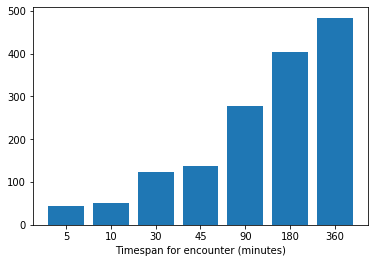

Clustered BLE
Encounters with no timespan limit: 53956
Encounters beacons grouped with timespan   5 minutes:  46
Encounters beacons grouped with timespan  10 minutes:  58
Encounters beacons grouped with timespan  30 minutes: 140
Encounters beacons grouped with timespan  45 minutes: 160
Encounters beacons grouped with timespan  90 minutes: 318
Encounters beacons grouped with timespan 180 minutes: 490
Encounters beacons grouped with timespan 360 minutes: 666


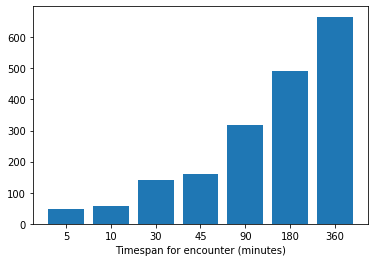

In [101]:
encounter_vis = [[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]]

print('Individual BLE')
print("Distinct encounters with no timespan limit: %3d" % (encounters_ble_id.shape[0]/2))
i = 0
for dt in timespans:
    tmp = encounters_ble_id.copy()
    tmp = tmp[tmp['timestamp_x']+pd.Timedelta(minutes=dt/2) >= tmp['timestamp_y']]
    tmp = tmp[tmp['timestamp_x']-pd.Timedelta(minutes=dt/2) <= tmp['timestamp_y']]
    encounter_vis[i][0] = tmp.shape[0]
    i += 1
    
fig, ax = plt.subplots()
ax.bar(range(len(encounter_vis)), [encounter_vis[v][0] for v in range(len(encounter_vis))], align='center')
ax.set_xticks(range(len(encounter_vis)))
ax.set_xticklabels(timespans)
ax.set_xlabel('Timespan for encounter (minutes)')

fig.savefig("guided-research-results/encounters_ble_id.pdf", format="pdf", bbox_inches="tight")
plt.show()
    

print('Clustered BLE')
print("Encounters with no timespan limit: %3d" % (encounters_ble_grouped.shape[0]))
i = 0
for dt in timespans:
    tmp = encounters_ble_grouped.copy()
    tmp = tmp[tmp['timestamp_x']+pd.Timedelta(minutes=dt/2) >= tmp['timestamp_y']]
    tmp = tmp[tmp['timestamp_x']-pd.Timedelta(minutes=dt/2) <= tmp['timestamp_y']]
    print("Encounters beacons grouped with timespan %3d minutes: %3d" % (dt,tmp.shape[0]))
    encounter_vis[i][1] = tmp.shape[0]
    i += 1
    
fig, ax = plt.subplots()
ax.bar(range(len(encounter_vis)), [encounter_vis[v][1] for v in range(len(encounter_vis))], align='center')
ax.set_xticks(range(len(encounter_vis)))
ax.set_xticklabels(timespans)
ax.set_xlabel('Timespan for encounter (minutes)')

fig.savefig("guided-research-results/encounters_ble_grouped.pdf", format="pdf", bbox_inches="tight")
plt.show()

Eduroam
Distinct encounters with no timespan limit: 3053
Encounters eduroam with timespan   5 minutes:   2
Encounters eduroam with timespan  10 minutes:   2
Encounters eduroam with timespan  30 minutes:   4
Encounters eduroam with timespan  45 minutes:  10
Encounters eduroam with timespan  90 minutes:  24
Encounters eduroam with timespan 180 minutes:  50
Encounters eduroam with timespan 360 minutes: 102


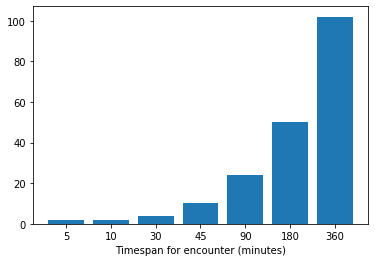

In [394]:
print('Eduroam')
print("Distinct encounters with no timespan limit: %3d" % (encounters_wifi.shape[0]/2))
i = 0
for dt in timespans:
    tmp = encounters_wifi
    tmp = tmp[tmp['timestamp_x']+pd.Timedelta(minutes=dt/2) >= tmp['timestamp_y']]
    tmp = tmp[tmp['timestamp_x']-pd.Timedelta(minutes=dt/2) <= tmp['timestamp_y']]
    print("Encounters eduroam with timespan %3d minutes: %3d" % (dt,tmp.shape[0]))
    encounter_vis[i][2] = tmp.shape[0]
    i += 1
    
fig, ax = plt.subplots()
ax.bar(range(len(encounter_vis)), [encounter_vis[v][2] for v in range(len(encounter_vis))], align='center')
ax.set_xticks(range(len(encounter_vis)))
ax.set_xticklabels(timespans)
ax.set_xlabel('Timespan for encounter (minutes)')

fig.savefig("guided-research-results/encounters_wifi.pdf", format="pdf", bbox_inches="tight")
plt.show()

### 2.2.2 Legacy BLE Statistics

In [5]:
ground_truth_locations_sorted = ground_truth_locations.sort_values(by=['device_id','timestamp']).copy()

gtl_diff = ground_truth_locations_sorted[['device_id','timestamp']].copy()
gtl_diff["timestep"] = ground_truth_locations_sorted[['device_id','timestamp']].groupby(['device_id']).diff()
gtl_diff.describe()

timestep
count                      700
mean    0 days 13:46:21.783678
std     2 days 00:24:54.966681
min            0 days 00:00:00
25%     0 days 00:09:10.508500
50%     0 days 00:24:35.876500
75%     0 days 01:49:58.031250
max    20 days 00:25:23.430000

# 3 Wireless Features (Original Paper)

Based on https://arxiv.org/pdf/1610.04730.pdf.

All features contain the following parameters:
- `device1` [string] : first device of possible encounter device pair
- `device2` [string] : second device of possible encounter device pair
- `data_sensor` [dataframe] : dataframe with the corresponding sensor data
- `sensor_id_field` [string] : field in `data_sensor` that can be used to join sensor readings 
- `min_timestamp` [datetime] : encounter timespan starts now
- `max_timestamp` [datetime] : encounter timespan ends now
- `dt` [integer] : timespan that used for encounter definition

The timespan between `min_timestamp` and `max_timestamp` should correspond to whatever duration between two devices recording the same ground truth location is seen as encounter.

## 3.1 AP Presence

Set of distinct APs seen by both device 1 and 2 during the timespan.

In [137]:
def overlapSet(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp):
    aps1 = data_sensor[(data_sensor['device_id'] == device1) & 
                       (data_sensor['timestamp'] >= min_timestamp) &
                       (data_sensor['timestamp'] <= max_timestamp)
                      ][sensor_id_field].unique()
    aps2 = data_sensor[(data_sensor['device_id'] == device2) & 
                       (data_sensor['timestamp'] >= min_timestamp) &
                       (data_sensor['timestamp'] <= max_timestamp)
                      ][sensor_id_field].unique()
    return np.intersect1d(aps1,aps2)

Set of distinct APs seen by either device 1, 2, or both together during the timespan.

In [138]:
def unionSet(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp):
    aps1 = data_sensor[(data_sensor['device_id'] == device1) & 
                       (data_sensor['timestamp'] >= min_timestamp) &
                       (data_sensor['timestamp'] <= max_timestamp)
                      ][sensor_id_field].unique()
    aps2 = data_sensor[(data_sensor['device_id'] == device2) & 
                       (data_sensor['timestamp'] >= min_timestamp) &
                       (data_sensor['timestamp'] <= max_timestamp)
                      ][sensor_id_field].unique()
    return np.union1d(aps1,aps2)

### 3.1.1 Overlap

Number of distinct APs seen by both device 1 and 2 during the timespan.

In [139]:
def overlap(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp):
    return overlapSet(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp).shape[0]

In [111]:
overlap('3bbcc834-7c27-46b4-aa56-51267ab6e283',
        '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
        data_bluetooth,
        'bt_address',
        pd.to_datetime('2018-03-19'),
        pd.to_datetime('2018-08-01')
       )

16

### 3.1.2 Union

Number of distinct APs seen by device 1 and 2 together during the timespan.

In [140]:
def union(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp):
    return unionSet(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp).shape[0]

In [116]:
union('3bbcc834-7c27-46b4-aa56-51267ab6e283',
      '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
      data_bluetooth,
      'bt_address',
      pd.to_datetime('2018-03-19'),
      pd.to_datetime('2018-08-01')
     )

3388

### 3.1.3 Jaccard

Overlap divided by Union (see above).

In [141]:
def jaccard(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp):
    m = overlap(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp)
    n = union(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp)
    if n == 0: return None
    return(m/n)

In [482]:
jaccard('3bbcc834-7c27-46b4-aa56-51267ab6e283',
        '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
        data_bluetooth,
        'bt_address',
        pd.to_datetime('2018-03-19'),
        pd.to_datetime('2018-08-01')
       )

0.004722550177095631

### 3.1.4 Non-Overlap

Number of distinct APs seen by either device 1 or 2, but not both.

In [142]:
def non_overlap(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp):
    m = overlap(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp)
    n = union(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp)
    return(n-m)

In [120]:
non_overlap('3bbcc834-7c27-46b4-aa56-51267ab6e283',
            '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
            data_bluetooth,
            'bt_address',
            pd.to_datetime('2018-03-19'),
            pd.to_datetime('2018-08-01')
           )

3372

## 3.2 RSSI

As these features need a list of distinct APs, using a timespan longer than one recording cycle might lead to inconsistent results. As we define encounters as "same ground truth AP seen in timespan $dt$", where $dt$ is potentially larger than the time between two iterations, we take the median RSSI. 

In [143]:
def medianTimespanRSSI(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp):
    # Get overlapping APs.
    aps1 = data_sensor[(data_sensor['device_id'] == device1) & 
                       (data_sensor['timestamp'] >= min_timestamp) &
                       (data_sensor['timestamp'] <= max_timestamp)
                      ]
    aps2 = data_sensor[(data_sensor['device_id'] == device2) & 
                       (data_sensor['timestamp'] >= min_timestamp) &
                       (data_sensor['timestamp'] <= max_timestamp)
                      ]
    
    common = overlapSet(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp)
    
    # Compute median RSSI for each AP per device.
    median1 = aps1[aps1[sensor_id_field].isin(common)][[sensor_id_field,rssi_field]].groupby([sensor_id_field], as_index=False).median().sort_values(by=[sensor_id_field])
    median2 = aps2[aps2[sensor_id_field].isin(common)][[sensor_id_field,rssi_field]].groupby([sensor_id_field], as_index=False).median().sort_values(by=[sensor_id_field])

    return(median1, median2)

### 3.2.1 Spearman

Returns spearman correlation of the median RSSI of APs encountered by both device 1 and 2.

In [144]:
def spearman(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp):
    median1,median2 = medianTimespanRSSI(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp)
    
    # Compute ranks.
    median1['rank'] = median1[rssi_field].rank(method='min', ascending=False)
    median2['rank'] = median2[rssi_field].rank(method='min', ascending=False)
    
    return stats.spearmanr(median1['rank'].values, median2['rank'].values)[0]

In [494]:
spearman('3bbcc834-7c27-46b4-aa56-51267ab6e283',
         '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
         data_bluetooth,
         'bt_address',
         'bt_rssi',
         pd.to_datetime('2018-03-19'),
         pd.to_datetime('2018-08-01')
        )

0.2563902564084361

### 3.2.2 Pearson

In [145]:
def pearson(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp):
    median1,median2 = medianTimespanRSSI(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp)
    if len(median1) < 2 or len(median2) < 2: return None
    return stats.pearsonr(median1[rssi_field], median2[rssi_field])[0]

In [492]:
pearson('3bbcc834-7c27-46b4-aa56-51267ab6e283',
        '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
        data_bluetooth,
        'bt_address',
        'bt_rssi',
        pd.to_datetime('2018-03-19'),
        pd.to_datetime('2018-08-01')
        )

0.2941624676385465

### 3.2.3 Manhattan

In [146]:
def manhattan(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp):
    median1,median2 = medianTimespanRSSI(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp)    
    return dist.cityblock(median1[rssi_field], median2[rssi_field])/median1.shape[0]

In [146]:
manhattan('3bbcc834-7c27-46b4-aa56-51267ab6e283',
          '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
          data_bluetooth,
          'bt_address',
          'bt_rssi',
          pd.to_datetime('2018-03-19'),
          pd.to_datetime('2018-08-01')
         )

9.9375

### 3.2.4 Euclidean

In [147]:
def euclidean(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp):
    median1,median2 = medianTimespanRSSI(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp)    
    if len(median1) < 1 or len(median2) < 1:
        return None
    return dist.euclidean(median1[rssi_field], median2[rssi_field])/median1.shape[0]

In [498]:
euclidean('3bbcc834-7c27-46b4-aa56-51267ab6e283',
          '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
          data_bluetooth,
          'bt_address',
          'bt_rssi',
          pd.to_datetime('2018-03-19'),
          pd.to_datetime('2018-08-01')
         )

3.2316186926987536

## 3.3 Presence + RSSI

### 3.3.1 Top AP

Check if AP with highest RSSI is same for both devices.

In [148]:
def topAP(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp):
    median1,median2 = medianTimespanRSSI(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp)    
    
    # Compute ranks.
    median1['rank'] = median1[rssi_field].rank(method='min', ascending=False)
    median2['rank'] = median2[rssi_field].rank(method='min', ascending=False)
    
    top1 = median1[median1['rank'] == 1]
    top2 = median2[median2['rank'] == 1]
    
    return 1 if np.intersect1d(top1[sensor_id_field].unique(), top2[sensor_id_field].unique()).shape[0] > 0 else 0

In [526]:
topAP('3bbcc834-7c27-46b4-aa56-51267ab6e283',
      '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
      data_bluetooth,
      'bt_address',
      'bt_rssi',
      pd.to_datetime('2018-03-19'),
      pd.to_datetime('2018-08-01')
     )

0

### 3.3.2 Top AP $\pm 6 dB$

Check if AP with highest RSSI for one device appears within 6dB of that RSSI in the other device's APs.

In [149]:
def topAP6dB(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp):
    median1,median2 = medianTimespanRSSI(device1, device2, data_sensor, sensor_id_field, rssi_field, min_timestamp, max_timestamp)    
    
    # Compute ranks.
    median1['rank'] = median1[rssi_field].rank(method='min', ascending=False)
    median2['rank'] = median2[rssi_field].rank(method='min', ascending=False)
    
    top1 = median1[median1['rank'] == 1]
    top2 = median2[median2['rank'] == 1]
    
    if np.intersect1d(top1[sensor_id_field].unique(), top2[sensor_id_field].unique()).shape[0] > 0:
        return 1
    # Top APs from device 1
    for AP in top1.values:
        if float(median2[median2[sensor_id_field] == AP[0]][rssi_field]) - float(AP[1]) <= 6:
            return 1
    # Top APs from device 2
    for AP in top2.values:
        if float(median1[median1[sensor_id_field] == AP[0]][rssi_field]) - float(AP[1]) <= 6:
            return 1
    # Not in range
    return 0

In [524]:
topAP6dB('3bbcc834-7c27-46b4-aa56-51267ab6e283',
         '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
         data_bluetooth,
         'bt_address',
         'bt_rssi',
         pd.to_datetime('2018-03-19'),
         pd.to_datetime('2018-08-01')
        )

1

## 3.4 Popularity

Returns a list containing the number of distinct devices seeing the APs seen by devices 1 and 2 during the encounter period.

In [150]:
def popularity(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp):
    common = overlapSet(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp)
    data_filtered = data_sensor[(data_sensor[sensor_id_field].isin(common)) & 
                                (data_sensor['timestamp'] >= min_timestamp) &
                                (data_sensor['timestamp'] <= max_timestamp)
                               ]
    data_count = data_filtered.groupby(sensor_id_field)['device_id'].nunique()
    return data_count

In [285]:
popularity('3bbcc834-7c27-46b4-aa56-51267ab6e283',
           '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
           data_bluetooth,
           'bt_address',
           pd.to_datetime('2018-03-19'),
           pd.to_datetime('2018-08-01')
          )

bt_address
04:52:C7:B2:47:91     2
0C:8F:FF:1B:1F:9C     2
2C:41:A1:07:DD:82     3
40:EF:4C:7F:9F:A2    13
42:0D:B9:E1:EA:A4     2
4E:76:E0:54:D1:2B     3
59:98:99:2A:DC:95     2
7D:CB:9B:25:53:B6     4
B8:E8:56:19:C8:21     9
C9:ED:20:D2:6A:5F     4
D7:67:B8:3A:22:21     5
E1:47:5B:C3:03:C3     4
F6:26:BC:A1:D3:A2    16
F8:73:10:71:AE:C6     4
F8:F3:51:57:9D:73     6
FC:58:FA:33:15:46     6
Name: device_id, dtype: int64

In [281]:
test_popularity = data_bluetooth[data_bluetooth['bt_address']=='40:EF:4C:7F:9F:A2']
test_popularity['device_id'].unique()

array(['2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
       'b212c0fd-6209-43e8-a2da-d98f31b807dd',
       '275e24d8-634b-4b3c-806d-f5c39feb697e',
       '3bbcc834-7c27-46b4-aa56-51267ab6e283',
       '92369119-68fe-436d-8ca8-e7d03d903661',
       '08ddf60e-af58-46a5-a040-deba1cf9cd5a',
       'ad4ccb10-837f-42d3-a17e-5498cbbbecb7',
       '24b4fbdb-9742-4737-87c6-054bb9fbd114',
       '72c1cc9e-ac9e-4409-aa6e-4e800cef7305',
       '4e7801df-ed93-43fa-9246-7172d0183f23',
       'aaf1ecc4-fba4-42ac-80b6-0c7b2c8a7735',
       '0d570dc2-b6fd-4b58-a821-04ca19a63d39',
       '3f4abf62-e6ad-400c-a2fd-565aecd0f24c'], dtype=object)

### 3.4.1 Min_Popularity

Returns minimum popularity value of APs seen by both devices.

In [151]:
def min_popularity(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp):
    return popularity(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp).min()

In [288]:
min_popularity('3bbcc834-7c27-46b4-aa56-51267ab6e283',
               '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
               data_bluetooth,
               'bt_address',
               pd.to_datetime('2018-03-19'),
               pd.to_datetime('2018-08-01')
              )

2

### 3.4.2 Max_Popularity

Returns maximum popularity value of APs seen by both devices.

In [152]:
def max_popularity(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp):
    return popularity(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp).max()

In [292]:
max_popularity('3bbcc834-7c27-46b4-aa56-51267ab6e283',
               '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
               data_bluetooth,
               'bt_address',
               pd.to_datetime('2018-03-19'),
               pd.to_datetime('2018-08-01')
              )

16

### 3.4.2 Adamic_Adar

In [153]:
def adamic_adar(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp):
    return np.log(popularity(device1, device2, data_sensor, sensor_id_field, min_timestamp, max_timestamp)).sum()

In [521]:
adamic_adar('3bbcc834-7c27-46b4-aa56-51267ab6e283',
            '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
            data_bluetooth,
            'bt_address',
            pd.to_datetime('2018-03-19'),
            pd.to_datetime('2018-08-01')
           )

23.24271025198331

In [522]:
adamic_adar('7a52f62b-b528-40b3-864b-1ae7eed1e189',
            '424bf6cf-a071-4f55-b2a6-2f4e24b46b91',
            data_wifi,
            'bssid',
            pd.to_datetime('2018-03-01 00:00:00'),
            pd.to_datetime('2018-03-01 01:30:00')
           )

0.0

### 3.4.3 Efficient Implementation Based on APs, not Devices

Compute popularity once for every AP in a dataframe and save that to a dictionary, instead of refiltering the dataframe for each and every device pairing.

In [154]:
def popularity_efficient(dic_popularity, dic_devices, data_sensor, sensor_id_field, min_timestamp, max_timestamp):
    data_filtered = data_sensor[(data_sensor['timestamp'] >= min_timestamp) &
                                (data_sensor['timestamp'] <= max_timestamp)
                               ]
    aps = data_sensor[sensor_id_field].unique()
    aps_pop = data_filtered.groupby(sensor_id_field)['device_id'].nunique()
    aps_devices = data_filtered.groupby(sensor_id_field)['device_id'].unique()
    for ap in aps:
        #df_ap = data_filtered[data_filtered[sensor_id_field] == ap]
        dic_popularity[ap] = aps_pop[ap] if ap in aps_pop else 0#df_ap['device_id'].nunique()
        dic_devices[ap] = aps_devices[ap] if ap in aps_devices else []#df_ap['device_id'].unique()

In [1397]:
pop_eff_aps_test = {}
pop_eff_dev_test = {}
popularity_efficient(pop_eff_aps_test,
                     pop_eff_dev_test,
                     data_bluetooth,
                     'bt_address',
                     pd.to_datetime('2018-04-25'),
                     pd.to_datetime('2018-04-27')
                    )

bt_address
00:09:A7:10:4A:D1    1
00:12:47:45:BD:CA    1
00:13:04:21:2C:3B    1
00:18:8C:52:8F:6A    1
00:19:B7:B6:8B:C0    1
                    ..
FC:A1:3E:71:64:85    1
FC:F1:36:B3:19:77    1
FC:F8:AE:8D:B8:9F    1
FD:4B:F1:27:74:19    1
FE:AF:8B:98:2E:F7    2
Name: device_id, Length: 690, dtype: int64


In [1375]:
pop_eff_aps_test

{'6D:16:55:AB:9A:6B': 1,
 'F8:F3:51:57:9D:73': 3,
 '5C:F9:38:9B:AC:C3': 1,
 '74:5C:4B:1E:4E:2F': 1,
 '7C:9C:25:E8:08:B6': 1,
 'D7:67:B8:3A:22:21': 3,
 '94:65:9C:26:9C:CD': 1,
 'DD:BF:14:C6:A1:71': 1,
 '5C:9E:E6:9D:B3:AB': 1,
 'E0:94:67:AE:1A:DB': 1,
 '2C:41:A1:50:A5:1B': 1,
 '7D:51:3B:C1:90:A7': 1,
 '84:98:66:E8:97:56': 1,
 '00:13:04:21:2C:3B': 1,
 '61:40:C2:E9:D7:66': 1,
 '69:3C:7E:13:B9:0C': 1,
 '1C:EE:6F:41:8C:6D': 1,
 '60:6D:C7:7E:77:66': 1,
 '90:94:97:C5:AF:B2': 1,
 'FB:D3:D1:9B:C0:4D': 1,
 '98:9C:57:50:6F:43': 1,
 '70:6A:30:05:E1:F4': 1,
 '4B:49:AF:BE:46:C0': 1,
 '68:27:37:AA:99:EB': 1,
 '19:DC:E5:B8:AA:BE': 1,
 'C4:8E:8F:8E:08:1E': 1,
 '5C:A8:6A:28:A5:B8': 1,
 'B8:78:2E:27:37:1F': 1,
 'ED:DE:42:8B:DA:D7': 1,
 '4D:6C:8C:BC:5E:49': 1,
 '5D:42:7D:61:12:81': 1,
 '00:7F:54:38:B4:C5': 1,
 'C2:B7:B6:4F:1E:42': 1,
 '6B:BD:20:8E:A4:19': 1,
 'DA:F3:55:1E:50:A5': 1,
 '47:2C:91:D2:C8:AC': 1,
 '00:22:D0:85:35:B8': 1,
 '7F:A4:28:10:5A:34': 1,
 '10:C6:FC:97:03:45': 1,
 '77:62:A4:C2:B1:E7': 1,


In [1376]:
pop_eff_dev_test

{'6D:16:55:AB:9A:6B': array(['3bbcc834-7c27-46b4-aa56-51267ab6e283'], dtype=object),
 'F8:F3:51:57:9D:73': array(['3bbcc834-7c27-46b4-aa56-51267ab6e283',
        '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
        'b212c0fd-6209-43e8-a2da-d98f31b807dd'], dtype=object),
 '5C:F9:38:9B:AC:C3': array(['3bbcc834-7c27-46b4-aa56-51267ab6e283'], dtype=object),
 '74:5C:4B:1E:4E:2F': array(['3bbcc834-7c27-46b4-aa56-51267ab6e283'], dtype=object),
 '7C:9C:25:E8:08:B6': array(['3bbcc834-7c27-46b4-aa56-51267ab6e283'], dtype=object),
 'D7:67:B8:3A:22:21': array(['3bbcc834-7c27-46b4-aa56-51267ab6e283',
        '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
        'b212c0fd-6209-43e8-a2da-d98f31b807dd'], dtype=object),
 '94:65:9C:26:9C:CD': array(['3bbcc834-7c27-46b4-aa56-51267ab6e283'], dtype=object),
 'DD:BF:14:C6:A1:71': array(['3bbcc834-7c27-46b4-aa56-51267ab6e283'], dtype=object),
 '5C:9E:E6:9D:B3:AB': array(['3bbcc834-7c27-46b4-aa56-51267ab6e283'], dtype=object),
 'E0:94:67:AE:1A:DB': array(['3bbcc834-7c27

In [155]:
def min_popularity_efficient(device1, device2, dic_popularity, dic_devices):
    min_pop = None
    for ap in dic_popularity:
        if device1 in dic_devices[ap]:
            if device2 in dic_devices[ap]:
                if min_pop == None:
                    min_pop = dic_popularity[ap]
                if dic_popularity[ap] < min_pop:
                    min_pop = dic_popularity[ap]
    return min_pop

In [1399]:
min_popularity_efficient('3bbcc834-7c27-46b4-aa56-51267ab6e283',
                         '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
                         pop_eff_aps_test,
                         pop_eff_dev_test
)

2

In [1382]:
for ap in pop_eff_dev_test:
    if '3bbcc834-7c27-46b4-aa56-51267ab6e283' in pop_eff_dev_test[ap]:
        if '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1' in pop_eff_dev_test[ap]:
            print(pop_eff_dev_test[ap])

['3bbcc834-7c27-46b4-aa56-51267ab6e283'
 '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1'
 'b212c0fd-6209-43e8-a2da-d98f31b807dd']
['3bbcc834-7c27-46b4-aa56-51267ab6e283'
 '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1'
 'b212c0fd-6209-43e8-a2da-d98f31b807dd']
['3bbcc834-7c27-46b4-aa56-51267ab6e283'
 '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1'
 'b212c0fd-6209-43e8-a2da-d98f31b807dd']
['3bbcc834-7c27-46b4-aa56-51267ab6e283'
 '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1'
 'b212c0fd-6209-43e8-a2da-d98f31b807dd']
['3bbcc834-7c27-46b4-aa56-51267ab6e283'
 '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1'
 'b212c0fd-6209-43e8-a2da-d98f31b807dd']
['2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1'
 '3bbcc834-7c27-46b4-aa56-51267ab6e283']
['2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1'
 '3bbcc834-7c27-46b4-aa56-51267ab6e283']
['2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1'
 'b212c0fd-6209-43e8-a2da-d98f31b807dd'
 '3bbcc834-7c27-46b4-aa56-51267ab6e283']
['3bbcc834-7c27-46b4-aa56-51267ab6e283'
 '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1']


In [156]:
def max_popularity_efficient(device1, device2, dic_popularity, dic_devices):
    max_pop = None
    for ap in dic_popularity:
        if device1 in dic_devices[ap]:
            if device2 in dic_devices[ap]:
                if max_pop == None:
                    max_pop = dic_popularity[ap]
                if dic_popularity[ap] > max_pop:
                    max_pop = dic_popularity[ap]
    return max_pop

In [1401]:
max_popularity_efficient('3bbcc834-7c27-46b4-aa56-51267ab6e283',
                         '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
                         pop_eff_aps_test,
                         pop_eff_dev_test
)

3

In [157]:
def adamic_adar_efficient(device1, device2, dic_popularity, dic_devices):
    aps = []
    for ap in dic_devices:
        if device1 in dic_devices[ap] and device2 in dic_devices[ap]:
            aps.append(ap)
    pop = np.asarray([dic_popularity[ap] for ap in aps])
    return np.log(pop).sum()

In [567]:
adamic_adar_efficient('3bbcc834-7c27-46b4-aa56-51267ab6e283',
                      '2419b8cb-c38c-43b9-83f1-b9c2b5d9f8e1',
                      pop_eff_aps_test,
                      pop_eff_dev_test
)

8.671115273688494

# 4 Filter Data to get Good Encounter Ratios

The vast majority of the time, no encounters are recorded. However, we want to have 50:50, 40:60 or 30:70 distributions between encounters and non-encounters.

1. Filter data to only include active devices
2. Compute encounters per day (timespan 1.5h)
3. Go to part 6 of this notebook, where we compute the encounters with 10min timespan for promising days found here

In [309]:
experiment_sensors = ['BLE', 
                      'GSM', 
                      'SENSOR', 
                      'WIFI']
experiment_features = ['encounter',
                       'overlap',
                       'union',
                       'jaccard',
                       'non_overlap',
                       'spearman',
                       'pearson',
                       'manhattan',
                       'euclidean',
                       'topAP',
                       'topAP6dB',
                       'min_popularity',
                       'max_popularity',
                       'adamic_adar'
                      ]
sensor_fields = {
    'BLE': {
        'id': 'bt_address',
        'strength': 'bt_rssi'
    },
    'GSM': {
        'id': 'cid',
        'strength': 'rssi'
    },
    'SENSOR': {
        'id': 'bssid',
        'strength': None
    },
    'WIFI': {
        'id': 'bssid',
        'strength': 'rssi'
    }
}

## 4.1 Filter for Active Devices

In [17]:
# devices_all_usage = devices_high_usage + devices_medium_usage + devices_low_usage

In [310]:
data_bluetooth_all = data_bluetooth[
    data_bluetooth['device_id'].isin(devices_all_usage)][
    ['timestamp','device_id',sensor_fields['BLE']['id'], sensor_fields['BLE']['strength']]]

In [56]:
data_gsm_all = data_gsm[
    data_gsm['device_id'].isin(devices_all_usage)][
    ['timestamp','device_id',sensor_fields['GSM']['id'], sensor_fields['GSM']['strength']]]

In [57]:
data_sensor_all = data_sensor[
    data_sensor['device_id'].isin(devices_all_usage)][
    ['timestamp','device_id',sensor_fields['SENSOR']['id']]]

In [311]:
data_wifi_all = data_wifi[
    data_wifi['device_id'].isin(devices_all_usage)][
    ['timestamp','device_id',sensor_fields['WIFI']['id'], sensor_fields['WIFI']['strength']]]

## 4.2 Encounters by Day (1.5h Timespan)

In [ ]:
delta_daily = pd.Timedelta('01:30:00')

**BLUETOOTH**

In [23]:
log('[BLE] Compute number of encounters by day.')

encounters_ble_daily_all_df = None
encounters_ble_daily_all_set = False

for i in range(len(devices_all_usage)-1):
    log('[BLE] Device ' + str(i+1) + ' of ' + str(len(devices_all_usage)) + '.')
    d1 = devices_all_usage[i]
    for j in range(len(devices_all_usage)-1-i):
        log('[BLE] Joining ' + str(i+1) + ' --> ' + str(i+j+2) + '.')
        d2 = devices_all_usage[i+1+j]
        dfi = data_bluetooth[data_bluetooth.device_id == d1].merge(
            data_bluetooth[data_bluetooth.device_id == d2], 
            on='bt_address')
        dfi = dfi[(dfi.timestamp_x-dfi.timestamp_y < delta_daily) & 
                  (dfi.timestamp_y-dfi.timestamp_x < delta_daily)]
        dfi = dfi[['timestamp_x', 'bt_address']]
        dfi['day'] = dfi.timestamp_x.dt.strftime('%Y-%m-%d')
        dfi['hour'] = dfi.timestamp_x.dt.strftime('%Y-%m-%d %H')
        dfi = dfi.groupby('day').hour.nunique()
        if dfi.shape[0] > 0:
            if not encounters_ble_daily_all_set:
                encounters_ble_daily_all_df = dfi
                encounters_ble_daily_all_set = True
            else:
                encounters_ble_daily_all_df = encounters_ble_daily_all_df.add(dfi, fill_value=0)
                
log('[BLE] Finished computing number of encounters by day.')

**GSM**

In [24]:
log('[GSM] Compute number of encounters by day.')

encounters_gsm_daily_all_df = None
encounters_gsm_daily_all_set = False

for i in range(len(devices_all_usage)-1):
    log('[GSM] Device ' + str(i+1) + ' of ' + str(len(devices_all_usage)) + '.')
    d1 = devices_all_usage[i]
    for j in range(len(devices_all_usage)-1-i):
        log('[GSM] Joining ' + str(i+1) + ' --> ' + str(i+j+2) + '.')
        d2 = devices_all_usage[i+1+j]
        dfi = data_gsm[data_gsm.device_id == d1].merge(
            data_gsm[data_gsm.device_id == d2], 
            on='cid')
        dfi = dfi[(dfi.timestamp_x-dfi.timestamp_y < delta_daily) & 
                  (dfi.timestamp_y-dfi.timestamp_x < delta_daily)]
        dfi = dfi[['timestamp_x', 'cid']]
        dfi['day'] = dfi.timestamp_x.dt.strftime('%Y-%m-%d')
        dfi['hour'] = dfi.timestamp_x.dt.strftime('%Y-%m-%d %H')
        dfi = dfi.groupby('day').hour.nunique()
        if dfi.shape[0] > 0:
            if not encounters_gsm_daily_all_set:
                encounters_gsm_daily_all_df = dfi
                encounters_gsm_daily_all_set = True
            else:
                encounters_gsm_daily_all_df = encounters_gsm_daily_all_df.add(dfi, fill_value=0)
                
log('[GSM] Finished computing number of encounters by day.')

**SENSOR WIFI**

In [25]:
log('[SENSOR] Compute number of encounters by day.')

encounters_sensor_daily_all_df = None
encounters_sensor_daily_all_set = False

for i in range(len(devices_all_usage)-1):
    log('[SENSOR] Device ' + str(i+1) + ' of ' + str(len(devices_all_usage)) + '.')
    d1 = devices_all_usage[i]
    for j in range(len(devices_all_usage)-1-i):
        log('[SENSOR] Joining ' + str(i+1) + ' --> ' + str(i+j+2) + '.')
        d2 = devices_all_usage[i+1+j]
        dfi = data_sensor[data_sensor.device_id == d1].merge(
            data_sensor[data_sensor.device_id == d2], 
            on='bssid')
        dfi = dfi[(dfi.timestamp_x-dfi.timestamp_y < delta_daily) & 
                  (dfi.timestamp_y-dfi.timestamp_x < delta_daily)]
        dfi = dfi[['timestamp_x', 'bssid']]
        dfi['day'] = dfi.timestamp_x.dt.strftime('%Y-%m-%d')
        dfi['hour'] = dfi.timestamp_x.dt.strftime('%Y-%m-%d %H')
        dfi = dfi.groupby('day').hour.nunique()
        if dfi.shape[0] > 0:
            if not encounters_sensor_daily_all_set:
                encounters_sensor_daily_all_df = dfi
                encounters_sensor_daily_all_set = True
            else:
                encounters_sensor_daily_all_df = encounters_sensor_daily_all_df.add(dfi, fill_value=0)
                
log('Finished computing number of Sensor Wifi encounters by day.')

**WIFI**

In [39]:
log('[WIFI] Compute number of encounters by day.')

encounters_wifi_daily_all_df = None
encounters_wifi_daily_all_set = False

data_wifi = data_wifi[data_wifi.device_id.isin(devices_all_usage)]
data_wifi = data_wifi[['timestamp','device_id','bssid','rssi']]

for i in range(len(devices_all_usage)-1):
    log('[WIFI] Device ' + str(i+1) + ' of ' + str(len(devices_all_usage)) + '.')
    d1 = devices_all_usage[i]
    for j in range(len(devices_all_usage)-1-i):
        log('[WIFI] Joining ' + str(i+1) + ' --> ' + str(i+j+2) + '.')
        d2 = devices_all_usage[i+1+j]
        dfi = data_wifi[data_wifi.device_id == d1].merge(
            data_wifi[data_wifi.device_id == d2], 
            on='bssid')
        dfi = dfi[(dfi.timestamp_x-dfi.timestamp_y < delta_daily) & 
                  (dfi.timestamp_y-dfi.timestamp_x < delta_daily)]
        dfi = dfi[['timestamp_x', 'bssid']]
        dfi['day'] = dfi.timestamp_x.dt.strftime('%Y-%m-%d')
        dfi['hour'] = dfi.timestamp_x.dt.strftime('%Y-%m-%d %H')
        dfi = dfi.groupby('day').hour.nunique()
        if dfi.shape[0] > 0:
            if not encounters_wifi_daily_all_set:
                encounters_wifi_daily_all_df = dfi
                encounters_wifi_daily_all_set = True
            else:
                encounters_wifi_daily_all_df = encounters_wifi_daily_all_df.add(dfi, fill_value=0)
            
log('[WIFI] Finished computing number of encounters by day.')

In [45]:
ground_truth_daily_all_df = pd.date_range('2018-04-26', '2018-07-15').to_frame()
ground_truth_daily_all_df.columns = ['day']

ground_truth_daily_all_df = ground_truth_daily_all_df.join(encounters_ble_daily_all_df, how='outer', rsuffix='_bluetooth', )
ground_truth_daily_all_df = ground_truth_daily_all_df.join(encounters_gsm_daily_all_df, how='outer', rsuffix='_gsm')
ground_truth_daily_all_df = ground_truth_daily_all_df.join(encounters_sensor_daily_all_df, how='outer', rsuffix='_sensor')
ground_truth_daily_all_df = ground_truth_daily_all_df.join(encounters_wifi_daily_all_df, how='outer', rsuffix='_wifi')

ground_truth_daily_all_df.columns = ['day','bluetooth', 'gsm', 'sensor', 'wifi']
ground_truth_daily_all_df = ground_truth_daily_all_df.fillna(0)
ground_truth_daily_all_df = ground_truth_daily_all_df[['bluetooth', 'gsm', 'sensor', 'wifi']]

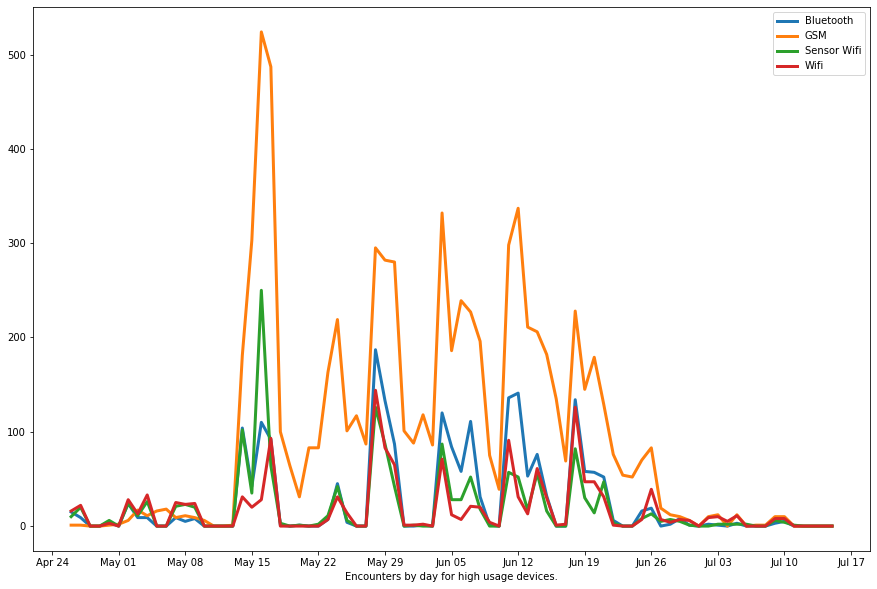

In [48]:
fig, ax = plt.subplots()
ax.plot(ground_truth_daily_all_df.index, ground_truth_daily_all_df['bluetooth'].values)
ax.plot(ground_truth_daily_all_df.index, ground_truth_daily_all_df['gsm'].values)
ax.plot(ground_truth_daily_all_df.index, ground_truth_daily_all_df['sensor'].values)
ax.plot(ground_truth_daily_all_df.index, ground_truth_daily_all_df['wifi'].values)
#ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.legend(['Bluetooth', 'GSM', 'Sensor Wifi', 'Wifi'])
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_xlabel('Encounters by day for high usage devices.')

fig.savefig(os.path.join(result_path, 'encounters_daily_all_comparison_line_overlaid.pdf'), format="pdf", bbox_inches="tight")
plt.show()

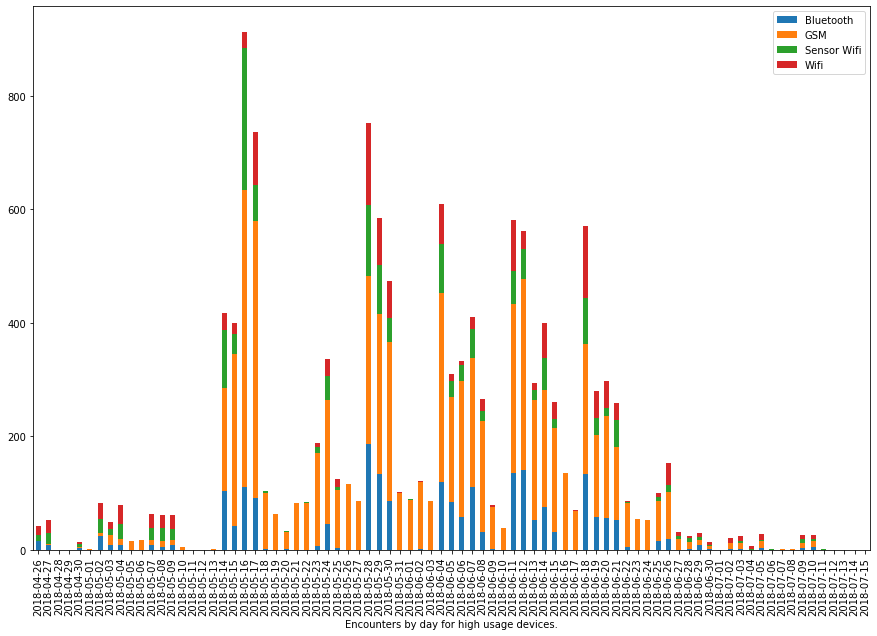

In [50]:
ax = ground_truth_daily_all_df.plot(kind='bar', stacked=True)
fig = ax.get_figure()
ax.legend(['Bluetooth', 'GSM', 'Sensor Wifi', 'Wifi'])
ax.set_xticklabels([pd.datetime.strftime(d,'%Y-%m-%d') for d in ground_truth_daily_all_df.index])
ax.set_xlabel('Encounters by day for high usage devices.')

fig.savefig(os.path.join(result_path, 'encounters_daily_all_comparison_bar_stacked.pdf'), format="pdf", bbox_inches="tight")
plt.show()

# 5 Dynamic Time Warping

The following sensors will be compared using DTW:
- accelerometer (5 seconds between records)
- barometer (10 seconds between records)
- magnetometer (0.15 seconds between records)

We use fastdtw, which promises to find at least near-optimal results, but in linear time, as opposed to the quadratic runtime for classic DTW.

Convert the timestamp to seconds $(\text{timestamp}\cdot10^{-9})$ or milliseconds $(\text{timestamp}\cdot10^{-6})$ (and ignore a shift of $2$ hours, which is probably due to daylight savings time and not being in GMT timezone).

In [19]:
dtw_accelerometer_all_df = data_accelerometer[data_accelerometer['device_id'].isin(devices_all_usage)][[
    'timestamp', 
    'double_values_0', 
    'double_values_1', 
    'double_values_2',
    'device_id'
]]
dtw_accelerometer_all_df['unixtime'] = (dtw_accelerometer_all_df.timestamp.astype(int) / 1e9)
dtw_accelerometer_all = dtw_accelerometer_all_df[[
    'double_values_0','double_values_1','double_values_2','unixtime','device_id'
]].values

In [20]:
dtw_barometer_all_df = data_barometer[data_barometer['device_id'].isin(devices_all_usage)][[
    'timestamp', 
    'double_values_0',
    'device_id'
]]
dtw_barometer_all_df['unixtime'] = (dtw_barometer_all_df.timestamp.astype(int) / 1e9)
dtw_barometer_all = dtw_barometer_all_df[[
    'double_values_0','unixtime','device_id'
]].values

In [21]:
dtw_magnetometer_all_df = data_magnetometer[data_magnetometer['device_id'].isin(devices_all_usage)][[
    'timestamp', 
    'double_values_0', 
    'double_values_1', 
    'double_values_2',
    'device_id'
]]
dtw_magnetometer_all_df['unixtime'] = (dtw_magnetometer_all_df.timestamp.astype(int) / 1e9)
dtw_magnetometer_all = dtw_magnetometer_all_df[[
    'double_values_0','double_values_1','double_values_2','unixtime','device_id'
]].values

**DTW**
- fastdtw(x, y, dist=dist.euclidean)
- x = dfx.values, y = dfy.values

**DTW with raw data**
- x, y

**DTW with normalized data**
- x - np.mean(x, axis=0), y - np.mean(y, axis=0)
- (x - np.mean(x, axis=0))/abs(x.max()-x.min()), (y - np.mean(y, axis=0))/abs(y.max()-y.min())

**Features for each category**,
- 1 minute blocks,
- whole 10 minute timespan,
- maximum distance,
- minimum distance,
- median distance

In [31]:
def dtw_dist(x,y):
    try:
        if x.size == 0 or y.size == 0:
            return np.nan
        return dtw.distance_fast(x.flatten(),y.flatten())
    except:
        return np.nan
    
def dtw_centered(x,y):
    try:
        if x.size == 0 or y.size == 0:
            return np.nan
        x_c = x - x.mean(axis=0)
        y_c = y - y.mean(axis=0)
        return dtw.distance_fast(x_c.flatten(),y_c.flatten())
    except:
        return np.nan

def dtw_normalized(x,y):
    try:
        if x.size == 0 or y.size == 0:
            return np.nan
        x_norm = abs(x.max(axis=0) - x.min(axis=0))
        y_norm = abs(y.max(axis=0) - y.min(axis=0))
        x_norm[x_norm == 0] = 1
        y_norm[y_norm == 0] = 1
        x_n = (x - x.mean(axis=0))/x_norm
        y_n = (y - y.mean(axis=0))/y_norm
        return dtw.distance_fast(x_n.flatten(),y_n.flatten())
    except:
        return np.nan

In [3]:
x1 = np.array([[1.,15.],[2.,16.],[3.,17.],[4.,18.],[5.,19.]])
x2 = np.array([[2.,2.],[3.,3.],[4.,4.]])
x3 = np.array([[2.,3.],[3.,4.],[4.,5.]])
x4 = np.array([])

print('--- different length arrays ---')
print('DTW: ', dtw_dist(x1,x2))
print('Centered DTW: ', dtw_centered(x1,x2))
print('Normalized DTW:', dtw_normalized(x1,x2))
print('\n------- shifted arrays --------')
print('DTW: ', dtw_dist(x2,x3))
print('Centered DTW: ', dtw_centered(x2,x3))
print('Normalized DTW:', dtw_normalized(x2,x3))
print('\n------- one array empty -------')
print('DTW: ', dtw_dist(x1,x4))
print('Centered DTW: ', dtw_centered(x1,x4))
print('Normalized DTW:', dtw_normalized(x1,x4))

--- different length arrays ---
DTW:  29.512709126747414
Centered DTW:  2.0
Normalized DTW: 0.5

------- shifted arrays --------
DTW:  1.0
Centered DTW:  0.0
Normalized DTW: 0.0

------- one array empty -------
DTW:  nan
Centered DTW:  nan
Normalized DTW: nan


In [4]:
def dtw_step(x,y,mode):
    if mode == 'raw':
        return dtw_dist(x,y)
    if mode == 'centered':
        return dtw_centered(x,y)
    if mode == 'normalized':
        return dtw_normalized(x,y)

In [5]:
x1 = np.array([[1.,15.],[2.,16.],[3.,17.],[4.,18.],[5.,19.]])
x2 = np.array([[2.,2.],[3.,3.],[4.,4.]])
x3 = np.array([[2.,3.],[3.,4.],[4.,5.]])
x4 = np.array([])

print('--- different length arrays ---')
print('DTW: ', dtw_step(x1,x2,'raw'))
print('Centered DTW: ', dtw_step(x1,x2,'centered'))
print('Normalized DTW:', dtw_step(x1,x2,'normalized'))
print('\n------- shifted arrays --------')
print('DTW: ', dtw_step(x2,x3,'raw'))
print('Centered DTW: ', dtw_step(x2,x3,'centered'))
print('Normalized DTW:', dtw_step(x2,x3,'normalized'))
print('\n------- one array empty -------')
print('DTW: ', dtw_step(x1,x4,'raw'))
print('Centered DTW: ', dtw_step(x1,x4,'centered'))
print('Normalized DTW:', dtw_step(x1,x4,'normalized'))

--- different length arrays ---
DTW:  29.512709126747414
Centered DTW:  2.0
Normalized DTW: 0.5

------- shifted arrays --------
DTW:  1.0
Centered DTW:  0.0
Normalized DTW: 0.0

------- one array empty -------
DTW:  nan
Centered DTW:  nan
Normalized DTW: nan


In [6]:
def dtw_ministep(x,y,mode,start,end,ministep):
    if x.size == 0 or y.size == 0:
        return np.array([np.nan])
    distances = np.empty((int)((end-start)/ministep))
    for i in range(len(distances)):
        x_i = x[(x[:,-1]>=start+i*ministep) & (x[:,-1]<=start+(i+1)*ministep)]
        y_i = y[(y[:,-1]>=start+i*ministep) & (y[:,-1]<=start+(i+1)*ministep)]
        if mode == 'raw':
            distances[i] = dtw_dist(x_i,y_i)
        if mode == 'centered':
            distances[i] = dtw_centered(x_i,y_i)
        if mode == 'normalized':
            distances[i] = dtw_normalized(x_i,y_i)
    return distances

In [9]:
x1 = np.array([[15.,1.], [16.,2.], [17.,3.], [18.,4.], [19.,5.], [15.,6.], [16.,7.], [17.,8.], [18.,9.], [19.,10.]])
x2 = np.array([[2.,2.], [3.,3], [4,4], [2,7], [3,8], [4,9.]])
x3 = np.array([[3.,2.], [4.,3], [5,4], [4,7], [5,8], [6,9.]])
x4 = np.array([])

print('--- different length arrays ---')
print('DTW: ', dtw_ministep(x1,x2,'raw',0,10,5))
print('Centered DTW: ', dtw_ministep(x1,x2,'centered',0,10,5))
print('Normalized DTW:', dtw_ministep(x1,x2,'normalized',0,10,5))
print('\n------- shifted arrays --------')
print('DTW: ', dtw_ministep(x2,x3,'raw',0,10,5))
print('Centered DTW: ', dtw_ministep(x2,x3,'centered',0,10,5))
print('Normalized DTW:', dtw_ministep(x2,x3,'normalized',0,10,5))
print('\n------- one array empty -------')
print('DTW: ', dtw_ministep(x1,x4,'raw',0,10,5))
print('Centered DTW: ', dtw_ministep(x1,x4,'centered',0,10,5))
print('Normalized DTW:', dtw_ministep(x1,x4,'normalized',0,10,5))

--- different length arrays ---
DTW:  [30.29851482 25.49509757]
Centered DTW:  [2.         3.89444048]
Normalized DTW: [0.5       1.0082989]

------- shifted arrays --------
DTW:  [1.73205081 3.46410162]
Centered DTW:  [0. 0.]
Normalized DTW: [0. 0.]

------- one array empty -------
DTW:  [nan]
Centered DTW:  [nan]
Normalized DTW: [nan]


In [10]:
dtw_sensors = ['accelerometer',
               'barometer',
               'magnetometer']
dtw_modes = ['raw',
            'centered',
            'normalized']
dtw_features = ['total',
                'min',
                'max',
                'median']
dtw_ministepsize = 60

# 6. Do the Modelling

In [51]:
print('--- all devices ---')
print(data_accelerometer.device_id.value_counts())
print('\n--- selected devices ---')
print(data_accelerometer[data_accelerometer.device_id.isin(devices_all_usage)].device_id.value_counts())

--- all devices ---
ad4ccb10-837f-42d3-a17e-5498cbbbecb7    92607834
49cdb769-2ef6-4111-a405-85d7c1f6a585    83106400
24b4fbdb-9742-4737-87c6-054bb9fbd114    56669888
3dc6770c-ce88-406b-a53b-fa544d7bbb64    44827150
7a52f62b-b528-40b3-864b-1ae7eed1e189    40260550
6b856387-0749-47cc-a24a-b9703f281b4f    36994500
92369119-68fe-436d-8ca8-e7d03d903661    28697752
b212c0fd-6209-43e8-a2da-d98f31b807dd    24630441
497e9c46-de36-4867-9bf7-404ab9a6adcd    22055610
72c1cc9e-ac9e-4409-aa6e-4e800cef7305    21390420
d78103e4-f949-4a48-b145-1b6bac03f7db    20839500
39c589bc-201f-449f-b841-7c9c2b99aa76    20478526
4e7801df-ed93-43fa-9246-7172d0183f23    15780000
5d5561d6-3895-4333-b279-8f32a6676946    13521250
becac23f-7256-4bc0-a435-08d9eda001ba    12593050
4722aba9-f779-4f98-8587-f6200f877428    12137000
1521332e-33e7-43d9-a715-9a655bcb4bc7    11770000
e003fc12-ace7-41ee-b7f6-9dc1b5c5adfd    10952000
68ea945e-33eb-44ea-82f9-7ace16ac0d77    10093266
210f35f4-4770-4b91-87b6-8cdf01300ad7     9265250


In [48]:
print('--- all devices ---')
print(data_barometer.device_id.value_counts())
print('\n--- selected devices ---')
print(data_barometer[data_barometer.device_id.isin(devices_all_usage)].device_id.value_counts())

--- all devices ---
b212c0fd-6209-43e8-a2da-d98f31b807dd    935256
8cbb4f59-2635-4ac7-b81a-138b4f0f085e     44943
5b108926-9f88-426b-8c69-9804642333d9     21161
6e05ff54-0410-4d17-8010-3cb143f4b2b3     20175
2e7e1cd4-a515-49ec-a3fe-a914b2138666     17632
11494b9c-17a1-41b5-8789-fb20c9b4f1b3     16271
6db4d30d-da5f-489d-a697-311c2c36804d     15662
ed07588c-3997-4cae-be42-b160a00c8bbd     14995
959da06b-1902-4aab-8ea4-62ee2db7b6e6     14975
5ab6e24e-06bd-4482-9de1-8435f22afb14     14509
0fd9837d-07f1-42df-acb9-4aa19f506d21     14168
f534fda2-c5f8-49d9-b6b8-746da1e34e5f     14134
6adbc0bc-da54-4d89-86b2-a801a5f748ff     13619
e890336f-56b9-4940-8554-56697c146e74     12491
2fae703d-b016-4a89-8f2e-de8808379d1e     12036
7dc4df39-481f-42e5-afb7-5652418c3c28      9649
27a047b0-fd49-42ac-a834-1bcef149ccb7      8909
b79099f2-bf02-483e-93c5-2c9a620ef2bd      8871
ede13e36-fbeb-4d29-b0c7-015609a5f2ee      8735
0836381c-48b0-43d9-9cf8-3273cbc8aecf      7810
1a1719b0-2a14-40f7-9c7d-4f389f1d4df5    

In [52]:
print('--- all devices ---')
print(data_magnetometer.device_id.value_counts())
print('\n--- selected devices ---')
print(data_magnetometer[data_magnetometer.device_id.isin(devices_all_usage)].device_id.value_counts())

--- all devices ---
39c589bc-201f-449f-b841-7c9c2b99aa76    58730000
4e7801df-ed93-43fa-9246-7172d0183f23    33385750
b212c0fd-6209-43e8-a2da-d98f31b807dd    25828000
24b4fbdb-9742-4737-87c6-054bb9fbd114    24791750
3dc6770c-ce88-406b-a53b-fa544d7bbb64    19497480
92369119-68fe-436d-8ca8-e7d03d903661    17104575
7a52f62b-b528-40b3-864b-1ae7eed1e189    14491931
1521332e-33e7-43d9-a715-9a655bcb4bc7    13217000
becac23f-7256-4bc0-a435-08d9eda001ba    11771750
c8618228-df68-4811-9507-ffb7383de24d    11130000
49cdb769-2ef6-4111-a405-85d7c1f6a585    10536250
4420c96c-c6d8-4528-bd2e-5d318b5c0a0d    10443691
210f35f4-4770-4b91-87b6-8cdf01300ad7     6109250
ad4ccb10-837f-42d3-a17e-5498cbbbecb7     5705040
72c1cc9e-ac9e-4409-aa6e-4e800cef7305     5252500
aaf1ecc4-fba4-42ac-80b6-0c7b2c8a7735     4901913
82d3d81c-36bf-44ce-8cb7-3be2dea6fb28     4600500
6b856387-0749-47cc-a24a-b9703f281b4f     4544891
4722aba9-f779-4f98-8587-f6200f877428     4455993
3bbcc834-7c27-46b4-aa56-51267ab6e283     3543253


## 6.1 Compute Encounters

Not computing encounters for every 10 min block in the data, but several candidate days we know had many encounters.
For every day, we focus on the time between 8:00 AM and 6:00 PM, as this showed to be the time most encounters took place in days we investagted more closely before.

In [35]:
experiment_days = [
    ('2018-05-17 08:00:00', '2018-05-17 18:00:00'),
    ('2018-05-24 08:00:00', '2018-05-24 18:00:00'),
    ('2018-05-28 08:00:00', '2018-05-28 18:00:00'),
    ('2018-05-29 08:00:00', '2018-05-29 18:00:00'),
    ('2018-05-30 08:00:00', '2018-05-30 18:00:00'),
    ('2018-06-04 08:00:00', '2018-06-04 18:00:00'),
    ('2018-06-11 08:00:00', '2018-06-11 18:00:00'),
    ('2018-06-12 08:00:00', '2018-06-12 18:00:00'),
    ('2018-06-14 08:00:00', '2018-06-14 18:00:00'),
    ('2018-06-18 08:00:00', '2018-06-18 18:00:00'),
    ('2018-06-19 08:00:00', '2018-06-19 18:00:00'),
    ('2018-06-20 08:00:00', '2018-06-10 18:00:00'),
    ('2018-06-21 08:00:00', '2018-06-21 18:00:00'),
]

In [36]:
experiment_freq = '10min'

In [37]:
experiment_steps = [
    pd.date_range(pd.datetime.strptime(day[0], '%Y-%m-%d %H:%M:%S'),
                  pd.datetime.strptime(day[1], '%Y-%m-%d %H:%M:%S'),
                  freq=experiment_freq)
    for day in experiment_days
]

In [39]:
experiment_dic = experimentDic(devices_all_usage, experiment_steps, 'BLE', ['groundtruth'], [])

Our experiment will use the BLE encounters as groundtruth, and features computed using the records of the Wifi sensor, accelerometer, barometer and magnetometer. (Barometer likely will not be included in final model, as there really are not many recordings.)

In [291]:
def computeEncounterDic(experiment_dic, devices, experiment_steps, sensor, sensor_id, data):
    for device in range(len(devices)-1):
        log('[GT ' + sensor + ']\t[' + str(device+1).zfill(2) + ']\t Device ' \
        + str(device+1).zfill(2) + ' of ' + str(len(devices)).zfill(2))

        device1 = devices[device]
        for d in range(len(devices)-1-device):
            device2 = devices[device+1+d]
            df_devices = data[data.device_id.isin([device1, device2])]
            log('[GT ' + sensor + ']\t[' + str(device+1).zfill(2) + ']\t[' + str(d+1).zfill(2) + \
            '/' + str(len(devices)-device-1).zfill(2) + '] Encounters for ' + device1 + ' --> ' + device2 + '.')

            i = 1
            for day in experiment_steps:
                for step in range(len(day) - 1):
                    step_start = day[step]
                    step_end = day[step+1]
                    df_step = df_devices[(df_devices['timestamp'] >= step_start) & (df_devices['timestamp'] <= step_end)]
                    key = device1 + '|' + device2 + '|' + str(step_start) + '|' + str(step_end)
                    experiment_dic[key]['encounter_' + sensor] = get_encounter(
                        device1, 
                        device2, 
                        df_step, 
                        sensor_id, 
                        step_start, 
                        step_end, 
                        20)
                log('[GT ' + sensor + ']\t[' + str(device+1).zfill(2) + ']\t[' + str(d+1).zfill(2) + \
                    '/' + str(len(devices)-device-1).zfill(2) + '] Computed encounters for day ' \
                    + str(i).zfill(2) + ' of ' + str(len(experiment_steps)).zfill(2) + '.')
                i += 1

    log('[GT ' + sensor + '] Encounters computed.')

In [ ]:
computeEncounterDic(experiment_dic, devices_all_usage, experiment_steps, 'BLE', 'bt_address', data_bluetooth_all)
encounters_ble = pd.DataFrame.from_dict(experiment_dic, orient='index')
encounters_ble.to_parquet(os.path.join(experiment_path,'experiment_encounters_ble'))

In [90]:
encounters_ble.encounter_BLE.value_counts()

0    560154
1      1446
Name: encounter_BLE, dtype: int64

## 6.2 Create Datasets

In [81]:
encounters_ble_1 = encounters_ble[encounters_ble.encounter_BLE == 1]
encounters_ble_0 = encounters_ble[encounters_ble.encounter_BLE == 0]

print('Encounters:', encounters_ble_1.shape[0])
print('Nonencounters:', encounters_ble_0.shape[0])

Encounters: 1446
Nonencounters: 560154


We create three datasets, with different ratios of encounters to nonencounters:
- 30:70
- 40:60
- 50:50

In [91]:
experiment_3070 = pd.DataFrame.append(
    encounters_ble_1,
    encounters_ble_0.sample(int(encounters_ble_1.shape[0]*2.3), random_state=RSEED)
)

experiment_3070.to_parquet(os.path.join(experiment_path,'experiment_encounters_3070'))

print('Encounters:', experiment_3070[experiment_3070.encounter_BLE == 1].shape[0])
print('Nonencounters:', experiment_3070[experiment_3070.encounter_BLE == 0].shape[0])

Encounters: 1446
Nonencounters: 3325


In [92]:
experiment_4060 = pd.DataFrame.append(
    encounters_ble_1,
    encounters_ble_0.sample(int(encounters_ble_1.shape[0]*1.5), random_state=RSEED)
)

experiment_4060.to_parquet(os.path.join(experiment_path,'experiment_encounters_4060'))

print('Encounters:', experiment_4060[experiment_4060.encounter_BLE == 1].shape[0])
print('Nonencounters:', experiment_4060[experiment_4060.encounter_BLE == 0].shape[0])

Encounters: 1446
Nonencounters: 2169


In [93]:
experiment_5050 = pd.DataFrame.append(
    encounters_ble_1,
    encounters_ble_0.sample(int(encounters_ble_1.shape[0]), random_state=RSEED)
)

experiment_5050.to_parquet(os.path.join(experiment_path,'experiment_encounters_5050'))

print('Encounters:', experiment_5050[experiment_5050.encounter_BLE == 1].shape[0])
print('Nonencounters:', experiment_5050[experiment_5050.encounter_BLE == 0].shape[0])

Encounters: 1446
Nonencounters: 1446


In [65]:
experiment_3070 = pd.read_parquet(os.path.join(experiment_path,'experiment_encounters_3070'))
experiment_4060 = pd.read_parquet(os.path.join(experiment_path,'experiment_encounters_4060'))
experiment_5050 = pd.read_parquet(os.path.join(experiment_path,'experiment_encounters_5050'))

## 6.3 Compute Features

In [66]:
experiment_entries = experiment_3070[['key','device_1','device_2','starttime','endtime']]

### 6.3.1 Original Features

In [16]:
def original_features(entries,sensor,sensor_id,sensor_strength,data):
    experiment = {}
    i = 1
    for entry in entries.values:
        key = entry[0]
        device1 = entry[1]
        device2 = entry[2]
        step_start = entry[3]
        step_end = entry[4]
        
        df_step = data[(data.timestamp >= step_start) &
                       (data.timestamp <= step_end) &
                       (data.device_id.isin([device1,device2]))]
        
        experiment[key] = {}
        experiment[key]['encounter_' + sensor] = get_encounter(device1, device2, df_step, sensor_id, step_start, step_end, 180)
        experiment[key]['overlap_' + sensor] = overlap(device1, device2, df_step, sensor_id, step_start, step_end)
        experiment[key]['union_' + sensor] = union(device1, device2, df_step, sensor_id, step_start, step_end)
        experiment[key]['jaccard_' + sensor] = jaccard(device1, device2, df_step, sensor_id, step_start, step_end)
        experiment[key]['nonoverlap_' + sensor] = non_overlap(device1, device2, df_step, sensor_id, step_start, step_end)
        experiment[key]['spearman_' + sensor] = spearman(device1, device2, df_step, sensor_id, sensor_strength, step_start, step_end)
        experiment[key]['pearson_' + sensor] = pearson(device1, device2, df_step, sensor_id, sensor_strength, step_start, step_end)
        experiment[key]['manhattan_' + sensor] = manhattan(device1, device2, df_step, sensor_id, sensor_strength, step_start, step_end)
        experiment[key]['euclidean_' + sensor] = euclidean(device1, device2, df_step, sensor_id, sensor_strength, step_start, step_end)
        experiment[key]['topAP_' + sensor] = topAP(device1, device2, df_step, sensor_id, sensor_strength, step_start, step_end)
        experiment[key]['topAP6dB_' + sensor] = topAP6dB(device1, device2, df_step, sensor_id, sensor_strength, step_start, step_end)
        log('[' + sensor + ']\t[' + str(i).zfill(2) + ' of ' + str(entries.shape[0]) + ']\tOriginal non popularity features computed.')
        i += 1
    log('[' + sensor + ']\t Original non popularity features computed.')
    
    steps = entries[['starttime','endtime']].drop_duplicates().values
    pop_data = data[['timestamp',sensor_id,'device_id']]
    i = 1
    for step in steps:
        step_start = step[0]
        step_end = step[1]
        pop_aps = {}
        pop_dev = {}
        popularity_efficient(
            pop_aps,
            pop_dev,
            pop_data,
            sensor_id,
            step_start,
            step_end
            )
        for entry in entries.values:
            if (step_start == entry[3] and step_end == entry[4]):
                key = entry[0]
                device1 = entry[1]
                device2 = entry[2]
                experiment[key]['min_popularity_' + sensor] = min_popularity_efficient(device1,device2,pop_aps,pop_dev)
                experiment[key]['max_popularity_' + sensor] = max_popularity_efficient(device1,device2,pop_aps,pop_dev)
                experiment[key]['adamic_adar_' + sensor] = adamic_adar_efficient(device1,device2,pop_aps,pop_dev)
        log('[' + sensor + ']\t[' + str(i).zfill(2) + ' of ' + str(steps.shape[0]) + ']\tOriginal popularity features computed.')
        i += 1
    log('[' + sensor + ']\t Original popularity features computed.')
    
    df = pd.DataFrame.from_dict(experiment, orient='index')
    df.to_parquet(os.path.join(experiment_path,'experiment_originalfeatures'))
    log('[' + sensor + ']\t Original features exported as parquet.')

In [176]:
original_features(experiment_entries,'WIFI','bssid','rssi',data_wifi)

/u/home/starkc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
experiment_originalfeatures = pd.read_parquet(os.path.join(experiment_path,'experiment_originalfeatures'))

In [178]:
experiment_originalfeatures.describe()

encounter_WIFI  overlap_WIFI  union_WIFI  jaccard_WIFI  \
count        4771.000      4771.000    4771.000      3012.000   
mean            0.109         2.568      42.318         0.045   
std             0.312         9.197      59.115         0.136   
min             0.000         0.000       0.000         0.000   
25%             0.000         0.000       0.000         0.000   
50%             0.000         0.000      22.000         0.000   
75%             0.000         0.000      61.000         0.000   
max             1.000        83.000     532.000         1.000   

       nonoverlap_WIFI  spearman_WIFI  pearson_WIFI  manhattan_WIFI  \
count         4771.000        487.000       487.000         521.000   
mean            39.750          0.298         0.321           8.886   
std             55.910          0.547         0.591           5.231   
min              0.000         -1.000        -1.000           0.767   
25%              0.000         -0.108        -0.101           5.409   
50%             20.000          0.479         0.558           7.500   
75%             57.000          0.750         0.823          11.150   
max            532.000          1.000         1.000          36.286   

       euclidean_WIFI  topAP_WIFI  topAP6dB_WIFI  min_popularity_WIFI  \
count         521.000    4771.000       4771.000              521.000   
mean            3.050       0.032          0.109                2.499   
std             3.251       0.176          0.312                0.877   
min             0.265       0.000          0.000                2.000   
25%             1.288       0.000          0.000                2.000   
50%             2.000       0.000          0.000                2.000   
75%             3.640       0.000          0.000                3.000   
max            32.500       1.000          1.000                7.000   

       max_popularity_WIFI  adamic_adar_WIFI  
count              521.000          4771.000  
mean                 3.808             2.679  
std                  1.671             9.837  
min                  2.000             0.000  
25%                  3.000             0.000  
50%                  3.000             0.000  
75%                  5.000             0.000  
max                  9.000            91.799

### 6.3.2 DTW Features

In [17]:
def dtw_features_computation(comp_entries,comp_sensor,comp_modes,comp_data,dtw_ministepsize):
    log('[' + comp_sensor + ']\tDTW features computation started.')
    experiment = {}
    i = 1
    for entry in comp_entries.values:
        key = entry[0]
        device1 = entry[1]
        device2 = entry[2]
        step_start = np.datetime64(entry[3]).astype(int)/1e6
        step_end = np.datetime64(entry[4]).astype(int)/1e6
            
        dtw_step_x = comp_data[(comp_data[:,-1] == device1) &
                               (comp_data[:,-2] >= step_start) & 
                               (comp_data[:,-2] <= step_end)
                              ][:,:-1]
        dtw_step_y = comp_data[(comp_data[:,-1] == device2) &
                               (comp_data[:,-2] >= step_start) & 
                               (comp_data[:,-2] <= step_end)
                              ][:,:-1]
        experiment[key] = {}
        for mode in comp_modes:
                    total = dtw_step(dtw_step_x,dtw_step_y,mode)
                    experiment[key][mode + '_total_' + comp_sensor] = total
                    distances = dtw_ministep(dtw_step_x,dtw_step_y,mode,step_start,step_end,dtw_ministepsize)
                    experiment[key][mode + '_min_' + comp_sensor] = np.nanmin(distances)
                    experiment[key][mode + '_max_' + comp_sensor] = np.nanmax(distances)
                    experiment[key][mode + '_median_' + comp_sensor] = np.nanmedian(distances,axis=0)
        log('[' + comp_sensor + ']\t[' + str(i).zfill(4) + ' of ' + str(comp_entries.shape[0]) + ']\t DTW features computed.')
        i += 1
    log('[' + comp_sensor + ']\tDTW features computed.')
    
    df = pd.DataFrame.from_dict(experiment, orient='index')
    df.to_parquet(os.path.join(experiment_path,'experiment_dtwfeatures_' + comp_sensor))
    log('[' + comp_sensor + ']\tDTW features exported as parquet.')

In [40]:
proc = []

for sensor in dtw_sensors:
    if sensor == 'accelerometer':
        continue
        dtw_data = dtw_accelerometer_all
    if sensor == 'barometer':
        dtw_data = dtw_barometer_all
    if sensor == 'magnetometer':
        continue
        dtw_data = dtw_magnetometer_all
    p = Process(target=dtw_features_computation,
                args=[experiment_entries,
                      sensor,
                      dtw_modes,
                      dtw_data,
                      60])
    p.start()
    proc.append(p)

# wait for processes to finish
for p in proc:
    p.join()

/u/home/starkc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: All-NaN slice encountered
/u/home/starkc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/u/home/starkc/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [61]:
experiment_dtw_accelerometer = pd.read_parquet(os.path.join(experiment_path,'experiment_dtwfeatures_accelerometer_fastdtw'))
experiment_dtw_accelerometer.describe()

raw_total_accelerometer  raw_min_accelerometer  raw_max_accelerometer  \
count             1.050000e+02             105.000000           1.050000e+02   
mean              4.949514e+06           52425.728588           1.801547e+05   
std               6.498027e+06           95232.137770           2.361331e+05   
min               1.315485e+04             192.289444           2.122769e+03   
25%               5.122282e+05            7956.357455           2.370765e+04   
50%               1.666575e+06           15849.037271           9.260955e+04   
75%               6.741630e+06           29729.801530           2.373789e+05   
max               2.865593e+07          553658.719445           1.376965e+06   

       raw_median_accelerometer  centered_total_accelerometer  \
count                105.000000                  1.050000e+02   
mean              105618.159072                  4.678732e+06   
std               156187.316614                  6.341975e+06   
min                  809.675721                  7.687105e+03   
25%                12808.881555                  3.924956e+05   
50%                31169.872982                  1.620878e+06   
75%                93125.448441                  5.714449e+06   
max               739504.399763                  2.862902e+07   

       centered_min_accelerometer  centered_max_accelerometer  \
count                  105.000000                  105.000000   
mean                 34546.982173               118134.260257   
std                  58355.997538               154060.375054   
min                     25.210306                  919.674185   
25%                   3422.471378                16906.908946   
50%                  11288.002389                45291.255848   
75%                  25493.162265               185673.035241   
max                 267773.467326               702572.543465   

       centered_median_accelerometer  normalized_total_accelerometer  \
count                     105.000000                      105.000000   
mean                    69609.626476                    15629.684831   
std                    105486.563514                    23851.237497   
min                       123.905347                      488.155561   
25%                     10031.939686                     2516.506853   
50%                     20443.215907                     6024.109055   
75%                     89646.729277                    19813.941122   
max                    495113.321068                   176512.061169   

       normalized_min_accelerometer  normalized_max_accelerometer  \
count                    105.000000                    105.000000   
mean                    1070.601445                   3296.587211   
std                     1599.823481                   3917.240584   
min                       27.586817                     57.889837   
25%                      182.168871                    660.249457   
50%                      470.309108                   1493.142038   
75%                      920.778753                   5075.215893   
max                     7970.831055                  17713.505198   

       normalized_median_accelerometer  
count                       105.000000  
mean                       2002.719771  
std                        2720.671194  
min                          49.131901  
25%                         373.966173  
50%                         772.346432  
75%                        2206.564695  
max                       11096.868329

In [62]:
experiment_dtw_barometer = pd.read_parquet(os.path.join(experiment_path,'experiment_dtwfeatures_barometer_fastdtw'))
experiment_dtw_barometer.describe()

raw_total_barometer  raw_min_barometer  raw_max_barometer  \
count                  0.0                0.0                0.0   
mean                   NaN                NaN                NaN   
std                    NaN                NaN                NaN   
min                    NaN                NaN                NaN   
25%                    NaN                NaN                NaN   
50%                    NaN                NaN                NaN   
75%                    NaN                NaN                NaN   
max                    NaN                NaN                NaN   

       raw_median_barometer  centered_total_barometer  centered_min_barometer  \
count                   0.0                       0.0                     0.0   
mean                    NaN                       NaN                     NaN   
std                     NaN                       NaN                     NaN   
min                     NaN                       NaN                     NaN   
25%                     NaN                       NaN                     NaN   
50%                     NaN                       NaN                     NaN   
75%                     NaN                       NaN                     NaN   
max                     NaN                       NaN                     NaN   

       centered_max_barometer  centered_median_barometer  \
count                     0.0                        0.0   
mean                      NaN                        NaN   
std                       NaN                        NaN   
min                       NaN                        NaN   
25%                       NaN                        NaN   
50%                       NaN                        NaN   
75%                       NaN                        NaN   
max                       NaN                        NaN   

       normalized_total_barometer  normalized_min_barometer  \
count                         0.0                       0.0   
mean                          NaN                       NaN   
std                           NaN                       NaN   
min                           NaN                       NaN   
25%                           NaN                       NaN   
50%                           NaN                       NaN   
75%                           NaN                       NaN   
max                           NaN                       NaN   

       normalized_max_barometer  normalized_median_barometer  
count                       0.0                          0.0  
mean                        NaN                          NaN  
std                         NaN                          NaN  
min                         NaN                          NaN  
25%                         NaN                          NaN  
50%                         NaN                          NaN  
75%                         NaN                          NaN  
max                         NaN                          NaN

In [63]:
experiment_dtw_magnetometer = pd.read_parquet(os.path.join(experiment_path,'experiment_dtwfeatures_magnetometer_fastdtw'))
experiment_dtw_magnetometer.describe()

raw_total_magnetometer  raw_min_magnetometer  raw_max_magnetometer  \
count            5.170000e+02            515.000000          5.150000e+02   
mean             1.180355e+06          56634.162082          1.218727e+05   
std              2.819225e+06         140064.569893          2.871259e+05   
min              2.145548e+04            498.100132          2.074162e+03   
25%              1.250958e+05           5531.985365          1.347196e+04   
50%              2.118368e+05          10250.184739          2.383899e+04   
75%              4.950982e+05          21858.311799          5.334825e+04   
max              1.925996e+07         957043.877328          2.917022e+06   

       raw_median_magnetometer  centered_total_magnetometer  \
count             5.150000e+02                 5.170000e+02   
mean              8.759163e+04                 7.654363e+05   
std               2.147212e+05                 1.935075e+06   
min               2.063486e+03                 5.809642e+02   
25%               9.537556e+03                 7.252312e+04   
50%               1.709043e+04                 1.382677e+05   
75%               3.490829e+04                 3.499256e+05   
max               2.029152e+06                 1.427862e+07   

       centered_min_magnetometer  centered_max_magnetometer  \
count                 515.000000               5.150000e+02   
mean                 7020.898299               3.501654e+04   
std                 18299.326559               1.116959e+05   
min                     1.524000               6.192139e+01   
25%                   303.111338               2.372964e+03   
50%                  1130.130199               6.037228e+03   
75%                  3412.129331               1.620669e+04   
max                179117.373596               1.531007e+06   

       centered_median_magnetometer  normalized_total_magnetometer  \
count                    515.000000                     517.000000   
mean                   14223.838313                    3645.268297   
std                    38012.183388                    9486.244776   
min                       31.575408                     111.001586   
25%                     1011.039230                     478.352627   
50%                     2654.314932                     716.702529   
75%                     6882.949991                    1460.509844   
max                   304436.276764                   80482.408542   

       normalized_min_magnetometer  normalized_max_magnetometer  \
count                   515.000000                   515.000000   
mean                    293.882758                   556.918447   
std                     677.001277                  1273.951843   
min                       2.673684                    27.131953   
25%                      46.695288                    89.472482   
50%                      69.672042                   148.508936   
75%                     143.874965                   261.703466   
max                    4386.080120                  8804.588758   

       normalized_median_magnetometer  
count                      515.000000  
mean                       400.755281  
std                        894.029341  
min                         25.235400  
25%                         63.615586  
50%                        107.940789  
75%                        197.461329  
max                       5539.988014

## 6.4 Build Models

In [64]:
'''
df: dataframe containing all computed values
entries: dataframe containing entries we want to filter for

Filtering happening on index

returns: values of filtered entries
'''
def filter_experiment_mean(df, entries):
    values = df.merge(entries, left_index=True, right_index=True)\
                .filter([f for f in df.columns if 'encounter' not in f])\
                .values
    mean = np.nanmean(values, axis=0)
    nan = np.where(np.isnan(values))
    values[nan] = np.take(mean, nan[1])
    return values

def filter_experiment_max(df, entries):
    values = df.merge(entries, left_index=True, right_index=True)\
                .filter(df.columns)\
                .values
    mean = np.nanmean(values, axis=0)
    nan = np.where(np.isnan(values))
    values[nan] = np.finfo('float32').max
    return values

### 6.4.1 K-Fold Crossvalidation

In [58]:
def assess_experiment_default(distentries, disttext):
    print('\n------------------- Experiment ' + disttext + ' -------------------')
    labels = distentries.encounter_BLE.values
    features_wifi = filter_experiment_mean(experiment_originalfeatures, distentries)
    features_magnetometer = filter_experiment_max(experiment_dtw_magnetometer, distentries)
    features_combined = np.concatenate((features_wifi,features_magnetometer), axis=1)
    print('Labels:', labels.shape)
    print('Features Wifi:', features_wifi.shape)
    print('Features Magnetometer:', features_magnetometer.shape)
    print('Features All:', features_combined.shape)
    
    print('\n------------------- Random Forest -------------------')

    rates_wifi = k_fold_forest(
        X = features_wifi,
        y = labels,
        folds = 10,
        estimators = 100,
        plot_title = 'BLE encounters predicted using Wifi features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + '_forest_wifi.pdf'))

    rates_magnetometer = k_fold_forest(
        X = features_magnetometer,
        y = labels,
        folds = 10,
        estimators = 100,
        plot_title = 'BLE encounters predicted using magnetometer features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + '_forest_magnetometer.pdf'))

    rates_combined = k_fold_forest(
        X = features_combined,
        y = labels,
        folds = 10,
        estimators = 100,
        plot_title = 'BLE encounters predicted using DTW & Wifi features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + '_forest_combined.pdf'))

    rand_predict = np.random.randint(2, size=labels.shape)
    random_fpr, random_tpr, _ = roc_curve(labels, rand_predict)
    random_roc_auc = roc_auc_score(labels, rand_predict)
    rates_random = (random_fpr, random_tpr, random_roc_auc)
    print('----- random check -----')
    print(labels.shape)
    print(labels.sum())
    print(rand_predict.shape)
    print(rand_predict.sum())
    print('------------------------')
    
    # compare, wifi, dtw, both and coin flip
    fig, ax = plt.subplots()
    ax.plot(rates_wifi[0], 
            rates_wifi[1],
            marker = '^',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Wifi (area = %0.2f)' % np.nanmean(rates_wifi[2])
           )
    ax.plot(rates_magnetometer[0], 
            rates_magnetometer[1],
            marker = 's',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC DTW (area = %0.2f)' % np.nanmean(rates_magnetometer[2])
           )
    ax.plot(rates_combined[0], 
            rates_combined[1],
            marker = 'o',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Combined (area = %0.2f)' % np.nanmean(rates_combined[2])
           )
    ax.plot(rates_random[0], 
            rates_random[1],
            linestyle = '--',
            color = 'k',
            linewidth = 1,
            label='ROC Coin Toss (area = %0.2f)' % np.nanmean(rates_random[2])
           )
        
    #ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_ylim(0,1.05)
    ax.set_xlim(0,1)

    ax.set_title('BLE encounters predicted using Wifi, DTW features, or both.')
    ax.set_xlabel('False Positive Rate.')
    ax.set_ylabel('True Positive Rate.')
    ax.legend(loc="lower right")

    fig.savefig(
        os.path.join(result_path,'bigdata',disttext+'_forest_compare.pdf'),
        format="pdf",
        bbox_inches="tight")
    plt.show()
    
    print('\n------------------- Gradient Boost -------------------')
    rates_wifi_gradient = k_fold_boost(
        X = features_wifi,
        y = labels,
        folds = 10,
        estimators = 100,
        plot_title = 'BLE encounters predicted using Wifi features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + '_gradientboost_wifi.pdf'))
    
    rates_magnetometer_gradient = k_fold_boost(
        X = features_magnetometer,
        y = labels,
        folds = 10,
        estimators = 100,
        plot_title = 'BLE encounters predicted using magnetometer features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + '_gradientboost_magnetometer.pdf'))

    rates_combined_gradient = k_fold_boost(
        X = features_combined,
        y = labels,
        folds = 10,
        estimators = 100,
        plot_title = 'BLE encounters predicted using DTW & Wifi features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + '_gradientboost_combined.pdf'))
    
    # compare, wifi, dtw, both and coin flip
    fig, ax = plt.subplots()
    ax.plot(rates_wifi_gradient[0], 
            rates_wifi_gradient[1],
            marker = '^',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Wifi (area = %0.2f)' % np.nanmean(rates_wifi_gradient[2])
           )
    ax.plot(rates_magnetometer_gradient[0], 
            rates_magnetometer_gradient[1],
            marker = 's',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC DTW (area = %0.2f)' % np.nanmean(rates_magnetometer_gradient[2])
           )
    ax.plot(rates_combined_gradient[0], 
            rates_combined_gradient[1],
            marker = 'o',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Combined (area = %0.2f)' % np.nanmean(rates_combined_gradient[2])
           )
    ax.plot(rates_random[0], 
            rates_random[1],
            linestyle = '--',
            color = 'k',
            linewidth = 1,
            label='ROC Coin Toss (area = %0.2f)' % np.nanmean(rates_random[2])
           )
        
    ax.set_ylim(0,1.05)
    ax.set_xlim(0,1)

    ax.set_title('BLE encounters predicted using Wifi, DTW features, or both.')
    ax.set_xlabel('False Positive Rate.')
    ax.set_ylabel('True Positive Rate.')
    ax.legend(loc="lower right")

    fig.savefig(
        os.path.join(result_path,'bigdata',disttext+'_gradientboost_compare.pdf'),
        format="pdf",
        bbox_inches="tight")
    plt.show()
    
    print('\n------------------- Compare Models -------------------')
    fig, ax = plt.subplots()
    ax.plot(rates_wifi[0], 
            rates_wifi[1],
            marker = '^',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Wifi Random Forest (area = %0.2f)' % np.nanmean(rates_wifi[2])
           )
    ax.plot(rates_magnetometer[0], 
            rates_magnetometer[1],
            marker = 's',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC DTW Random Forest (area = %0.2f)' % np.nanmean(rates_magnetometer[2])
           )
    ax.plot(rates_combined[0], 
            rates_combined[1],
            marker = 'o',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Combined Random Forest (area = %0.2f)' % np.nanmean(rates_combined[2])
           )
    ax.plot(rates_wifi_gradient[0], 
            rates_wifi_gradient[1],
            marker = '^',
            markevery = 0.1,
            color = 'r',
            linewidth = 1.5,
            label='ROC Wifi Gradient Boosting (area = %0.2f)' % np.nanmean(rates_wifi_gradient[2])
           )
    ax.plot(rates_magnetometer_gradient[0], 
            rates_magnetometer_gradient[1],
            marker = 's',
            markevery = 0.1,
            color = 'r',
            linewidth = 1.5,
            label='ROC DTW Gradient Boosting (area = %0.2f)' % np.nanmean(rates_magnetometer_gradient[2])
           )
    ax.plot(rates_combined_gradient[0], 
            rates_combined_gradient[1],
            marker = 'o',
            markevery = 0.1,
            color = 'r',
            linewidth = 1.5,
            label='ROC Combined Gradient Boosting (area = %0.2f)' % np.nanmean(rates_combined_gradient[2])
           )
    ax.plot(rates_random[0], 
            rates_random[1],
            linestyle = '--',
            color = 'k',
            linewidth = 1,
            label='ROC Coin Toss (area = %0.2f)' % np.nanmean(rates_random[2])
           )
        
    ax.set_ylim(0,1.05)
    ax.set_xlim(0,1)

    ax.set_title('BLE encounters predicted using Wifi, DTW features, or both.')
    ax.set_xlabel('False Positive Rate.')
    ax.set_ylabel('True Positive Rate.')
    ax.legend(loc="lower right")

    fig.savefig(
        os.path.join(result_path,'bigdata',disttext+'_forest_gradientboost_compare.pdf'),
        format="pdf",
        bbox_inches="tight")
    plt.show()
    
    return (rates_wifi, rates_magnetometer, rates_combined, 
            rates_wifi_gradient, rates_magnetometer_gradient, rates_combined_gradient, 
            rates_random)


------------------- Experiment 3070 -------------------
Labels: (4771,)
Features Wifi: (4771, 13)
Features Magnetometer: (4771, 12)
Features All: (4771, 25)

------------------- Random Forest -------------------
--- Statistics ---
Mean accuracy: 0.8000368411357595
Mean recall: 0.511808743838973
Mean precision: 0.7495717771390462
Mean F1: 0.6073620558291719
Mean ROC-AUC: 0.7186915165358977


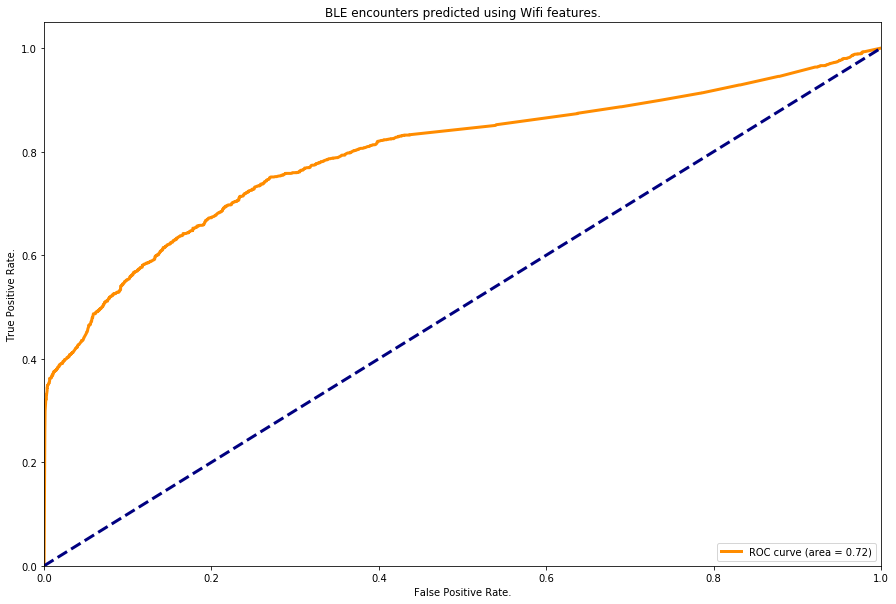

--- Statistics ---
Mean accuracy: 0.7296141329614133
Mean recall: 0.16964378713560405
Mean precision: 0.7387019797437717
Mean F1: 0.27485460067856354
Mean ROC-AUC: 0.5712923691043035


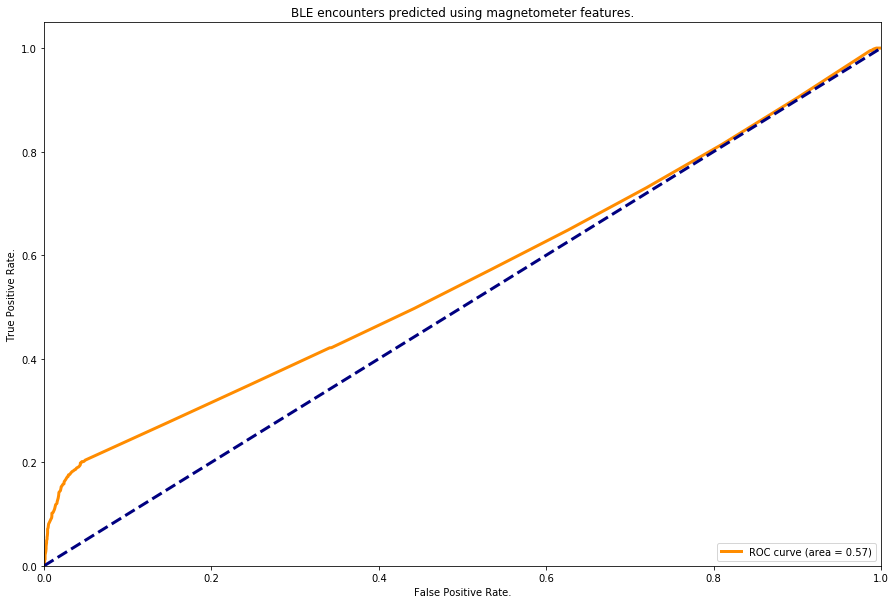

--- Statistics ---
Mean accuracy: 0.8191117777602344
Mean recall: 0.5459517962026962
Mean precision: 0.7950051190040744
Mean F1: 0.6462661739147352
Mean ROC-AUC: 0.7420169277170557


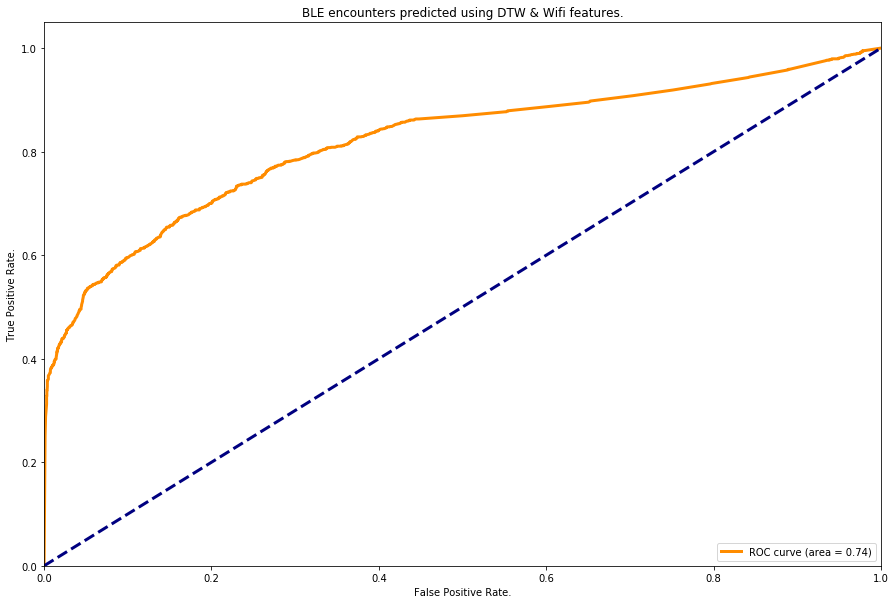

----- random check -----
(4771,)
1446
(4771,)
2352
------------------------


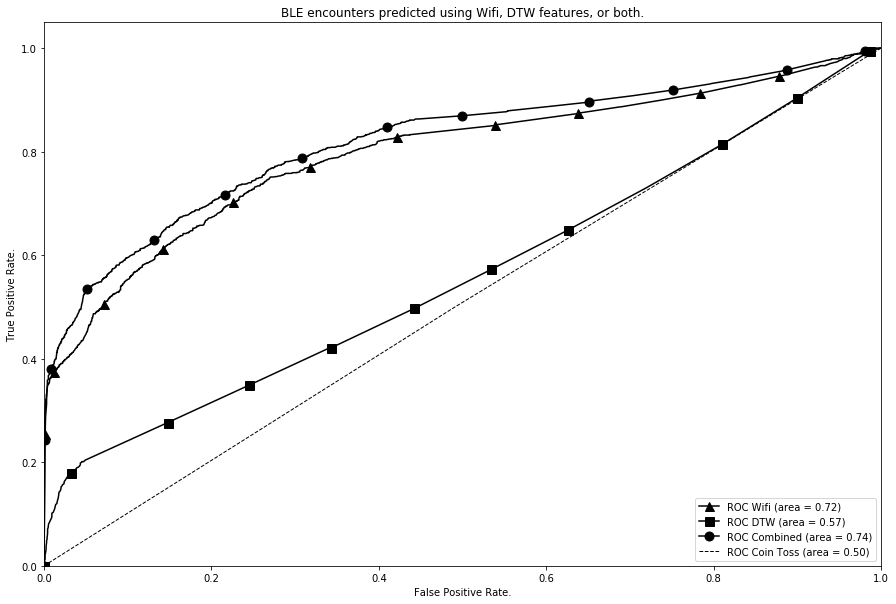


------------------- Gradient Boost -------------------
--- Statistics ---
Mean accuracy: 0.7987859968597316
Mean recall: 0.417235455005928
Mean precision: 0.8419212761906193
Mean F1: 0.5550754136442744
Mean ROC-AUC: 0.6910348984684429


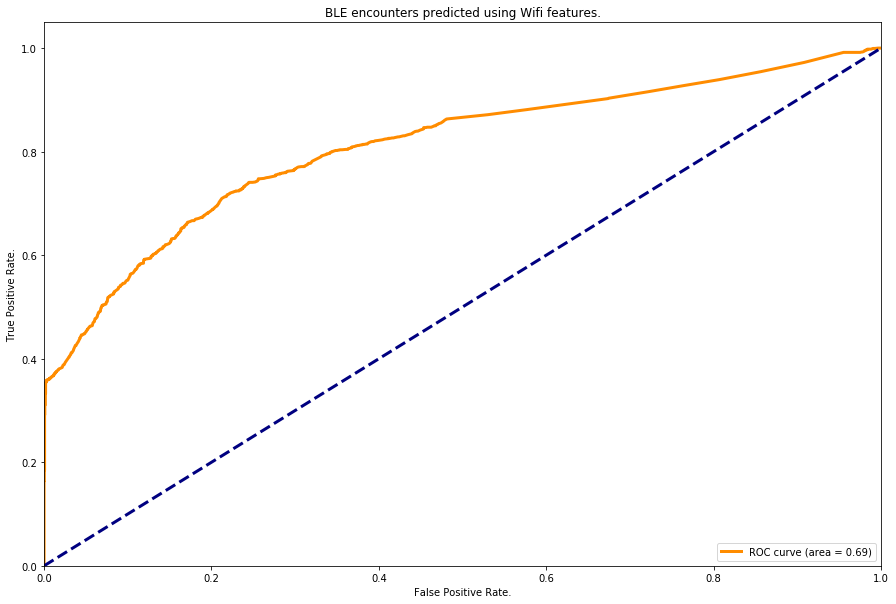

--- Statistics ---
Mean accuracy: 0.725423015183811
Mean recall: 0.16228637869988077
Mean precision: 0.7135775189130052
Mean F1: 0.26225731478228453
Mean ROC-AUC: 0.5664105043133099


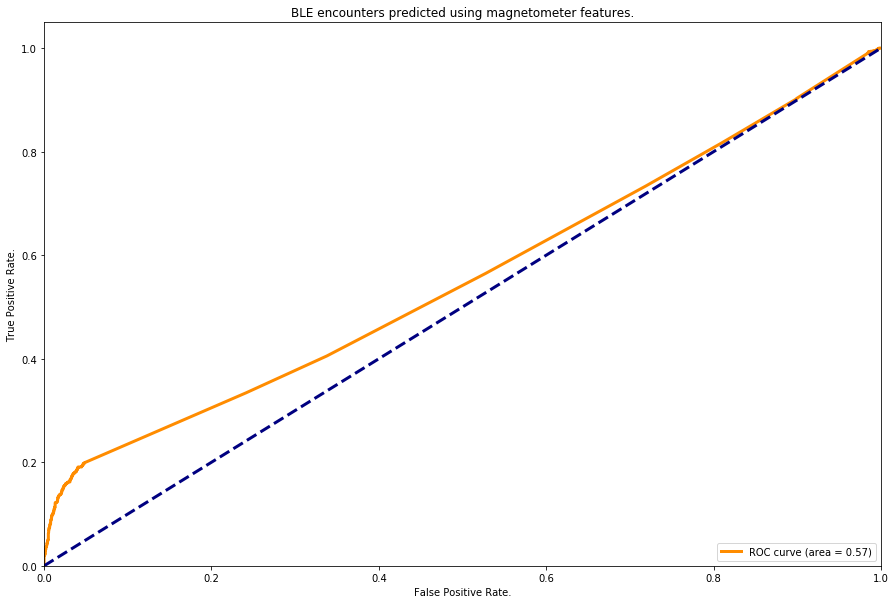

--- Statistics ---
Mean accuracy: 0.8098979851407421
Mean recall: 0.43602437998018884
Mean precision: 0.8774631564120995
Mean F1: 0.5801777383269467
Mean ROC-AUC: 0.7046348108873582


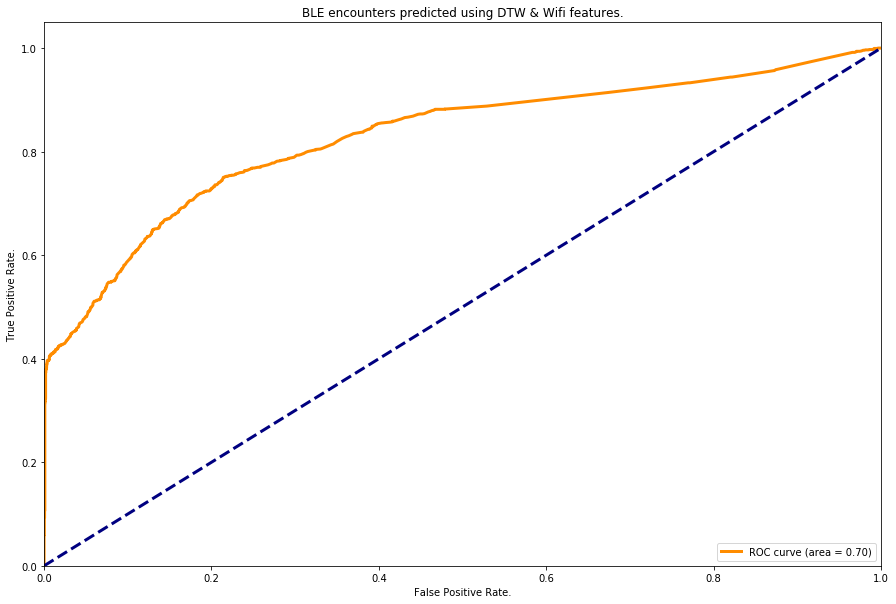

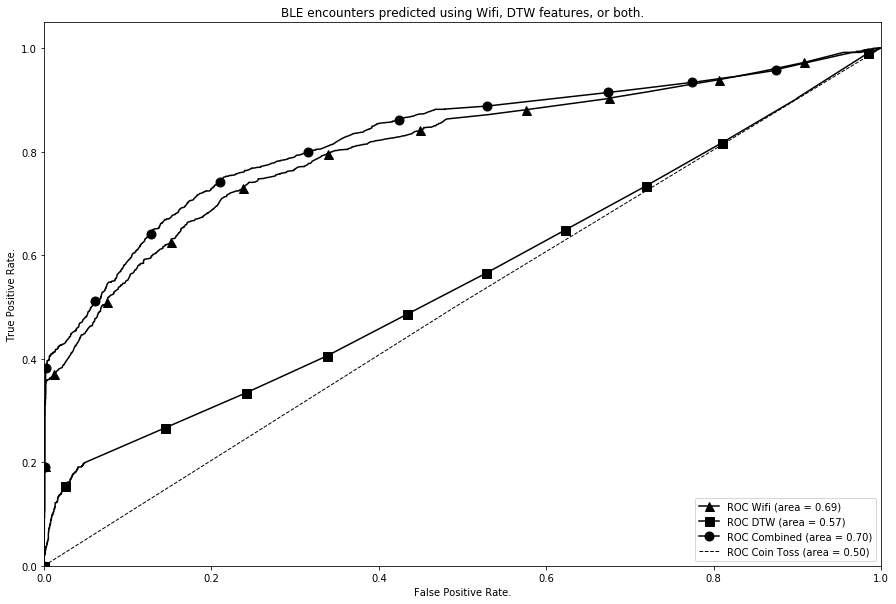


------------------- Compare Models -------------------


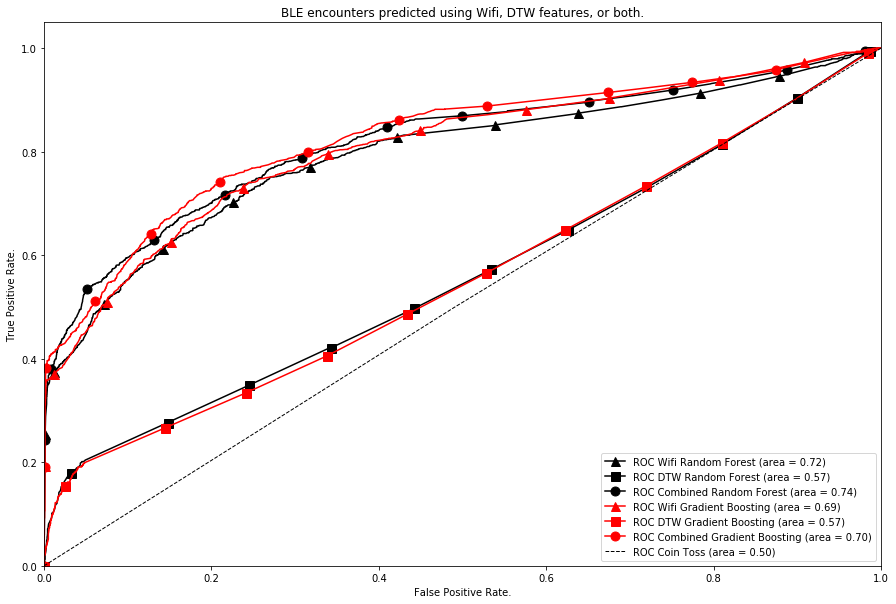

In [229]:
rates_3070 = assess_experiment_default(experiment_3070, '3070')


------------------- Experiment 4060 -------------------
Labels: (3615,)
Features Wifi: (3615, 13)
Features Magnetometer: (3615, 12)
Features All: (3615, 25)

------------------- Random Forest -------------------
--- Statistics ---
Mean accuracy: 0.7518594756737731
Mean recall: 0.5793234849898186
Mean precision: 0.7472630724192089
Mean F1: 0.6502215278985592
Mean ROC-AUC: 0.7238000320403957


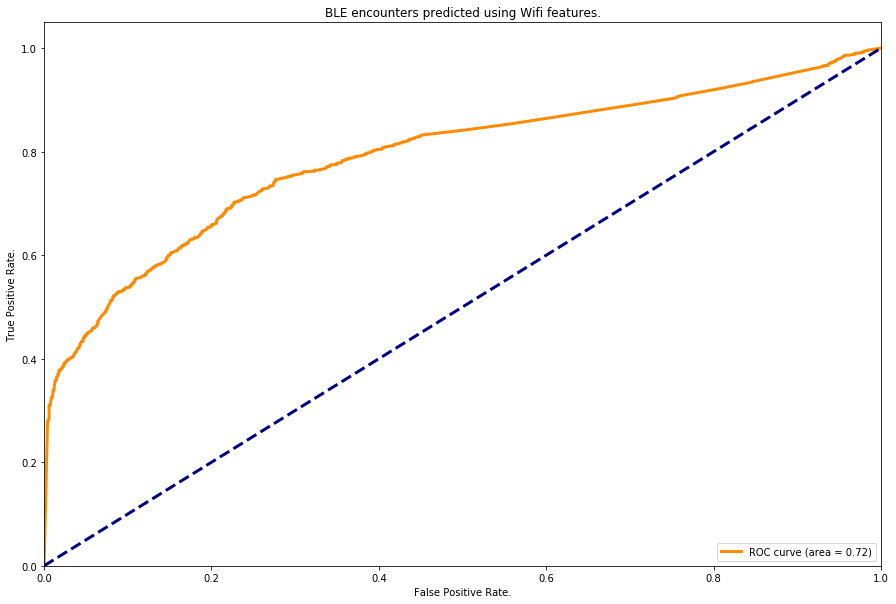

--- Statistics ---
Mean accuracy: 0.6528351264902589
Mean recall: 0.1852451247342677
Mean precision: 0.7785316907329929
Mean F1: 0.2990095702777504
Mean ROC-AUC: 0.5748946764036459


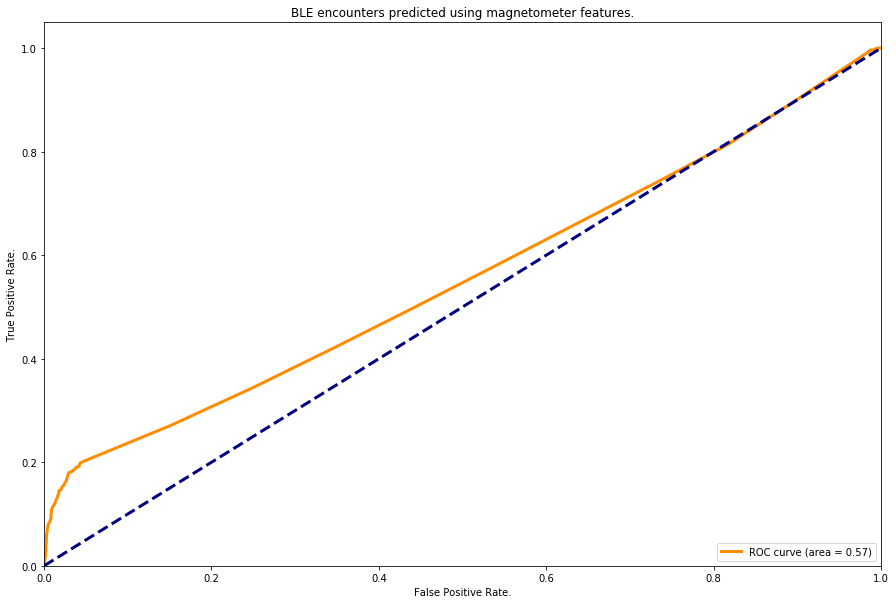

--- Statistics ---
Mean accuracy: 0.767641297194717
Mean recall: 0.6067489595249869
Mean precision: 0.7657050395697454
Mean F1: 0.6754574629532076
Mean ROC-AUC: 0.7413766773607496


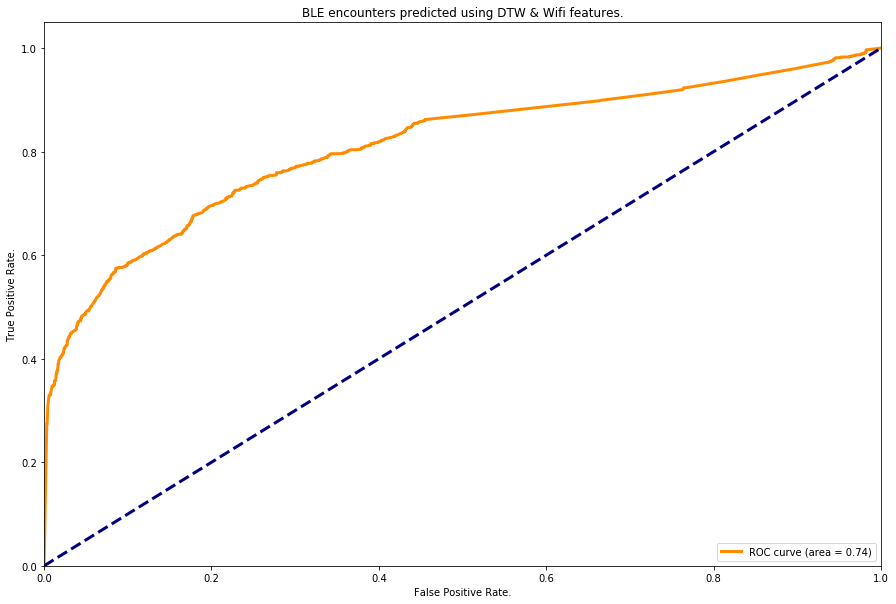

----- random check -----
(3615,)
1446
(3615,)
1780
------------------------


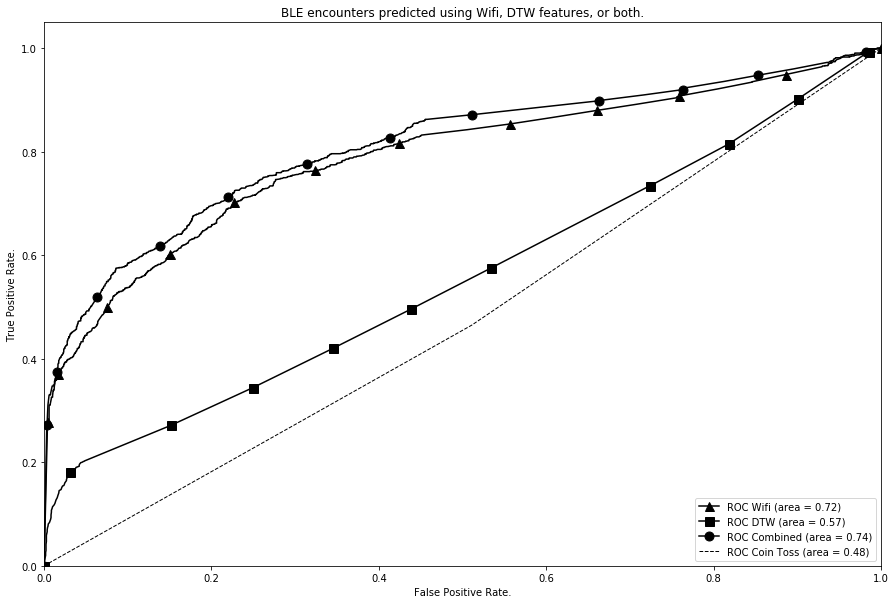


------------------- Gradient Boost -------------------
--- Statistics ---
Mean accuracy: 0.7671056457660581
Mean recall: 0.6154972970482762
Mean precision: 0.7575863827590912
Mean F1: 0.6780939414317608
Mean ROC-AUC: 0.7414695788921671


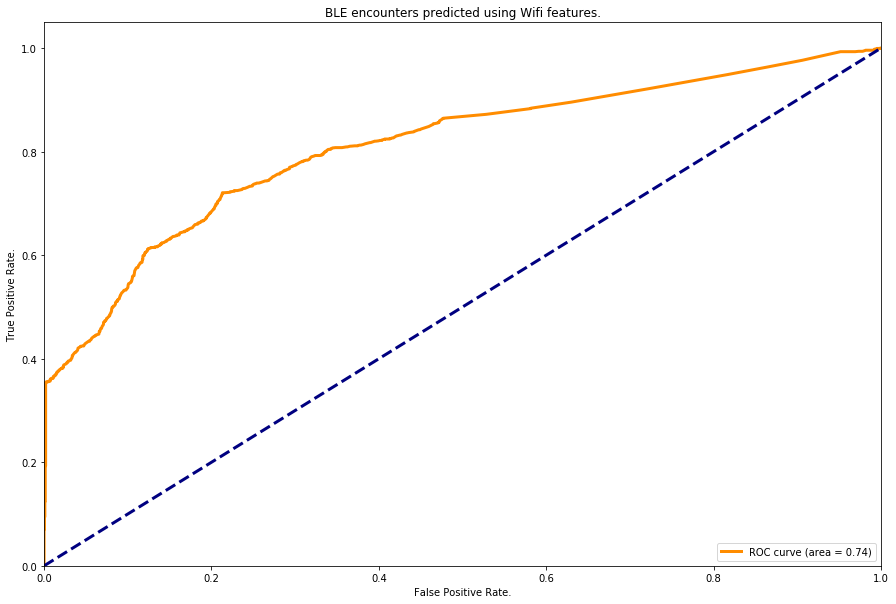

--- Statistics ---
Mean accuracy: 0.6520063972084909
Mean recall: 0.18347634093014756
Mean precision: 0.7768501243967906
Mean F1: 0.295933733550466
Mean ROC-AUC: 0.574143638774662


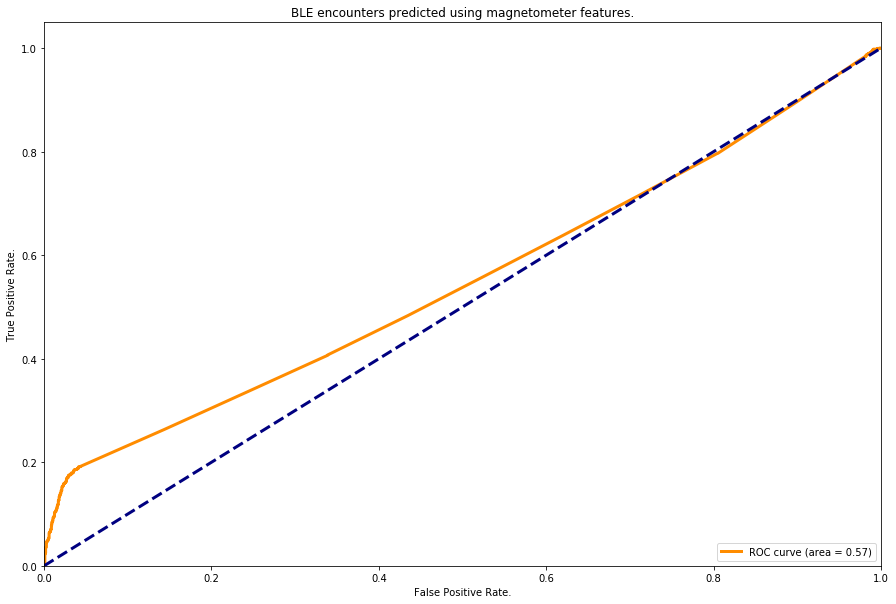

--- Statistics ---
Mean accuracy: 0.7723259515465023
Mean recall: 0.6147728497618172
Mean precision: 0.7729833280628629
Mean F1: 0.6837211969057935
Mean ROC-AUC: 0.7463836767928773


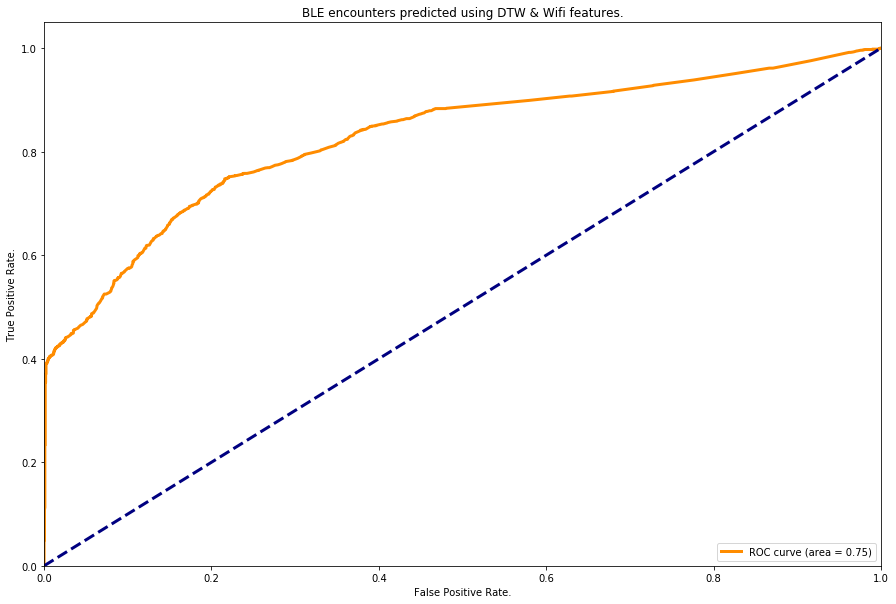

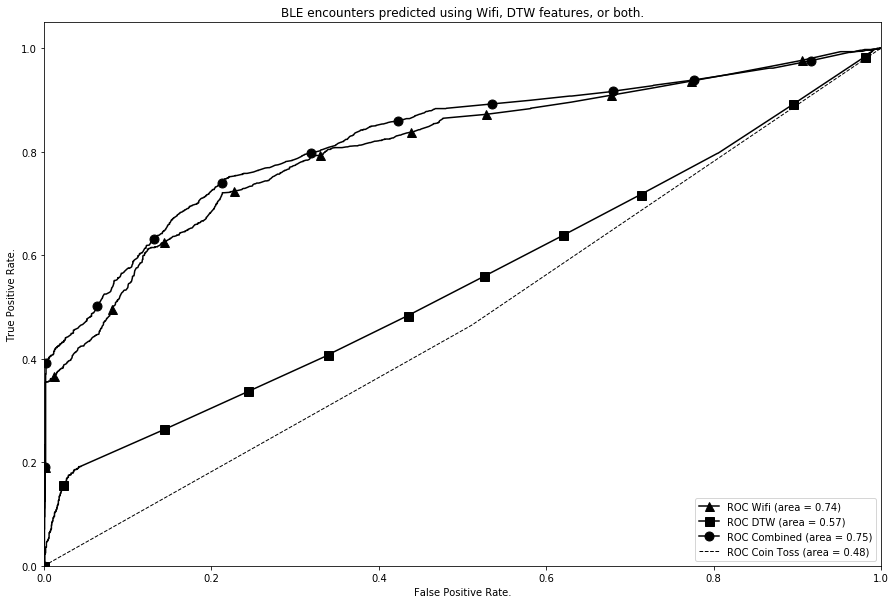


------------------- Compare Models -------------------


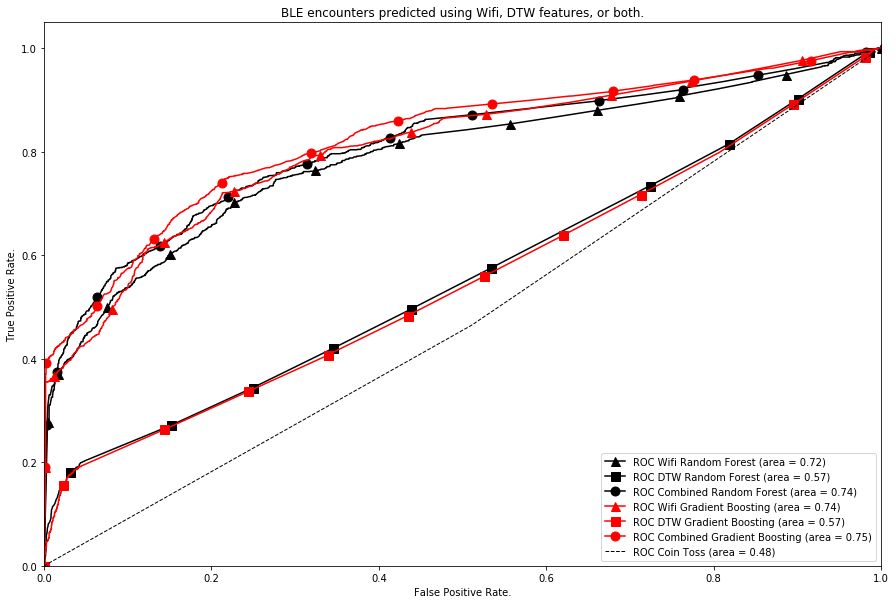

In [230]:
rates_4060 = assess_experiment_default(experiment_4060, '4060')


------------------- Experiment 5050 -------------------
Labels: (2892,)
Features Wifi: (2892, 13)
Features Magnetometer: (2892, 12)
Features All: (2892, 25)

------------------- Random Forest -------------------
--- Statistics ---
Mean accuracy: 0.7385825080539314
Mean recall: 0.668327803048291
Mean precision: 0.7777743598910909
Mean F1: 0.718485847017892
Mean ROC-AUC: 0.7386749482898199


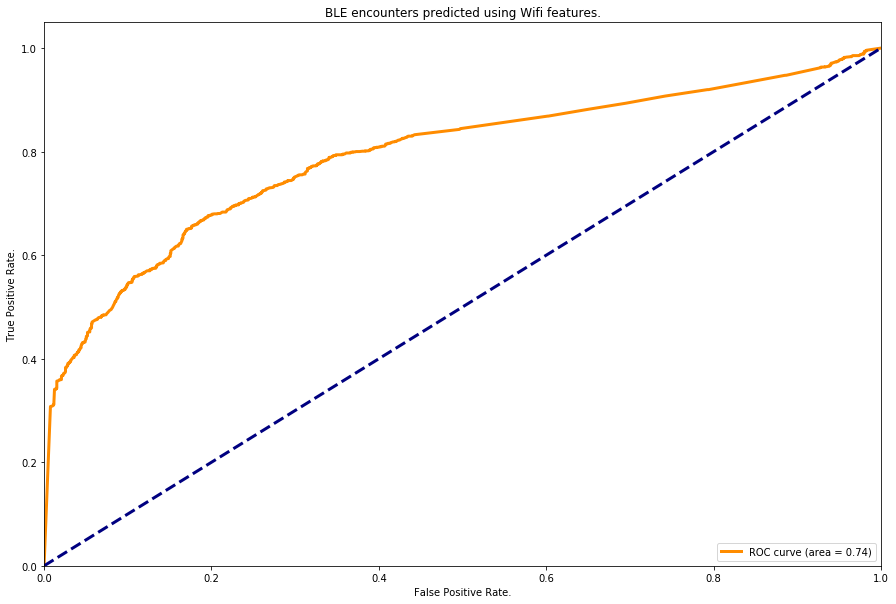

--- Statistics ---
Mean accuracy: 0.5760637155470707
Mean recall: 0.195869169166357
Mean precision: 0.8202509433133006
Mean F1: 0.3157204594245772
Mean ROC-AUC: 0.576023085432005


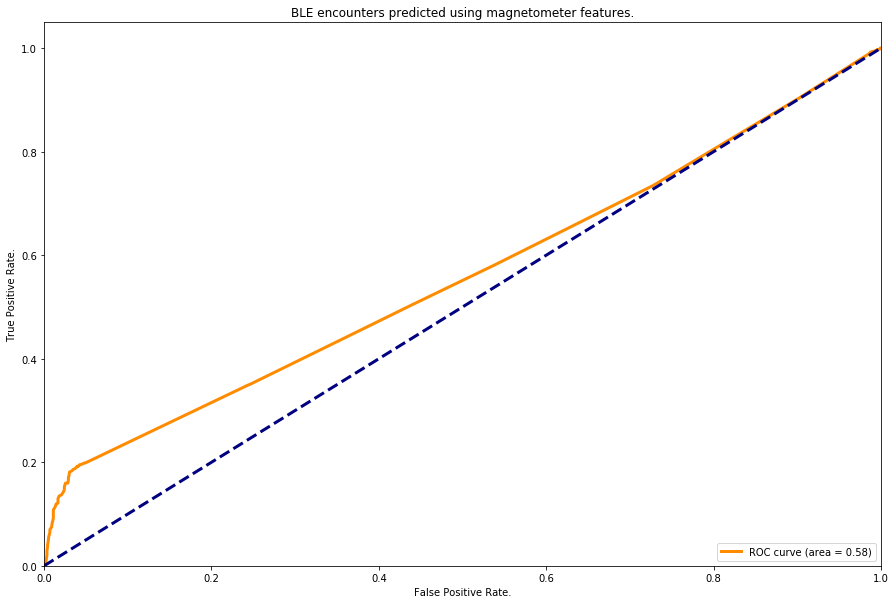

--- Statistics ---
Mean accuracy: 0.7403090323350436
Mean recall: 0.683886386672922
Mean precision: 0.7710375876376829
Mean F1: 0.7243124753363516
Mean ROC-AUC: 0.7406002261331073


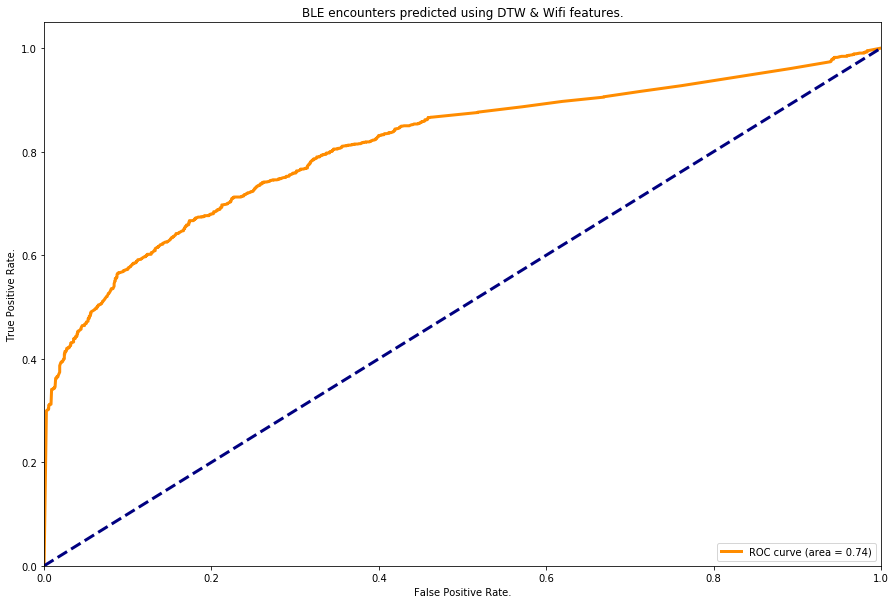

----- random check -----
(2892,)
1446
(2892,)
1443
------------------------


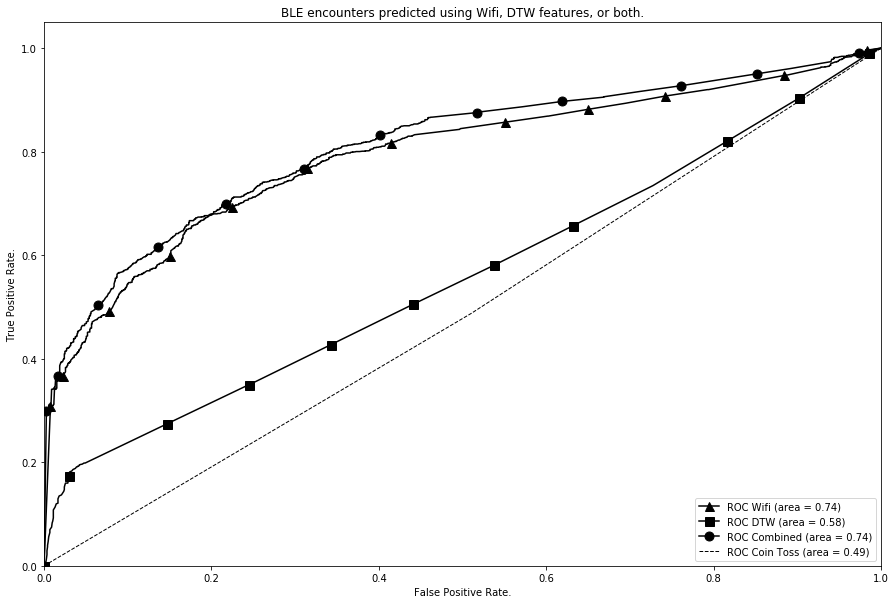


------------------- Gradient Boost -------------------
--- Statistics ---
Mean accuracy: 0.7517324901563058
Mean recall: 0.7011860424374421
Mean precision: 0.7813414738080736
Mean F1: 0.7378304383661779
Mean ROC-AUC: 0.7524678093213373


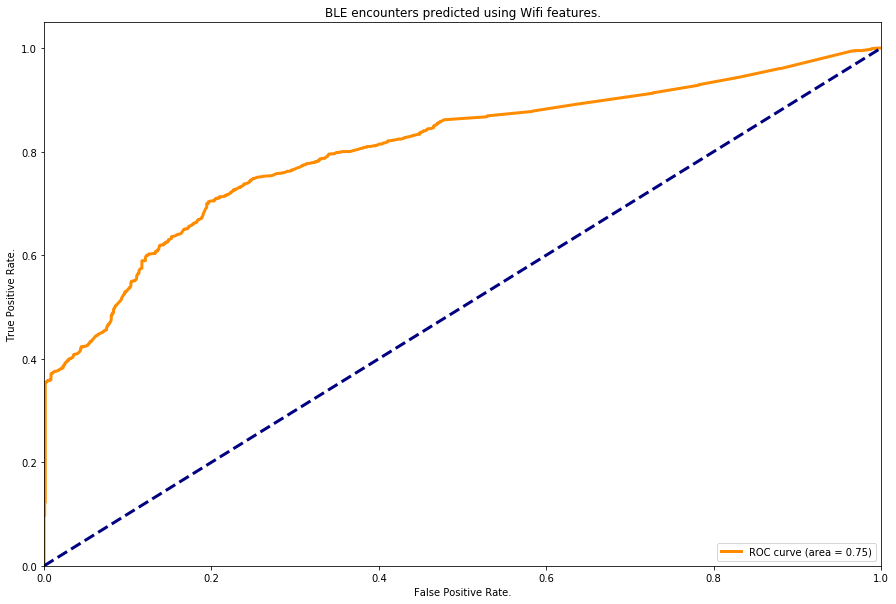

--- Statistics ---
Mean accuracy: 0.5743383844409975
Mean recall: 0.19207073870648655
Mean precision: 0.8100564061015255
Mean F1: 0.3096866878242913
Mean ROC-AUC: 0.5743063348666917


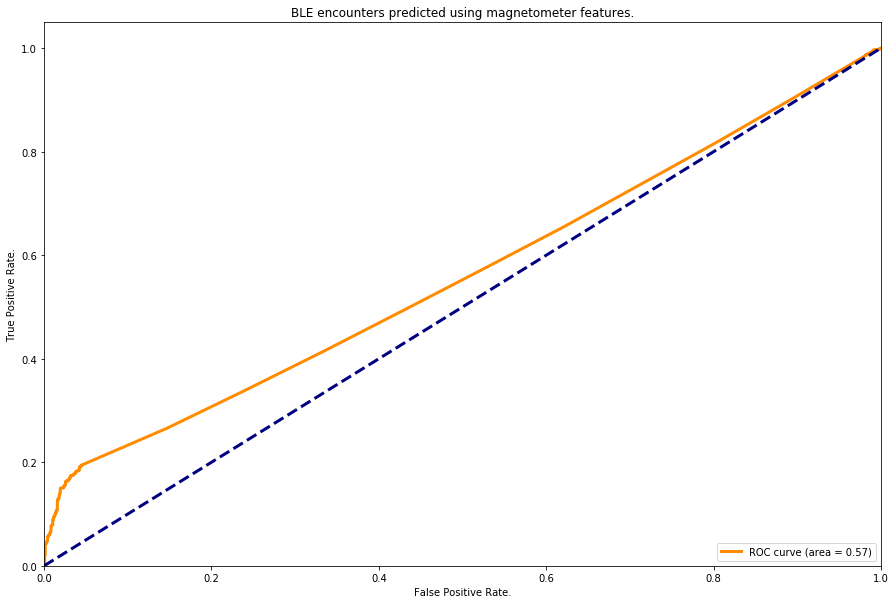

--- Statistics ---
Mean accuracy: 0.7600310225510082
Mean recall: 0.7264566795600349
Mean precision: 0.7785953936243112
Mean F1: 0.750773286798587
Mean ROC-AUC: 0.7600805346257152


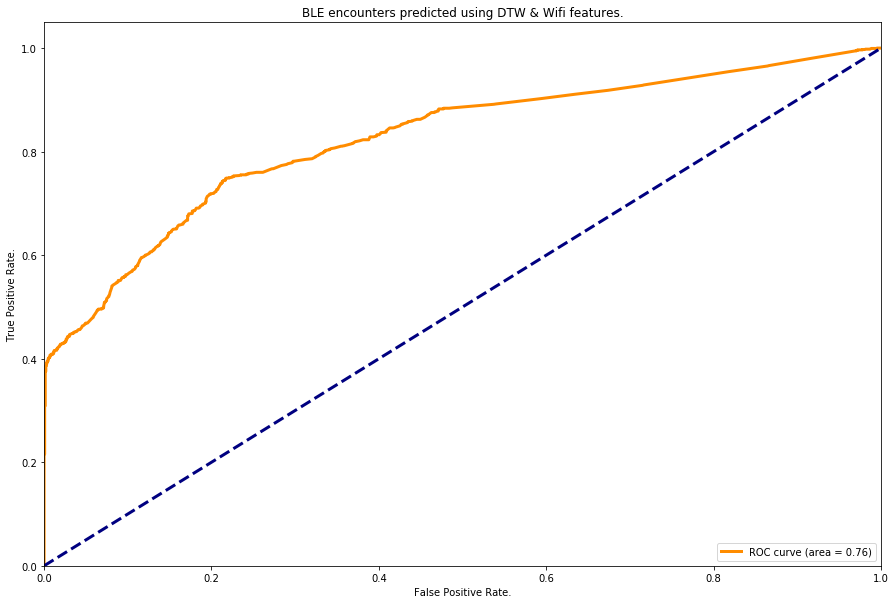

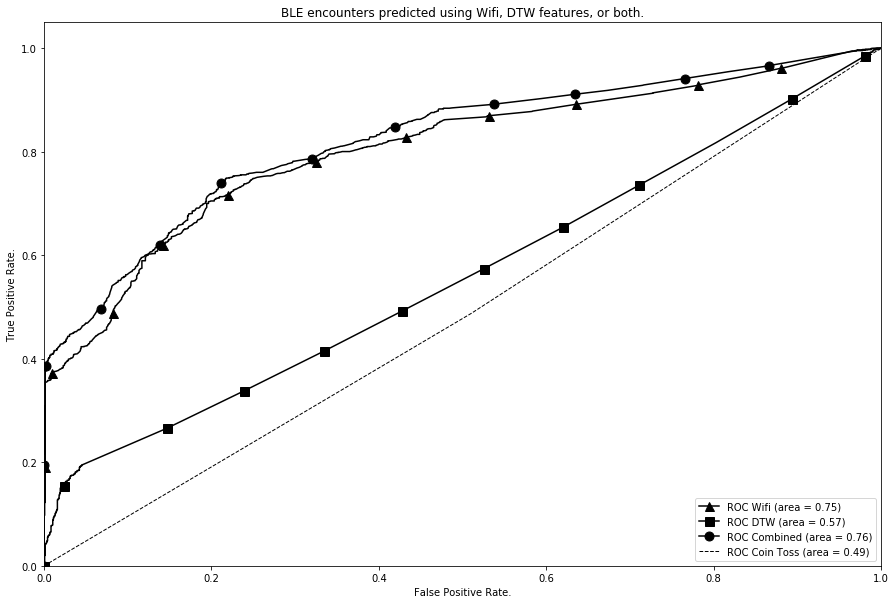


------------------- Compare Models -------------------


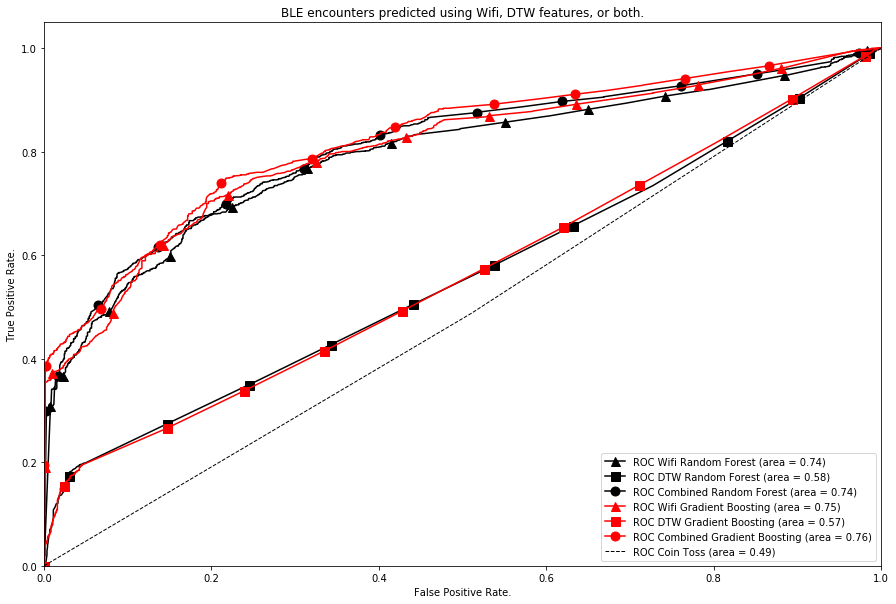

In [231]:
rates_5050 = assess_experiment_default(experiment_5050, '5050')

### 6.4.2 Hyperparamter Optimization

In [71]:
def assess_experiment_optimized(distentries, disttext):
    print('\n------------------- Experiment ' + disttext + ' -------------------')
    labels = distentries.encounter_BLE.values
    features_wifi = filter_experiment_mean(experiment_originalfeatures, distentries)
    features_magnetometer = filter_experiment_max(experiment_dtw_magnetometer, distentries)
    features_combined = np.concatenate((features_wifi,features_magnetometer), axis=1)
    print('Labels:', labels.shape)
    print('Features Wifi:', features_wifi.shape)
    print('Features Magnetometer:', features_magnetometer.shape)
    print('Features All:', features_combined.shape)
    
    wifi_columns = [f for f in experiment_originalfeatures.columns if 'encounter' not in f]
    magnetometer_columns = [f for f in experiment_dtw_magnetometer.columns if 'encounter' not in f]
    combined_columns = np.concatenate([wifi_columns, magnetometer_columns])
    
    print('\n------------------- Random Forest -------------------')
    _, rates_wifi, _ = opt_forest(
        X = features_wifi,
        y = labels,
        iterations = 1000,
        feature_list = wifi_columns,
        plot_title = 'BLE encounters predicted using Wifi features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + 'optimized_forest_wifi.pdf'),
        cv = 10,
        seed = RSEED
    )
    
    _, rates_magnetometer, _ = opt_forest(
        X = features_magnetometer,
        y = labels,
        iterations = 1000,
        feature_list = magnetometer_columns,
        plot_title = 'BLE encounters predicted using magnetometer features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + 'optimized_forest_magnetometer.pdf'),
        cv = 10,
        seed = RSEED
    )
    
    _, rates_combined, _ = opt_forest(
        X = features_combined,
        y = labels,
        iterations = 1000,
        feature_list = combined_columns,
        plot_title = 'BLE encounters predicted using Wifi & DTW features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + 'optimized_forest_combined.pdf'),
        cv = 10,
        seed = RSEED
    )
    
    rand_predict = np.random.randint(2, size=labels.shape)
    random_fpr, random_tpr, _ = roc_curve(labels, rand_predict)
    random_roc_auc = roc_auc_score(labels, rand_predict)
    rates_random = (random_fpr, random_tpr, random_roc_auc)
    
    # compare, wifi, dtw, both and coin flip
    fig, ax = plt.subplots()
    ax.plot(rates_wifi[0], 
            rates_wifi[1],
            marker = '^',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Wifi (area = %0.2f)' % np.nanmean(rates_wifi[2])
           )
    ax.plot(rates_magnetometer[0], 
            rates_magnetometer[1],
            marker = 's',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC DTW (area = %0.2f)' % np.nanmean(rates_magnetometer[2])
           )
    ax.plot(rates_combined[0], 
            rates_combined[1],
            marker = 'o',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Combined (area = %0.2f)' % np.nanmean(rates_combined[2])
           )
    ax.plot(rates_random[0], 
            rates_random[1],
            linestyle = '--',
            color = 'k',
            linewidth = 1,
            label='ROC Coin Toss (area = %0.2f)' % np.nanmean(rates_random[2])
           )
        
    #ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_ylim(0,1.05)
    ax.set_xlim(0,1)

    ax.set_title('BLE encounters predicted using Wifi, DTW features, or both.')
    ax.set_xlabel('False Positive Rate.')
    ax.set_ylabel('True Positive Rate.')
    ax.legend(loc="lower right")

    fig.savefig(
        os.path.join(result_path,'bigdata',disttext+'optimized_forest_compare.pdf'),
        format="pdf",
        bbox_inches="tight")
    plt.show()
    
    print('\n------------------- Gradient Boost -------------------')
    _, rates_wifi_gradient = opt_boost(
        X = features_wifi,
        y = labels,
        iterations = 1000,
        feature_list = wifi_columns,
        plot_title = 'BLE encounters predicted using Wifi features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + 'optimized_gradientboost_wifi.pdf'),
        cv = 10
    )
    
    _, rates_magnetometer_gradient = opt_boost(
        X = features_magnetometer,
        y = labels,
        iterations = 1000,
        feature_list = magnetometer_columns,
        plot_title = 'BLE encounters predicted using magnetometer features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + 'optimized_gradientboost_magnetometer.pdf'),
        cv = 10
    )
    
    _, rates_combined_gradient = opt_boost(
        X = features_combined,
        y = labels,
        iterations = 1000,
        feature_list = combined_columns,
        plot_title = 'BLE encounters predicted using Wifi & DTW features.',
        plot_name = os.path.join(result_path, 'bigdata', disttext + 'optimized_gradientboost_combined.pdf'),
        cv = 10
    )
    
    # compare, wifi, dtw, both and coin flip
    fig, ax = plt.subplots()
    ax.plot(rates_wifi_gradient[0], 
            rates_wifi_gradient[1],
            marker = '^',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Wifi (area = %0.2f)' % np.nanmean(rates_wifi_gradient[2])
           )
    ax.plot(rates_magnetometer_gradient[0], 
            rates_magnetometer_gradient[1],
            marker = 's',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC DTW (area = %0.2f)' % np.nanmean(rates_magnetometer_gradient[2])
           )
    ax.plot(rates_combined_gradient[0], 
            rates_combined_gradient[1],
            marker = 'o',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Combined (area = %0.2f)' % np.nanmean(rates_combined_gradient[2])
           )
    ax.plot(rates_random[0], 
            rates_random[1],
            linestyle = '--',
            color = 'k',
            linewidth = 1,
            label='ROC Coin Toss (area = %0.2f)' % np.nanmean(rates_random[2])
           )
        
    #ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_ylim(0,1.05)
    ax.set_xlim(0,1)

    ax.set_title('BLE encounters predicted using Wifi, DTW features, or both.')
    ax.set_xlabel('False Positive Rate.')
    ax.set_ylabel('True Positive Rate.')
    ax.legend(loc="lower right")

    fig.savefig(
        os.path.join(result_path,'bigdata',disttext+'optimized_gradientboost_compare.pdf'),
        format="pdf", 
        bbox_inches="tight")
    plt.show()
    
    print('\n------------------- Compare Models -------------------')
    fig, ax = plt.subplots()
    ax.plot(rates_wifi[0], 
            rates_wifi[1],
            marker = '^',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Wifi Random Forest (area = %0.2f)' % np.nanmean(rates_wifi[2])
           )
    ax.plot(rates_magnetometer[0], 
            rates_magnetometer[1],
            marker = 's',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC DTW Random Forest (area = %0.2f)' % np.nanmean(rates_magnetometer[2])
           )
    ax.plot(rates_combined[0], 
            rates_combined[1],
            marker = 'o',
            markevery = 0.1,
            color = 'k',
            linewidth = 1.5,
            label='ROC Combined Random Forest (area = %0.2f)' % np.nanmean(rates_combined[2])
           )
    ax.plot(rates_wifi_gradient[0], 
            rates_wifi_gradient[1],
            marker = '^',
            markevery = 0.1,
            color = 'r',
            linewidth = 1.5,
            label='ROC Wifi Gradient Boosting (area = %0.2f)' % np.nanmean(rates_wifi_gradient[2])
           )
    ax.plot(rates_magnetometer_gradient[0], 
            rates_magnetometer_gradient[1],
            marker = 's',
            markevery = 0.1,
            color = 'r',
            linewidth = 1.5,
            label='ROC DTW Gradient Boosting (area = %0.2f)' % np.nanmean(rates_magnetometer_gradient[2])
           )
    ax.plot(rates_combined_gradient[0], 
            rates_combined_gradient[1],
            marker = 'o',
            markevery = 0.1,
            color = 'r',
            linewidth = 1.5,
            label='ROC Combined Gradient Boosting (area = %0.2f)' % np.nanmean(rates_combined_gradient[2])
           )
    ax.plot(rates_random[0], 
            rates_random[1],
            linestyle = '--',
            color = 'k',
            linewidth = 1,
            label='ROC Coin Toss (area = %0.2f)' % np.nanmean(rates_random[2])
           )
        
    ax.set_ylim(0,1.05)
    ax.set_xlim(0,1)

    ax.set_title('BLE encounters predicted using Wifi, DTW features, or both.')
    ax.set_xlabel('False Positive Rate.')
    ax.set_ylabel('True Positive Rate.')
    ax.legend(loc="lower right")

    fig.savefig(
        os.path.join(result_path,'bigdata',disttext+'optimized_forest_gradientboost_compare.pdf'),
        format="pdf", 
        bbox_inches="tight")
    plt.show()
    
    return (rates_wifi, rates_magnetometer, rates_combined, 
            rates_wifi_gradient, rates_magnetometer_gradient, rates_combined_gradient, 
            rates_random)


------------------- Experiment 3070 -------------------
Labels: (4771,)
Features Wifi: (4771, 13)
Features Magnetometer: (4771, 12)
Features All: (4771, 25)

------------------- Random Forest -------------------

--- Data ---
Training Features Shape: (3339, 13)
Training Labels Shape: (3339,)
Testing Features Shape: (1432, 13)
Testing Labels Shape: (1432,)

--- Fitting ---
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1195 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1762 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2527 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 3689 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4599 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 5708 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 7305 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 9095 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 13.4min finished



--- Best Parameters ---
n_estimators: 130
min_samples_split: 10
max_leaf_nodes: 20
max_features: 0.6
max_depth: 5
bootstrap: True

--- Architecture ---
Average number of nodes 35
Average maximum depth 5

--- Features ---
Variable: overlap_WIFI         Importance: 0.23
Variable: topAP6dB_WIFI        Importance: 0.23
Variable: adamic_adar_WIFI     Importance: 0.22
Variable: union_WIFI           Importance: 0.14
Variable: nonoverlap_WIFI      Importance: 0.11
Variable: jaccard_WIFI         Importance: 0.05
Variable: spearman_WIFI        Importance: 0.0
Variable: pearson_WIFI         Importance: 0.0
Variable: manhattan_WIFI       Importance: 0.0
Variable: euclidean_WIFI       Importance: 0.0
Variable: topAP_WIFI           Importance: 0.0
Variable: min_popularity_WIFI  Importance: 0.0
Variable: max_popularity_WIFI  Importance: 0.0
--- Statistics ---
Mean accuracy: 0.7946927374301676
Mean recall: 0.3916849015317287
Mean precision: 0.9179487179487179
Mean F1: 0.549079754601227
Mean ROC-AUC: 

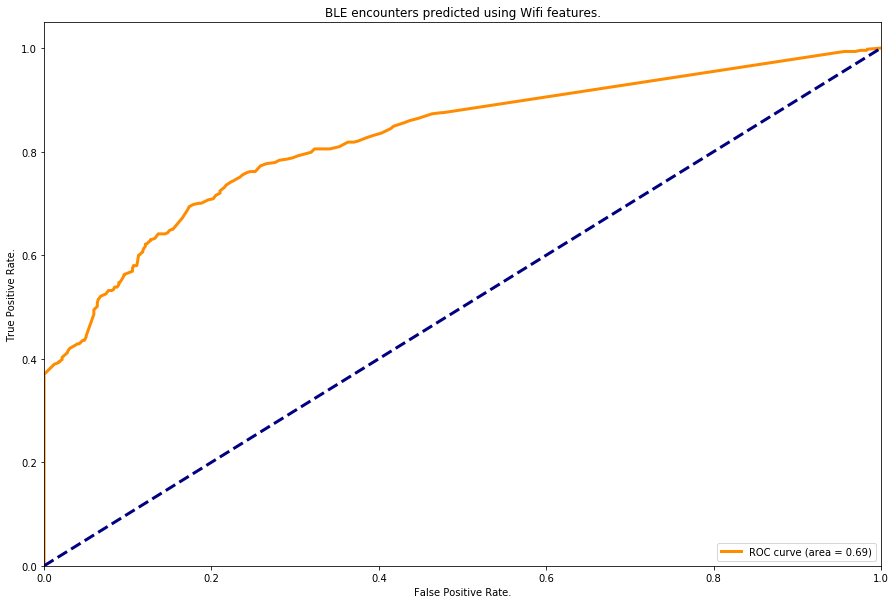


--- Data ---
Training Features Shape: (3339, 12)
Training Labels Shape: (3339,)
Testing Features Shape: (1432, 12)
Testing Labels Shape: (1432,)

--- Fitting ---
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 1195 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1691 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2337 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3485 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4298 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 5479 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 7194 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 8742 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 12.5min finished



--- Best Parameters ---
n_estimators: 21
min_samples_split: 10
max_leaf_nodes: 30
max_features: log2
max_depth: 15
bootstrap: False

--- Architecture ---
Average number of nodes 59
Average maximum depth 12

--- Features ---
Variable: centered_max_magnetometer Importance: 0.16
Variable: centered_median_magnetometer Importance: 0.11
Variable: raw_median_magnetometer Importance: 0.1
Variable: centered_min_magnetometer Importance: 0.1
Variable: raw_min_magnetometer Importance: 0.09
Variable: normalized_median_magnetometer Importance: 0.09
Variable: raw_max_magnetometer Importance: 0.08
Variable: centered_total_magnetometer Importance: 0.08
Variable: normalized_min_magnetometer Importance: 0.08
Variable: raw_total_magnetometer Importance: 0.05
Variable: normalized_max_magnetometer Importance: 0.05
Variable: normalized_total_magnetometer Importance: 0.02
--- Statistics ---
Mean accuracy: 0.7178770949720671
Mean recall: 0.16192560175054704
Mean precision: 0.7789473684210526
Mean F1: 0.268115

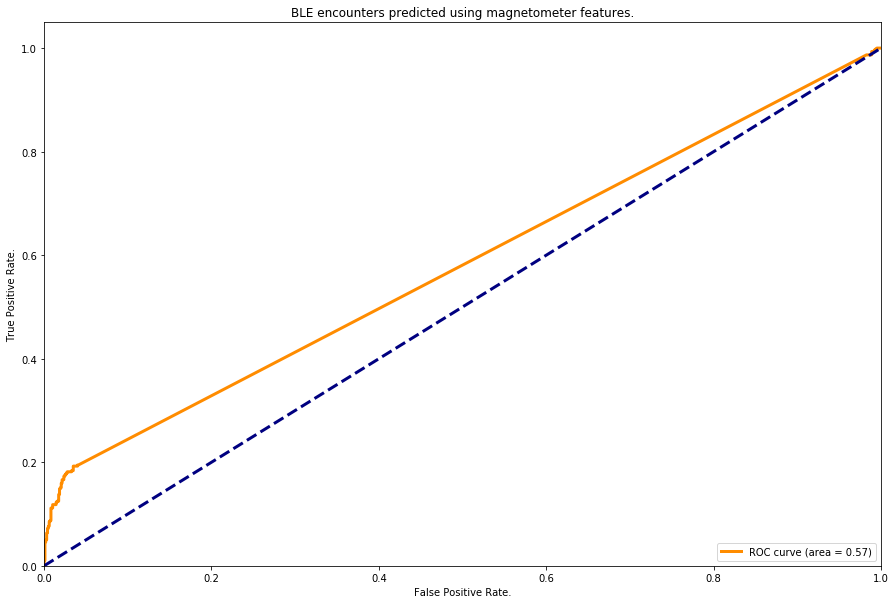


--- Data ---
Training Features Shape: (3339, 25)
Training Labels Shape: (3339,)
Testing Features Shape: (1432, 25)
Testing Labels Shape: (1432,)

--- Fitting ---
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1310 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1860 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2510 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 3260 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 4166 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 5186 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 6253 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 7403 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 8742 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 18.3min finished



--- Best Parameters ---
n_estimators: 161
min_samples_split: 5
max_leaf_nodes: 37
max_features: 0.6
max_depth: 13
bootstrap: True

--- Architecture ---
Average number of nodes 73
Average maximum depth 12

--- Features ---
Variable: topAP6dB_WIFI        Importance: 0.22
Variable: adamic_adar_WIFI     Importance: 0.19
Variable: overlap_WIFI         Importance: 0.16
Variable: nonoverlap_WIFI      Importance: 0.12
Variable: union_WIFI           Importance: 0.11
Variable: centered_min_magnetometer Importance: 0.04
Variable: centered_max_magnetometer Importance: 0.03
Variable: jaccard_WIFI         Importance: 0.02
Variable: raw_total_magnetometer Importance: 0.01
Variable: raw_min_magnetometer Importance: 0.01
Variable: raw_max_magnetometer Importance: 0.01
Variable: raw_median_magnetometer Importance: 0.01
Variable: centered_total_magnetometer Importance: 0.01
Variable: centered_median_magnetometer Importance: 0.01
Variable: normalized_total_magnetometer Importance: 0.01
Variable: normaliz

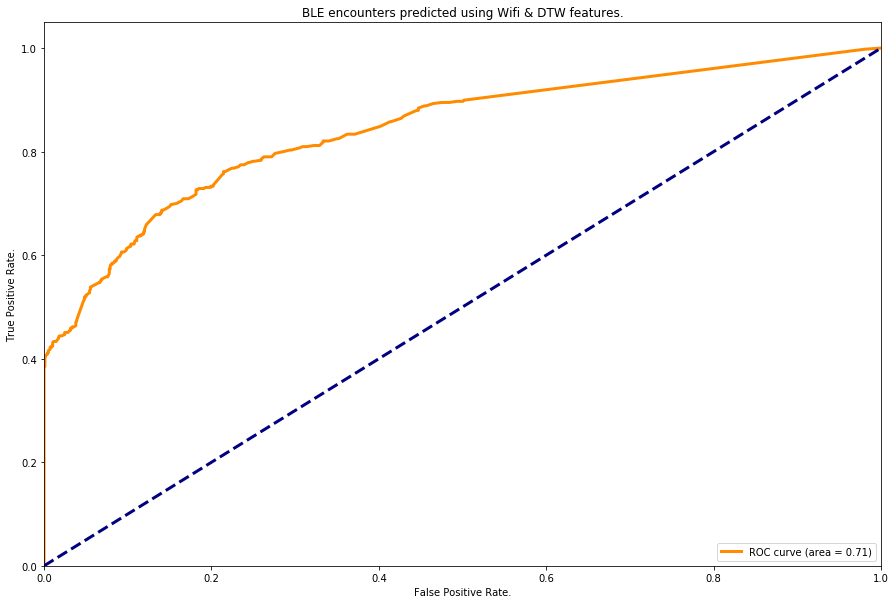

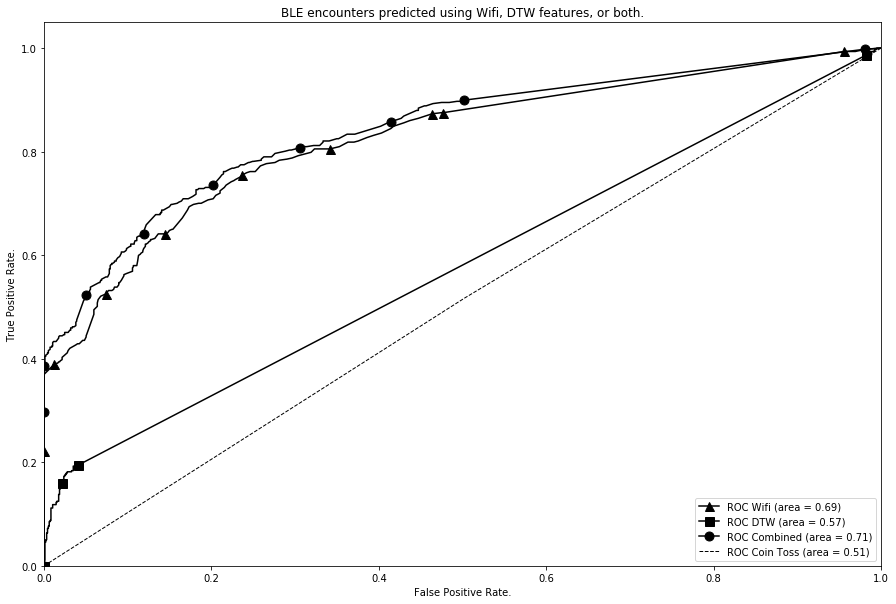


------------------- Gradient Boost -------------------

--- Data ---
Training Features Shape: (3339, 13)
Training Labels Shape: (3339,)
Testing Features Shape: (1432, 13)
Testing Labels Shape: (1432,)

--- Fitting ---
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 49.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 68.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 87.5min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 109.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 138.3min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 161.3min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 183.2min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 212.2min
[Parallel(n_jobs=-1)]: Done 10000 out of 


--- Best Parameters ---
subsample: 0.618
n_estimators: 44
min_samples_split: 5
max_leaf_nodes: 11
max_features: sqrt
max_depth: 7
learning_rate: 0.075
criterion: friedman_mse

--- Features ---
Variable: topAP6dB_WIFI        Importance: 0.28
Variable: nonoverlap_WIFI      Importance: 0.18
Variable: union_WIFI           Importance: 0.17
Variable: adamic_adar_WIFI     Importance: 0.14
Variable: overlap_WIFI         Importance: 0.08
Variable: jaccard_WIFI         Importance: 0.06
Variable: manhattan_WIFI       Importance: 0.04
Variable: euclidean_WIFI       Importance: 0.04
Variable: min_popularity_WIFI  Importance: 0.01
Variable: spearman_WIFI        Importance: 0.0
Variable: pearson_WIFI         Importance: 0.0
Variable: topAP_WIFI           Importance: 0.0
Variable: max_popularity_WIFI  Importance: 0.0
--- Statistics ---
Mean accuracy: 0.7891061452513967
Mean recall: 0.424507658643326
Mean precision: 0.8326180257510729
Mean F1: 0.5623188405797102
Mean ROC-AUC: 0.692253829321663


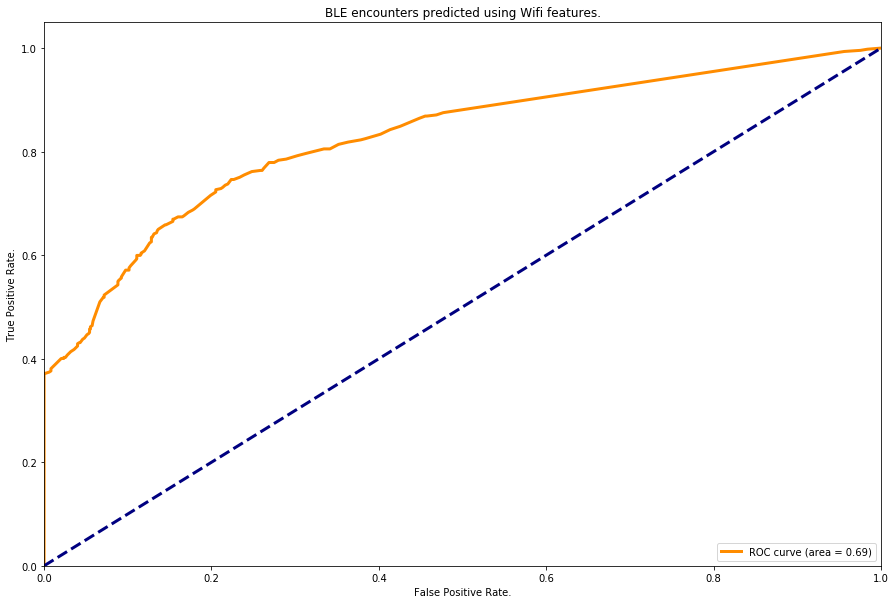


--- Data ---
Training Features Shape: (3339, 12)
Training Labels Shape: (3339,)
Testing Features Shape: (1432, 12)
Testing Labels Shape: (1432,)

--- Fitting ---
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1802 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 3202 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 4052 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 5002 tasks      | elapsed: 43.2min
[Parallel(n_jobs=-1)]: Done 6052 tasks      | elapsed: 54.5min
[Parallel(n_jobs=-1)]: Done 7202 tasks      | elapsed: 63.4min
[Parallel(n_jobs=-1)]: Done 8452 tasks      | elapsed: 72.1min
[Parallel(n_jobs=-1)]: Done 9802 tasks      | elapsed: 82.9min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000


--- Best Parameters ---
subsample: 0.9
n_estimators: 68
min_samples_split: 10
max_leaf_nodes: 34
max_features: sqrt
max_depth: 13
learning_rate: 0.01
criterion: friedman_mse

--- Features ---
Variable: centered_max_magnetometer Importance: 0.13
Variable: centered_min_magnetometer Importance: 0.11
Variable: raw_max_magnetometer Importance: 0.1
Variable: centered_median_magnetometer Importance: 0.1
Variable: normalized_min_magnetometer Importance: 0.1
Variable: raw_median_magnetometer Importance: 0.08
Variable: centered_total_magnetometer Importance: 0.08
Variable: normalized_max_magnetometer Importance: 0.08
Variable: normalized_median_magnetometer Importance: 0.08
Variable: raw_min_magnetometer Importance: 0.06
Variable: raw_total_magnetometer Importance: 0.05
Variable: normalized_total_magnetometer Importance: 0.03
--- Statistics ---
Mean accuracy: 0.7018156424581006
Mean recall: 0.08096280087527352
Mean precision: 0.8409090909090909
Mean F1: 0.14770459081836326
Mean ROC-AUC: 0.53689

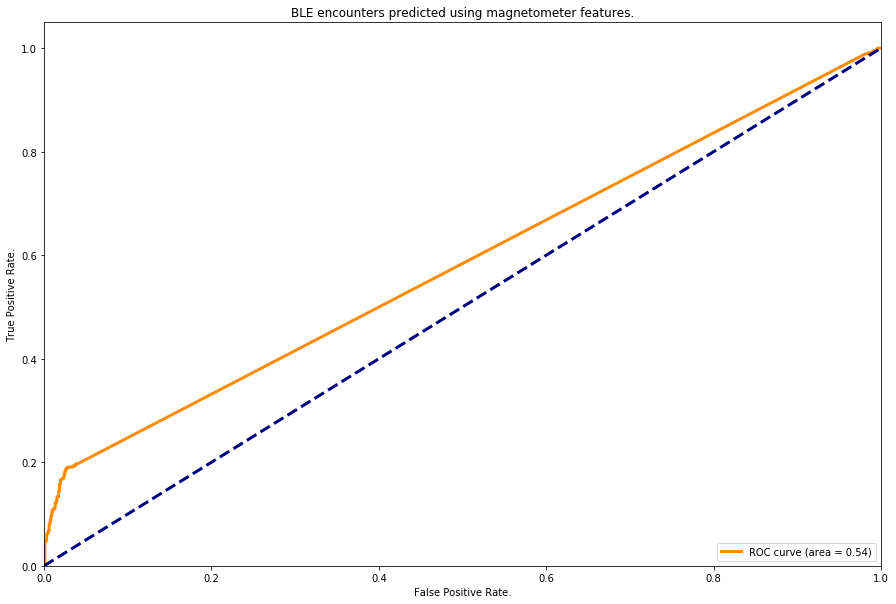


--- Data ---
Training Features Shape: (3339, 25)
Training Labels Shape: (3339,)
Testing Features Shape: (1432, 25)
Testing Labels Shape: (1432,)

--- Fitting ---
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 38.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 51.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 72.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 96.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 120.4min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 146.9min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 182.7min


In [ ]:
rates_opt_3070 = assess_experiment_optimized(experiment_3070, '3070')

In [ ]:
rates_opt_4060 = assess_experiment_optimized(experiment_4060, '4060')

In [ ]:
rates_opt_5050 = assess_experiment_optimized(experiment_5050, '5050')

In [ ]:
log('Graphs computed.')

### 6.4.3 Filter NaNs in Magnetometer Data

In [67]:
entries_filled = experiment_3070.merge(
    experiment_dtw_magnetometer[experiment_dtw_magnetometer.raw_total_magnetometer.notnull()],
    left_index = True,
    right_index = True)[['encounter_BLE']]

entries_filled.encounter_BLE.value_counts()

1    303
0    214
Name: encounter_BLE, dtype: int64


------------------- Experiment filled -------------------
Labels: (517,)
Features Wifi: (517, 13)
Features Magnetometer: (517, 12)
Features All: (517, 25)

------------------- Random Forest -------------------
--- Statistics ---
Mean accuracy: 0.7077677224736048
Mean recall: 0.7472039760387925
Mean precision: 0.7580071118609107
Mean F1: 0.748067492972298
Mean ROC-AUC: 0.6993708386218382


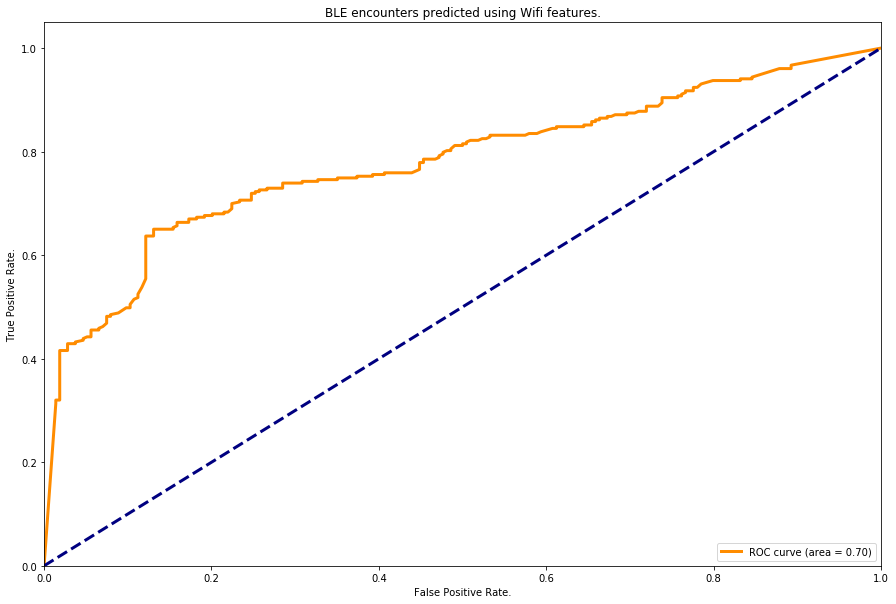

--- Statistics ---
Mean accuracy: 0.7
Mean recall: 0.7971138548140773
Mean precision: 0.7228970072006625
Mean F1: 0.7560108498960944
Mean ROC-AUC: 0.6805616874388883


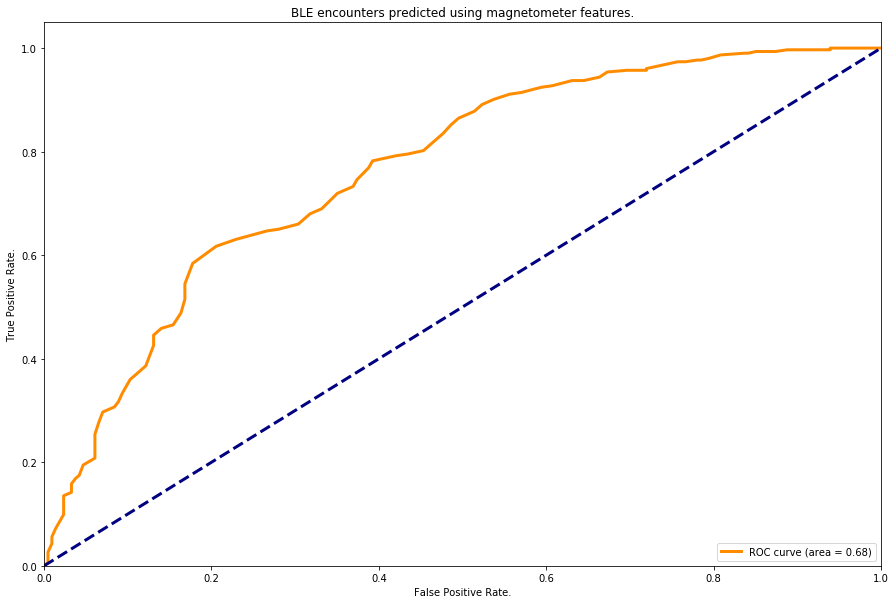

--- Statistics ---
Mean accuracy: 0.8218325791855203
Mean recall: 0.8340144153214231
Mean precision: 0.8592429845419278
Mean F1: 0.844284000877319
Mean ROC-AUC: 0.8210339368654594


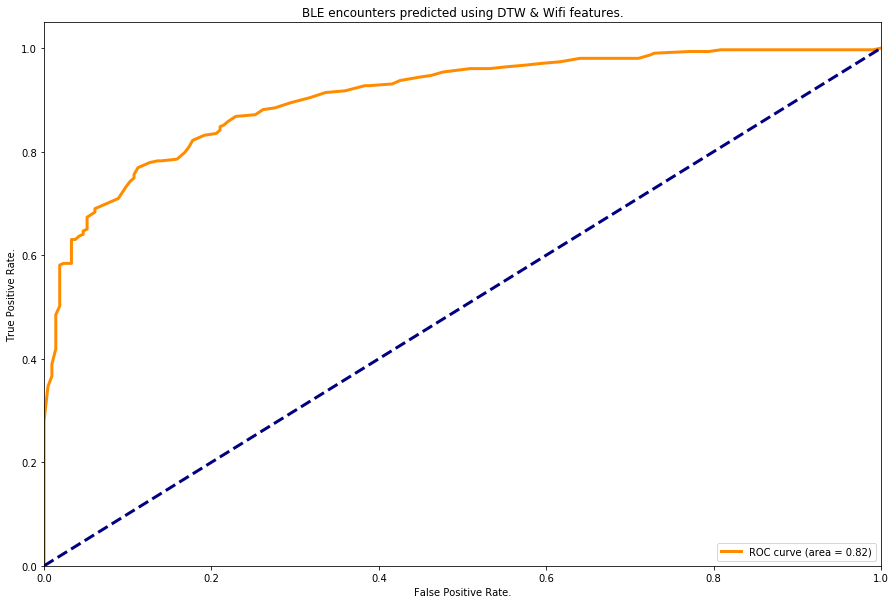

----- random check -----
(517,)
303
(517,)
270
------------------------


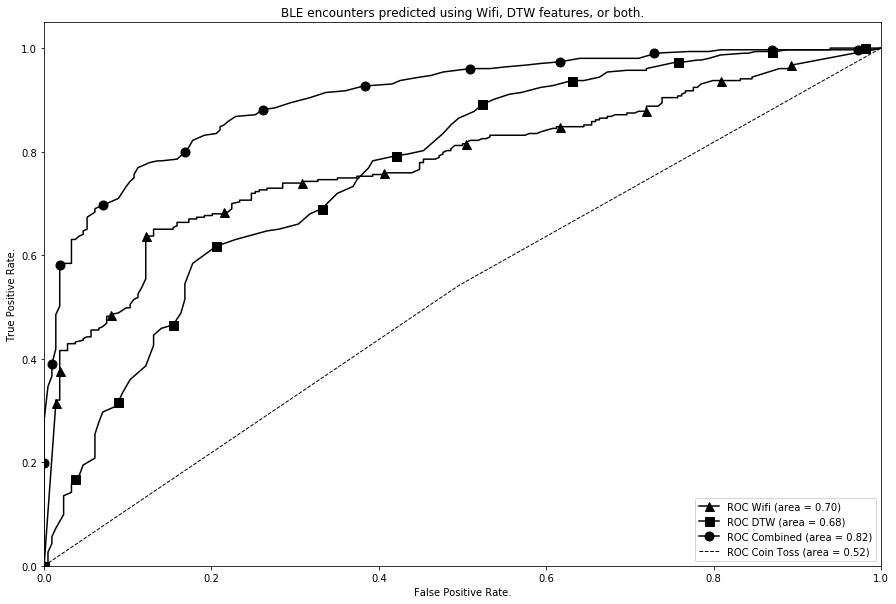


------------------- Gradient Boost -------------------
--- Statistics ---
Mean accuracy: 0.6984162895927601
Mean recall: 0.6762679372870826
Mean precision: 0.7885848758374996
Mean F1: 0.7188163940446777
Mean ROC-AUC: 0.7073583036970084


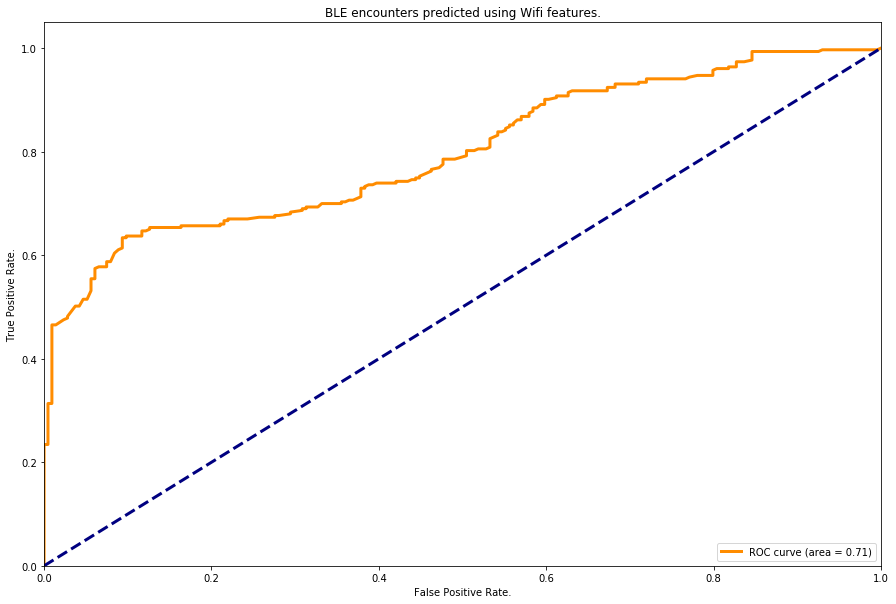

--- Statistics ---
Mean accuracy: 0.6768853695324284
Mean recall: 0.756778061063419
Mean precision: 0.7088313976955976
Mean F1: 0.7270611513460186
Mean ROC-AUC: 0.6605113405888021


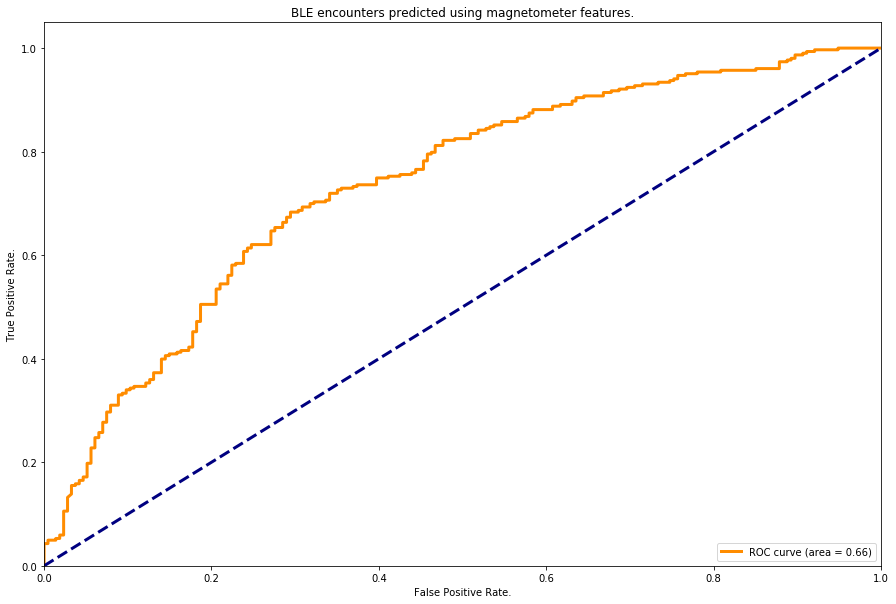

--- Statistics ---
Mean accuracy: 0.7851809954751131
Mean recall: 0.803686256789705
Mean precision: 0.8276130918066402
Mean F1: 0.8103892316087358
Mean ROC-AUC: 0.7844537414495691


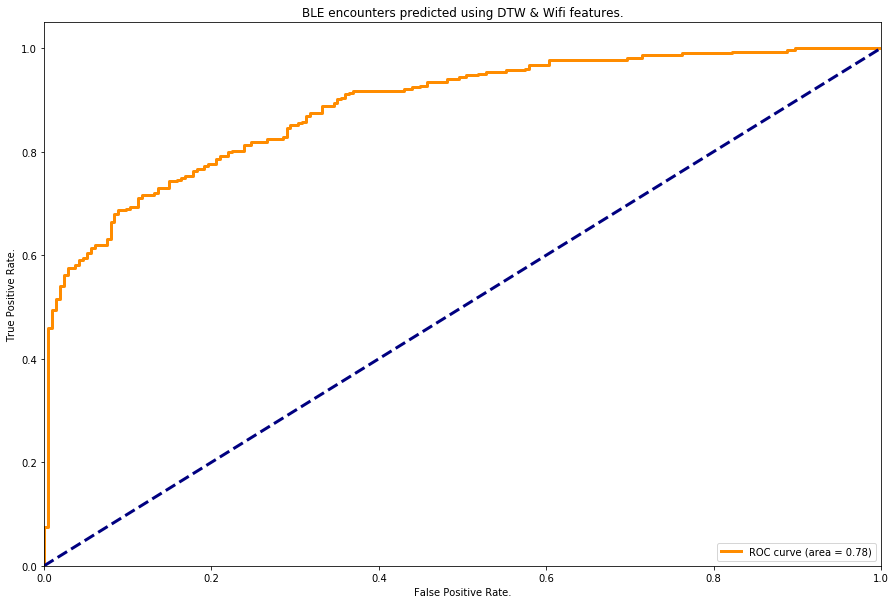

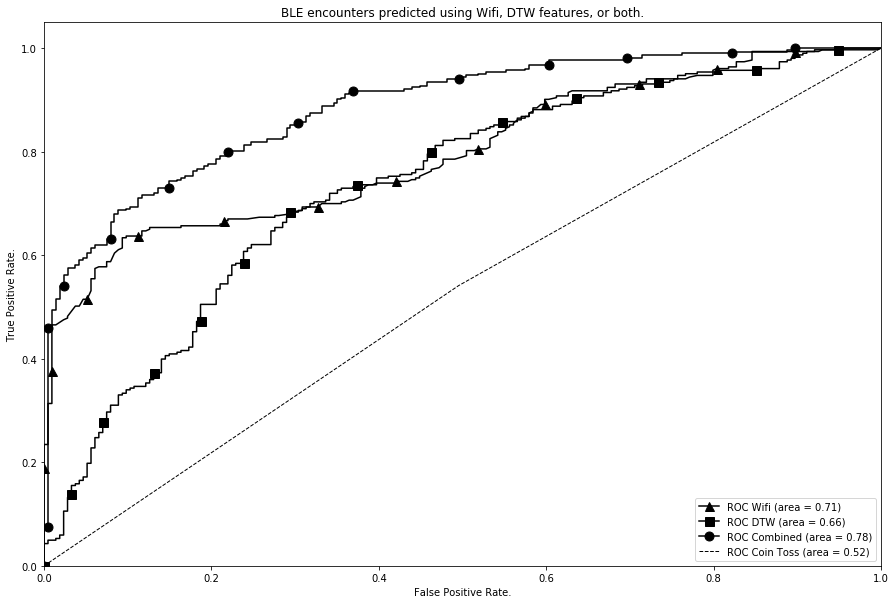


------------------- Compare Models -------------------


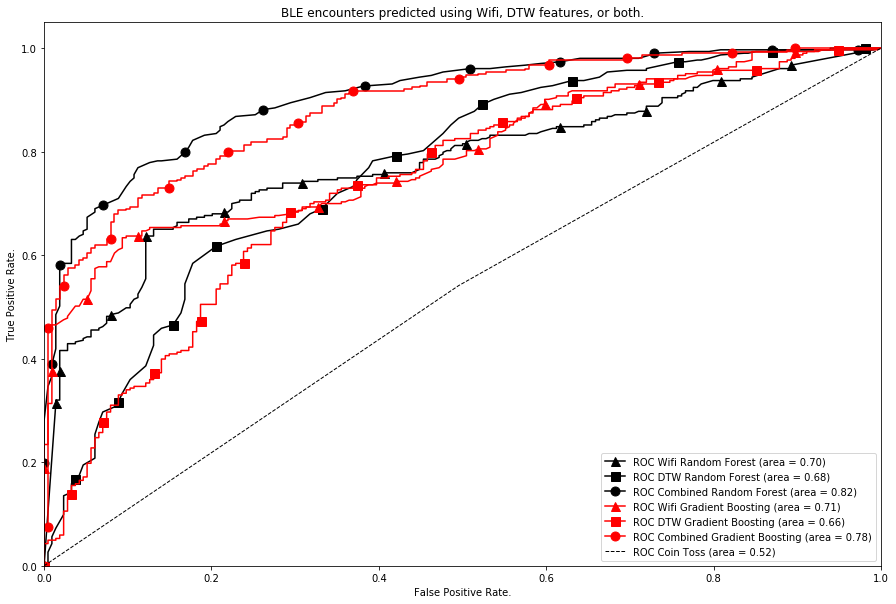

In [232]:
rates_filled = assess_experiment_default(entries_filled, 'filled')

In [ ]:
rates_opt_filled = assess_experiment_optimized(entries_filled, 'filled')


------------------- Experiment filled -------------------
Labels: (517,)
Features Wifi: (517, 13)
Features Magnetometer: (517, 12)
Features All: (517, 25)

------------------- Random Forest -------------------

--- Data ---
Training Features Shape: (361, 13)
Training Labels Shape: (361,)
Testing Features Shape: (156, 13)
Testing Labels Shape: (156,)

--- Fitting ---
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 339 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 839 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1539 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2439 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3539 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4839 tasks      | elapsed:  3.8min


In [ ]:
log('Optimization done')

## 6.5 Why are there so many NaNs?

In [248]:
experiment_dtw_magnetometer.shape

(4771, 12)

In [243]:
experiment_dtw_magnetometer.describe()

raw_total_magnetometer  raw_min_magnetometer  raw_max_magnetometer  \
count                 517.000               515.000               515.000   
mean              1180355.183             56634.162            121872.716   
std               2819224.854            140064.570            287125.894   
min                 21455.478               498.100              2074.162   
25%                125095.843              5531.985             13471.958   
50%                211836.754             10250.185             23838.994   
75%                495098.237             21858.312             53348.254   
max              19259963.398            957043.877           2917021.973   

       raw_median_magnetometer  centered_total_magnetometer  \
count                  515.000                      517.000   
mean                 87591.631                   765436.272   
std                 214721.238                  1935075.217   
min                   2063.486                      580.964   
25%                   9537.556                    72523.124   
50%                  17090.430                   138267.688   
75%                  34908.291                   349925.588   
max                2029152.068                 14278620.339   

       centered_min_magnetometer  centered_max_magnetometer  \
count                    515.000                    515.000   
mean                    7020.898                  35016.544   
std                    18299.327                 111695.918   
min                        1.524                     61.921   
25%                      303.111                   2372.964   
50%                     1130.130                   6037.228   
75%                     3412.129                  16206.694   
max                   179117.374                1531006.906   

       centered_median_magnetometer  normalized_total_magnetometer  \
count                       515.000                        517.000   
mean                      14223.838                       3645.268   
std                       38012.183                       9486.245   
min                          31.575                        111.002   
25%                        1011.039                        478.353   
50%                        2654.315                        716.703   
75%                        6882.950                       1460.510   
max                      304436.277                      80482.409   

       normalized_min_magnetometer  normalized_max_magnetometer  \
count                      515.000                      515.000   
mean                       293.883                      556.918   
std                        677.001                     1273.952   
min                          2.674                       27.132   
25%                         46.695                       89.472   
50%                         69.672                      148.509   
75%                        143.875                      261.703   
max                       4386.080                     8804.589   

       normalized_median_magnetometer  
count                         515.000  
mean                          400.755  
std                           894.029  
min                            25.235  
25%                            63.616  
50%                           107.941  
75%                           197.461  
max                          5539.988

### 6.5.1 So Many Missing Records?

**Assumption**: NaNs are only produced, if at least on the the devices has no records in the time period for this entry.

In [268]:
df_nan = experiment_3070.merge(
    experiment_dtw_magnetometer[experiment_dtw_magnetometer.raw_total_magnetometer.isnull()],
    left_index = True,
    right_index = True
)

values_nan = df_nan.values

In [ ]:
i = 1
nan_shapes = {}
for v in values_nan:
    nan_devices = [v[1],v[2]]
    nan_times = [v[3],v[4]]
    
    nan_df = data_magnetometer[
        (data_magnetometer.device_id.isin(nan_devices)) &
        (data_magnetometer.timestamp >= nan_times[0]) &
        (data_magnetometer.timestamp <= nan_times[1])
    ]
    nan_shapes[v[0]] = nan_df.device_id.value_counts().shape
    
    log('[NaN Check]\tRow ' + str(i) + ' of ' + str(values_nan.shape[0]))
    i += 1

In [286]:
s0 = 0
s1 = 0
s2 = 0

for key in nan_shapes:
    if nan_shapes[key][0] == 0:
        s0 += 1
    if nan_shapes[key][0] == 1:
        s1 += 1
    if nan_shapes[key][0] == 2:
        s2 += 1
        
print('Entries with NaN results:', values_nan.shape[0])
print('No magnetometer records:', s0)
print('Magnetometer records from 1 device:', s1)
print('Magnetometer records from 2 devices:', s2)

Entries with NaN results: 4254
No magnetometer records: 2084
Magnetometer records from 1 device: 2170
Magnetometer records from 2 devices: 0


# 7 Training Data Description

In [333]:
def training_data(data, entries, sensor):
    df = pd.DataFrame(columns = ['key','device_1','device_2','starttime','endtime'])
    i = 1
    values = entries.values
    for v in values:
        dfv = data[
            (data.device_id.isin([v[1],v[2]])) & 
            (data.timestamp >= v[3]) &
            (data.timestamp <= v[4])
        ]
        log('[' + sensor + ']\t[' + str(i).zfill(4) + ' of ' + str(values.shape[0]) + ']\tStep added to training data.')
        i += 1
        df = pd.concat([df,dfv])
    log('[' + sensor + ']\tTraining data computed.')
    df.to_parquet(os.path.join(experiment_path,'training_data_' + sensor))
    log('[' + sensor + ']\tTraining data exported.')

In [ ]:
proc = []

for sensor in ['BLE','WIFI','Accelerometer','Barometer','Magnetometer']:
    if sensor == 'BLE':
        data = data_bluetooth_all
    if sensor == 'WIFI':
        data = data_wifi_all
    if sensor == 'Accelerometer':
        data = data_accelerometer[data_accelerometer['device_id'].isin(devices_all_usage)]
    if sensor == 'Barometer':
        data = data_barometer[data_barometer['device_id'].isin(devices_all_usage)]
    if sensor == 'Magnetometer':
        data = data_magnetometer[data_magnetometer['device_id'].isin(devices_all_usage)]
    p = Process(target=training_data,
                args=[data,
                      experiment_entries,
                      sensor])
    p.start()
    proc.append(p)

# wait for processes to finish
for p in proc:
    p.join()
    
log('Training data exported.')

In [27]:
training_ble = pd.read_parquet(os.path.join(experiment_path,'training_data_BLE'))
training_ble.shape

(152824, 9)

In [28]:
training_wifi = pd.read_parquet(os.path.join(experiment_path,'training_data_WIFI'))
training_wifi.shape

(996433, 9)

In [29]:
training_accelerometer = pd.read_parquet(os.path.join(experiment_path,'training_data_Accelerometer'))
training_accelerometer.shape

(50010466, 13)

In [30]:
training_barometer = pd.read_parquet(os.path.join(experiment_path,'training_data_Barometer'))
training_barometer.shape

(24903, 11)

In [31]:
training_magnetometer = pd.read_parquet(os.path.join(experiment_path,'training_data_Magnetometer'))
training_magnetometer.shape

(15758733, 13)

## 7.1 Records, Devices by Sensor

In [356]:
training_sensors = ['BLE','WIFI','Accelerometer','Barometer','Magnetometer']

In [388]:
training_records = {}

i = 0
for sensor in training_sensors:
    if sensor == 'BLE':
        data = training_ble
    if sensor == 'WIFI':
        data = training_wifi
    if sensor == 'Accelerometer':
        data = training_accelerometer
    if sensor == 'Barometer':
        data = training_barometer
    if sensor == 'Magnetometer':
        data = training_magnetometer
        
    training_records[i] = {}
    training_records[i]['sensor'] = sensor
    training_records[i]['device'] = 'total'
    training_records[i]['records'] = data.shape[0]
    i += 1
    
    for device in devices_all_usage:
        training_records[i] = {}
        training_records[i]['sensor'] = sensor
        training_records[i]['device'] = device
        training_records[i]['records'] = data[data.device_id == device].shape[0]
        i += 1
        
    print(sensor)
    
training_records_df = pd.DataFrame.from_dict(training_records, orient='index')

BLE
WIFI
Accelerometer
Barometer
Magnetometer


In [452]:
training_records_df.groupby('sensor').records.median()

sensor
Accelerometer    35118
BLE                387
Barometer            0
Magnetometer     11208
WIFI              5351
Name: records, dtype: int64

In [378]:
for sensor in training_sensors:
    print('\n' + sensor)
    print('Total number of records:', millify(training_records[sensor]['total']))
    dwr = 0
    m = np.array([])
    for d in training_records[sensor]['devices']:
        if training_records[sensor]['devices'][d] > 0:
            print(d + ': ' + millify(training_records[sensor]['devices'][d]))
            m = np.append(m,[training_records[sensor]['devices'][d]])
            dwr += 1
    print('Devices with records:', dwr)
    print('Median records per device:', np.median(m))
    # device_records = [training_records[sensor]['devices'][device] for device in training_records[sensor]['devices']]
    # print(np.histogram(device_records))


BLE
Total number of records: 152.82 k
7a52f62b-b528-40b3-864b-1ae7eed1e189: 387 
3775c074-44d7-4349-9273-3cd8a959369d: 198 
e003fc12-ace7-41ee-b7f6-9dc1b5c5adfd: 2 
68ea945e-33eb-44ea-82f9-7ace16ac0d77: 6.19 k
92369119-68fe-436d-8ca8-e7d03d903661: 1.47 k
3f4abf62-e6ad-400c-a2fd-565aecd0f24c: 14.81 k
0d570dc2-b6fd-4b58-a821-04ca19a63d39: 5.27 k
a9391bee-d52e-4477-bb13-f364e532c241: 3.81 k
08ddf60e-af58-46a5-a040-deba1cf9cd5a: 5 
becac23f-7256-4bc0-a435-08d9eda001ba: 6.83 k
4722aba9-f779-4f98-8587-f6200f877428: 907 
497e9c46-de36-4867-9bf7-404ab9a6adcd: 3.43 k
72c1cc9e-ac9e-4409-aa6e-4e800cef7305: 6.58 k
ad4ccb10-837f-42d3-a17e-5498cbbbecb7: 5.04 k
39c589bc-201f-449f-b841-7c9c2b99aa76: 1.53 k
baf43633-b62d-44c6-8e66-030e72b1235c: 12 
b212c0fd-6209-43e8-a2da-d98f31b807dd: 2.4 k
b60d7582-5851-4927-a8aa-7cdff291cdc7: 688 
4e7801df-ed93-43fa-9246-7172d0183f23: 8.29 k
aaf1ecc4-fba4-42ac-80b6-0c7b2c8a7735: 17.73 k
8ba39613-aeef-4715-8be6-56bad1d20137: 4.12 k
19d0f512-cfe8-4758-9b8b-3b9c870a09

## 7.2 Device Clustering

In [293]:
# TODO
# High, medium, low mobility of the 99 used devices

# 8 Graphics for Paper

Models used here do not include Magnetometer NaN values.

In [ ]:
rates_wifi = rates_opt_filled[0]
rates_magnetometer = rates_opt_filled[1]
rates_combined = rates_opt_filled[2]
rates_wifi_gradient = rates_opt_filled[3]
rates_magnetometer_gradient = rates_opt_filled[4]
rates_combined_gradient = rates_opt_filled[5]
rates_random = rates_opt_filled[6]

## 8.1 ROC AUC

### Compare all feature & model combinations

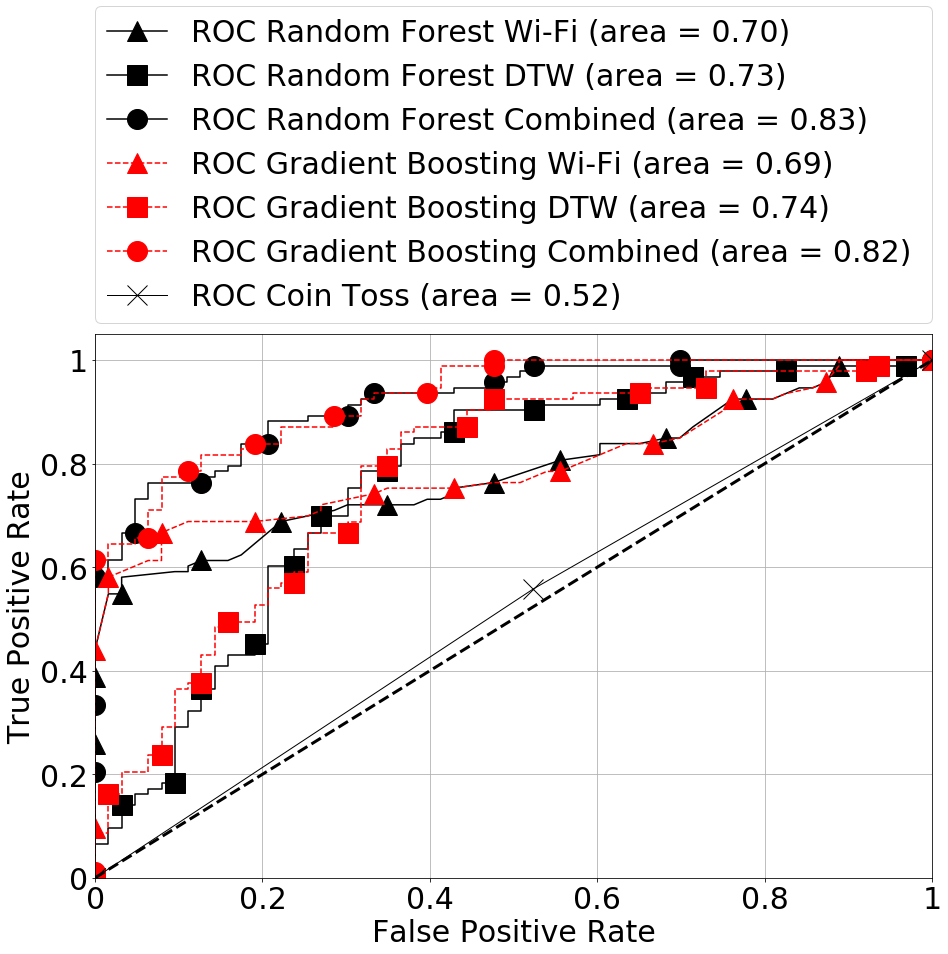

In [87]:
fig, ax = plt.subplots()
ax.plot(rates_wifi[0], 
        rates_wifi[1],
        marker = '^',
        markevery = 0.1,
        color = 'k',
        linewidth = 1.5,
        label='ROC Random Forest Wi-Fi (area = %0.2f)' % np.nanmean(rates_wifi[2])
        )
ax.plot(rates_magnetometer[0], 
        rates_magnetometer[1],
        marker = 's',
        markevery = 0.1,
        color = 'k',
        linewidth = 1.5,
        label='ROC Random Forest DTW (area = %0.2f)' % np.nanmean(rates_magnetometer[2])
        )
ax.plot(rates_combined[0], 
        rates_combined[1],
        marker = 'o',
        markevery = 0.1,
        color = 'k',
        linewidth = 1.5,
        label='ROC Random Forest Combined (area = %0.2f)' % np.nanmean(rates_combined[2])
        )
ax.plot(rates_wifi_gradient[0], 
        rates_wifi_gradient[1],
        marker = '^',
        markevery = 0.1,
        linestyle = '--',
        color = 'r',
        linewidth = 1.5,
        label='ROC Gradient Boosting Wi-Fi (area = %0.2f)' % np.nanmean(rates_wifi_gradient[2])
        )
ax.plot(rates_magnetometer_gradient[0], 
        rates_magnetometer_gradient[1],
        marker = 's',
        markevery = 0.1,
        linestyle = '--',
        color = 'r',
        linewidth = 1.5,
        label='ROC Gradient Boosting DTW (area = %0.2f)' % np.nanmean(rates_magnetometer_gradient[2])
        )
ax.plot(rates_combined_gradient[0], 
        rates_combined_gradient[1],
        marker = 'o',
        markevery = 0.1,
        linestyle = '--',
        color = 'r',
        linewidth = 1.5,
        label='ROC Gradient Boosting Combined (area = %0.2f)' % np.nanmean(rates_combined_gradient[2])
        )
ax.plot(rates_random[0], 
        rates_random[1],
        marker = 'x',
        markevery = 0.1,
        color = 'k',
        linewidth = 1,
        label='ROC Coin Toss (area = %0.2f)' % np.nanmean(rates_random[2])
        )
ax.plot([0,1],
        [0,1],
        linestyle = '--',
        color = 'k',
        )

        
ax.set_ylim(0,1.05)
ax.set_xlim(0,1)

ax.xaxis.grid()
ax.yaxis.grid()

ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])

#ax.set_title('BLE encounters predicted using Wi-Fi, DTW features, or both.')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',ncol=1, mode="expand", borderaxespad=0.)
#ax.legend(handlelength=3)

fig.savefig(
    os.path.join(result_path,'bigdata','comparison-all-notitle.pdf'),
    format="pdf", 
    bbox_inches="tight")
plt.show()

### Compare all feature combinations

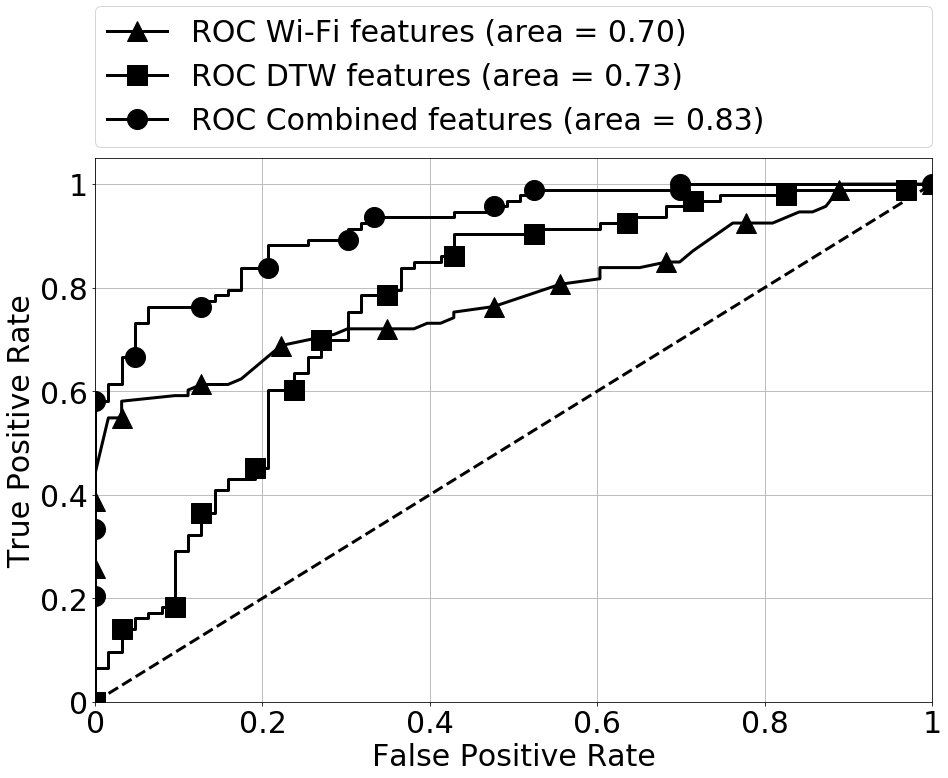

In [82]:
fig, ax = plt.subplots()
ax.plot(rates_wifi[0], 
        rates_wifi[1],
        marker = '^',
        markevery = 0.1,
        color = 'k',
#        linewidth = 1.5,
        label='ROC Wi-Fi features (area = %0.2f)' % np.nanmean(rates_wifi[2])
        )
ax.plot(rates_magnetometer[0], 
        rates_magnetometer[1],
        marker = 's',
        markevery = 0.1,
        color = 'k',
#        linewidth = 1.5,
        label='ROC DTW features (area = %0.2f)' % np.nanmean(rates_magnetometer[2])
        )
ax.plot(rates_combined[0], 
        rates_combined[1],
        marker = 'o',
        markevery = 0.1,
        color = 'k',
#        linewidth = 1.5,
        label='ROC Combined features (area = %0.2f)' % np.nanmean(rates_combined[2])
        )
ax.plot([0,1],
        [0,1],
        linestyle = '--',
        color = 'k',
        )

        
ax.set_ylim(0,1.05)
ax.set_xlim(0,1)

ax.xaxis.grid()
ax.yaxis.grid()

ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])

#ax.set_title('BLE encounters predicted by random forest including Wi-Fi features, DTW features, or both. ')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',ncol=1, mode="expand", borderaxespad=0.)

fig.savefig(
    os.path.join(result_path,'bigdata','comparison-features-notitle.pdf'),
    format="pdf", 
    bbox_inches="tight")
plt.show()

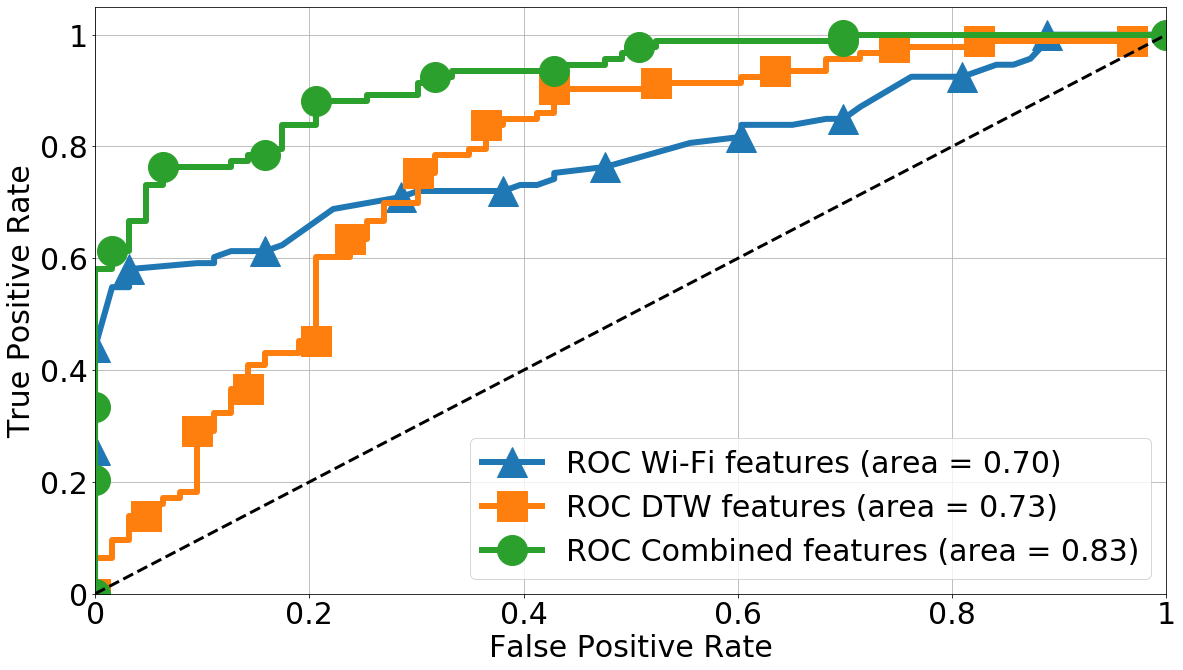

In [117]:
fig, ax = plt.subplots(figsize=(19.2,10.8))

ax.plot(rates_wifi[0], 
        rates_wifi[1],
        marker = '^',
        markersize = 30,
        markevery = 0.1,
#        color = 'k',
        linewidth = 6,
        label='ROC Wi-Fi features (area = %0.2f)' % np.nanmean(rates_wifi[2])
        )
ax.plot(rates_magnetometer[0], 
        rates_magnetometer[1],
        marker = 's',
        markersize = 30,
        markevery = 0.1,
#        color = 'k',
        linewidth = 6,
        label='ROC DTW features (area = %0.2f)' % np.nanmean(rates_magnetometer[2])
        )
ax.plot(rates_combined[0], 
        rates_combined[1],
        marker = 'o',
        markersize = 30,
        markevery = 0.1,
#        color = 'k',
        linewidth = 6,
        label='ROC Combined features (area = %0.2f)' % np.nanmean(rates_combined[2])
        )
ax.plot([0,1],
        [0,1],
        linestyle = '--',
        color = 'k',
        )

        
ax.set_ylim(0,1.05)
ax.set_xlim(0,1)

ax.xaxis.grid()
ax.yaxis.grid()

ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])

#ax.set_title('BLE encounters predicted by random forest including Wi-Fi features, DTW features, or both. ')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')

fig.savefig(
    os.path.join(result_path,'bigdata','comparison-features-notitle-presentation.pdf'),
    format="pdf", 
    bbox_inches="tight")
plt.show()

### Compare all models

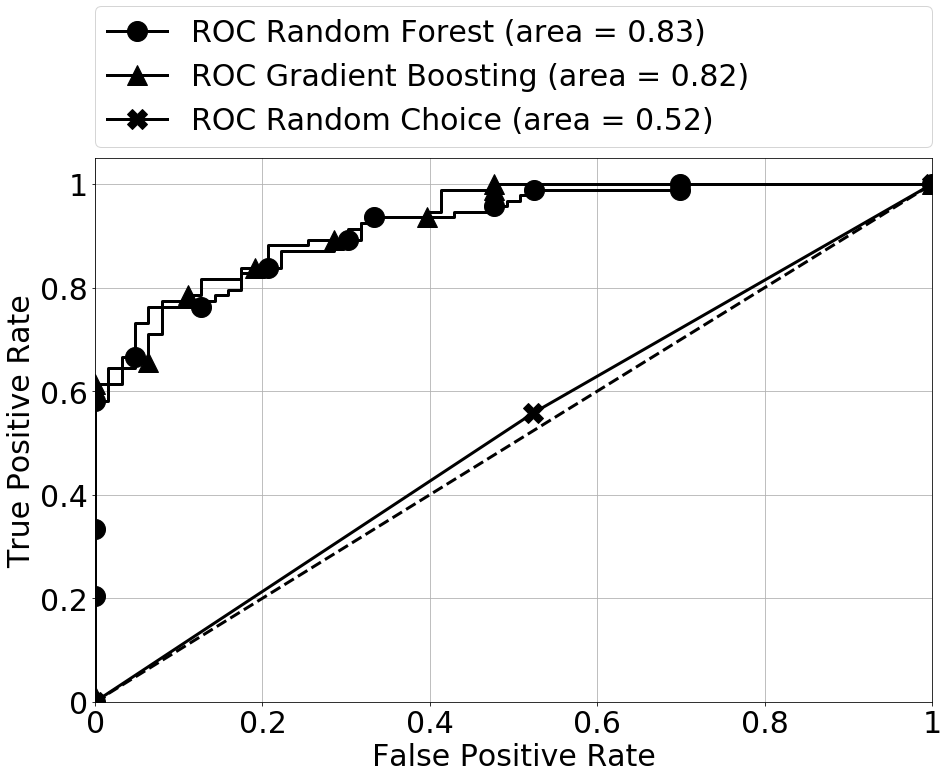

In [90]:
fig, ax = plt.subplots()
ax.plot(rates_combined[0], 
        rates_combined[1],
        marker = 'o',
        markevery = 0.1,
        color = 'k',
#        linewidth = 1.5,
        label='ROC Random Forest (area = %0.2f)' % np.nanmean(rates_combined[2])
        )
ax.plot(rates_combined_gradient[0], 
        rates_combined_gradient[1],
        marker = '^',
        markevery = 0.1,
        color = 'k',
#        linewidth = 1.5,
        label='ROC Gradient Boosting (area = %0.2f)' % np.nanmean(rates_combined_gradient[2])
        )
ax.plot(rates_random[0], 
        rates_random[1],
        marker = 'X',
        markevery = 0.1,
        color = 'k',
#        linewidth = 1.5,
        label='ROC Random Choice (area = %0.2f)' % np.nanmean(rates_random[2])
        )
ax.plot([0,1],
        [0,1],
        linestyle = '--',
        color = 'k',
        )

        
ax.set_ylim(0,1.05)
ax.set_xlim(0,1)

ax.xaxis.grid()
ax.yaxis.grid()

ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])

#ax.set_title('BLE encounters predicted by random forest, gradient boosting, or coin toss including the combined features.')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',ncol=1, mode="expand", borderaxespad=0.)

fig.savefig(
    os.path.join(result_path,'bigdata','comparison-models-notitle.pdf'),
    format="pdf", 
    bbox_inches="tight")
plt.show()

## 8.2 Boxplot feature importance

Random forest has a marginally higher AUC, so optimize that 30 times and draw boxplot of features.

Labels: (517,)
Features Wifi: (517, 13)
Features Magnetometer: (517, 12)
Features All: (517, 25)

--- Data ---
Training Features Shape: (361, 25)
Training Labels Shape: (361,)
Testing Features Shape: (156, 25)
Testing Labels Shape: (156,)

--- Fitting ---
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 545 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 1245 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1938 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2881 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4028 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 5237 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 6937 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 8837 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 9993 out of 10000 | elapsed: 11.4min remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 11.4min finished
/u/home/starkc/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` par


--- Best Parameters ---
n_estimators: 110
min_samples_split: 10
max_leaf_nodes: None
max_features: log2
max_depth: None
bootstrap: False

--- Architecture ---
Average number of nodes 89
Average maximum depth 14

--- Features ---
Variable: jaccard_WIFI         Importance: 0.097
Variable: centered_min_magnetometer Importance: 0.0728
Variable: topAP6dB_WIFI        Importance: 0.0589
Variable: union_WIFI           Importance: 0.0587
Variable: nonoverlap_WIFI      Importance: 0.0558
Variable: raw_median_magnetometer Importance: 0.0553
Variable: centered_median_magnetometer Importance: 0.051
Variable: raw_total_magnetometer Importance: 0.0509
Variable: normalized_max_magnetometer Importance: 0.0499
Variable: centered_max_magnetometer Importance: 0.047
Variable: raw_max_magnetometer Importance: 0.045
Variable: normalized_median_magnetometer Importance: 0.0446
Variable: normalized_total_magnetometer Importance: 0.0438
Variable: centered_total_magnetometer Importance: 0.0417
Variable: adamic_a

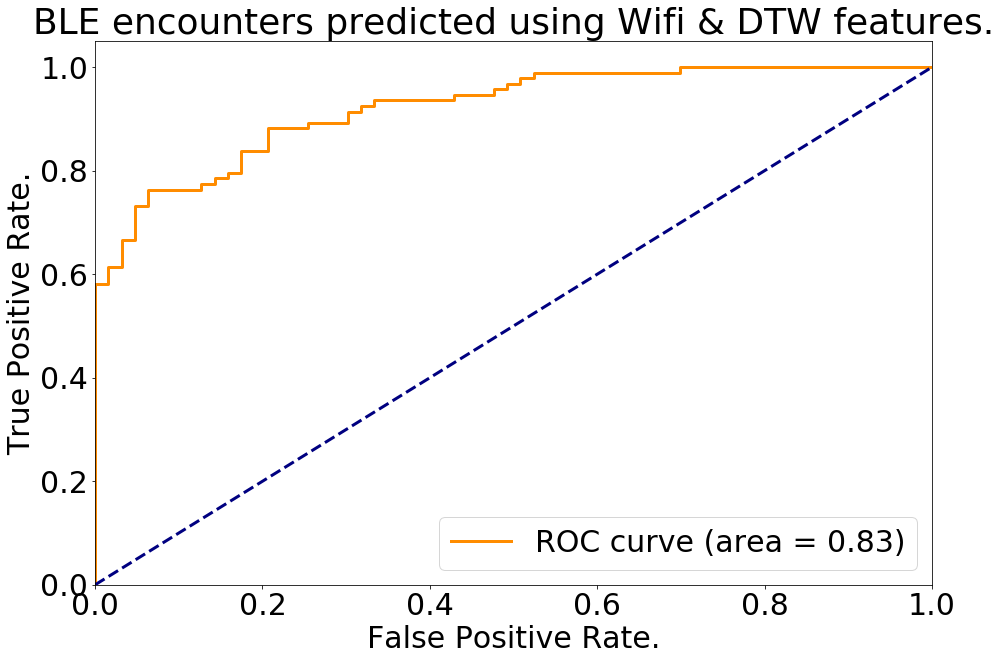


--- Data ---
Training Features Shape: (361, 25)
Training Labels Shape: (361,)
Testing Features Shape: (156, 25)
Testing Labels Shape: (156,)

--- Fitting ---
Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 645 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1345 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1987 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2979 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3894 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  5.5min


In [ ]:
labels = entries_filled.encounter_BLE.values
features_wifi = filter_experiment_mean(experiment_originalfeatures, entries_filled)
features_magnetometer = filter_experiment_max(experiment_dtw_magnetometer, entries_filled)
features_combined = np.concatenate((features_wifi,features_magnetometer), axis=1)

wifi_columns = [f for f in experiment_originalfeatures.columns if 'encounter' not in f]
magnetometer_columns = [f for f in experiment_dtw_magnetometer.columns if 'encounter' not in f]
combined_columns = np.concatenate([wifi_columns, magnetometer_columns])

print('Labels:', labels.shape)
print('Features Wifi:', features_wifi.shape)
print('Features Magnetometer:', features_magnetometer.shape)
print('Features All:', features_combined.shape)

feature_importances_list = []
for i in range(30):
    log('[Boxplot]\tRound ' + str(i+1) + ' of 30.')
    _, rates_combined_box, feature_importances_box = opt_forest(
        X = features_combined,
        y = labels,
        iterations = 1000,
        feature_list = combined_columns,
        plot_title = 'BLE encounters predicted using Wifi & DTW features.',
        plot_name = os.path.join(result_path, 'bigdata', 'filledoptimized_forest_combined_30.pdf'),
        cv = 10,
        seed = int((i*69+420420)/45.2)
    )
    feature_importances_list.append(feature_importances_box)
    
log('Done optimizing')

In [482]:
feature_importances_list

In [603]:
feature_importances_list_flat = [[x[1] for x in run] for run in feature_importances_list]
#feature_list = [x[0] for x in feature_importances_list[0]]

#for f in feature_list:
#    print(f)
# print(feature_importances_list_flat[0])

In [612]:
feature_list_pretty = [
    'Jaccard Wi-Fi',
    'Centered min magnetometer',
    u'Top AP\u00B16dB Wi-Fi',
    'Union Wi-Fi',
    'Non-Overlap Wi-Fi',
    'Raw median magnetometer',
    'Centered median magnetometer',
    'Raw total magnetometer',
    'Normalized max magnetometer',
    'Centered max magnetometer',
    'Raw max magnetometer',
    'Normalized median magnetometer',
    'Normalized total magnetometer',
    'Centered total magnetometer',
    'Adamic-Adar Wi-Fi',
    'Normalized min magnetometer',
    'Raw min magnetometer',
    'Min popularity Wi-Fi',
    'Overlap Wi-Fi',
    'Manhattan Wi-Fi',
    'Euclidean Wi-Fi',
    'Spearman Wi-Fi',
    'Max popularity Wi-Fi',
    'Pearson Wi-Fi',
    'Top AP Wi-Fi'
]

In [613]:
for f in range(len(feature_list_pretty)):
    print(feature_list[f],'->',feature_list_pretty[f])

jaccard_WIFI -> Jaccard Wi-Fi
raw_max_magnetometer -> Centered min magnetometer
centered_min_magnetometer -> Top AP±6dB Wi-Fi
raw_total_magnetometer -> Union Wi-Fi
centered_median_magnetometer -> Non-Overlap Wi-Fi
raw_median_magnetometer -> Raw median magnetometer
centered_total_magnetometer -> Centered median magnetometer
normalized_total_magnetometer -> Raw total magnetometer
normalized_max_magnetometer -> Normalized max magnetometer
nonoverlap_WIFI -> Centered max magnetometer
centered_max_magnetometer -> Raw max magnetometer
union_WIFI -> Normalized median magnetometer
normalized_median_magnetometer -> Normalized total magnetometer
topAP6dB_WIFI -> Centered total magnetometer
raw_min_magnetometer -> Adamic-Adar Wi-Fi
adamic_adar_WIFI -> Normalized min magnetometer
normalized_min_magnetometer -> Raw min magnetometer
overlap_WIFI -> Min popularity Wi-Fi
min_popularity_WIFI -> Overlap Wi-Fi
euclidean_WIFI -> Manhattan Wi-Fi
pearson_WIFI -> Euclidean Wi-Fi
manhattan_WIFI -> Spearman Wi

In [599]:
# add some variance for test
#for i in range(len(feature_importances_list_flat)):
#    for f in range(len(feature_importances_list_flat[i])):
#        feature_importances_list_flat[i][f] += i%3+f%5

In [614]:
feature_importance_df = pd.DataFrame(data=feature_importances_list_flat, columns=feature_list_pretty)
feature_importance_df = feature_importance_df.T[::-1].T
feature_importance_df

Top AP Wi-Fi  Pearson Wi-Fi  Max popularity Wi-Fi  Spearman Wi-Fi  \
0          0.000          0.004                 0.005           0.009   
1          0.001          0.007                 0.009           0.011   
2          0.000          0.004                 0.004           0.009   
3          0.000          0.002                 0.005           0.006   
4          0.000          0.004                 0.006           0.009   
5          0.000          0.001                 0.005           0.009   
6          0.000          0.000                 0.000           0.005   
7          0.000          0.004                 0.005           0.005   
8          0.000          0.000                 0.004           0.007   
9          0.000          0.003                 0.007           0.008   
10         0.000          0.004                 0.006           0.010   
11         0.000          0.002                 0.004           0.006   
12         0.000          0.001                 0.004           0.004   
13         0.001          0.001                 0.003           0.005   
14         0.000          0.000                 0.000           0.000   
15         0.000          0.005                 0.006           0.008   
16         0.001          0.001                 0.005           0.006   
17         0.000          0.004                 0.006           0.007   
18         0.000          0.000                 0.000           0.000   
19         0.000          0.002                 0.005           0.005   
20         0.000          0.005                 0.007           0.009   
21         0.000          0.001                 0.004           0.007   
22         0.000          0.000                 0.001           0.005   
23         0.000          0.005                 0.006           0.008   
24         0.000          0.000                 0.000           0.000   
25         0.001          0.007                 0.010           0.010   
26         0.000          0.004                 0.006           0.007   
27         0.000          0.003                 0.004           0.004   
28         0.001          0.006                 0.007           0.009   
29         0.001          0.007                 0.009           0.009   

    Euclidean Wi-Fi  Manhattan Wi-Fi  Overlap Wi-Fi  Min popularity Wi-Fi  \
0             0.009            0.014          0.025                 0.034   
1             0.014            0.019          0.027                 0.032   
2             0.011            0.015          0.034                 0.038   
3             0.013            0.016          0.028                 0.030   
4             0.014            0.016          0.023                 0.035   
5             0.011            0.014          0.015                 0.019   
6             0.008            0.015          0.015                 0.020   
7             0.015            0.016          0.022                 0.027   
8             0.009            0.012          0.016                 0.035   
9             0.009            0.013          0.030                 0.035   
10            0.016            0.016          0.026                 0.039   
11            0.012            0.015          0.018                 0.025   
12            0.009            0.017          0.025                 0.032   
13            0.006            0.013          0.023                 0.026   
14            0.000            0.000          0.017                 0.026   
15            0.012            0.017          0.021                 0.031   
16            0.006            0.013          0.016                 0.018   
17            0.010            0.013          0.024                 0.038   
18            0.000            0.000          0.007                 0.024   
19            0.007            0.007          0.014                 0.016   
20            0.013            0.015          0.024                 0.038   
21            0.014            0.016          

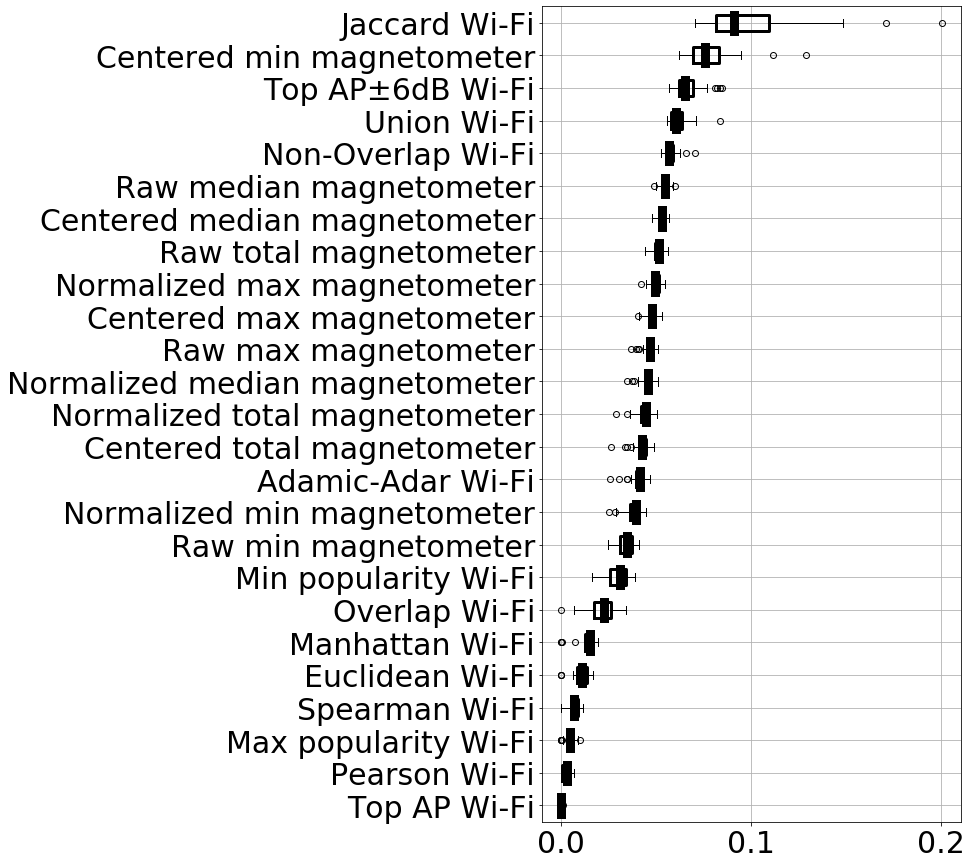

In [615]:
boxprops = dict(linewidth=3, color='black')
flierprops = dict(marker='o', markerfacecolor='black', markersize=12)
medianprops = dict(linewidth=9,color='black')

feature_importance_df.plot(
    kind = 'box',
    color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
    vert=False,
    figsize=[7.5,15],
    grid=True,
    boxprops=boxprops,
    medianprops=medianprops,
    labels = ldjhfg
)

plt.savefig(
    os.path.join(result_path,'bigdata','randomforest-featureimportance-boxplot.pdf'),
    format="pdf", 
    bbox_inches="tight")

In [626]:
data_magnetometer.describe()

_id  double_values_0  double_values_1  double_values_2  \
count 324101751.000    324101751.000    324101751.000    324101751.000   
mean   81125503.179           -3.272           -4.148          -24.715   
std    44466033.893           91.676           88.371          109.317   
min           1.000        -4716.347        -5049.481        -4897.455   
25%    50260465.500          -17.250          -18.875          -41.078   
50%    79937100.000            0.250           -0.900          -25.438   
75%   117500403.500           17.375           18.120           10.950   
max   167131588.000         4904.250         4890.431         5112.834   

           accuracy  label  
count 324101751.000  0.000  
mean          1.959    nan  
std           1.290    nan  
min           0.000    nan  
25%           0.000    nan  
50%           3.000    nan  
75%           3.000    nan  
max           3.000    nan

## 8.3 Device Mobility

In [3]:
from __future__ import division
import os
import re
import math
import glob
import dill
import time
import random
import sqlite3
import powerlaw
import calendar
import datetime
import itertools
import matplotlib
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from scipy import stats
from decimal import Decimal
from matplotlib import dates
from dtaidistance import dtw
from functools import reduce
from matplotlib import ticker
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from multiprocessing import Process
from geopy.distance import geodesic
from datetimerange import DateTimeRange
from scipy.spatial.distance import cdist
from pyclustering.cluster.xmeans import xmeans    
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

result_path = os.path.join(os.getcwd(), "guided-research-results")
experiment_path = os.path.join(result_path, 'experiment_data')
path_data_collection = os.path.join(os.getcwd(), "data-collection")

class DateTimeRangeHashable(DateTimeRange):
    def __hash__(self):
        return hash(repr(self))

class DillSerializer:
    
    def __init__(self, path):
        self.path = path
    
    def serialize(self, obj):
        f = open(self.path, "wb+")
        dill.dump(obj, f)
        f.close()
        
    def deserialize(self):
        f = open(self.path, "rb")
        data = dill.load(f)
        f.close()
        return data

def nested_dict(n, data_type):
    if n == 1:
        return collections.defaultdict(data_type)
    else:
        return collections.defaultdict(lambda: nested_dict(n-1, data_type))

def series_to_df(series):
    df = pd.DataFrame(series)
    df.reset_index(inplace=True)
    return df

def scale_marker(total_markers, data_range):
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=data_range) # default marker size: 36
    total_markers = total_markers.astype(float).reshape(-1, 1)
    return min_max_scaler.fit(total_markers)

def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:.1f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

def filter_label(label):
    translate = {"gsm": "GSM towers connected", "gsm neighbor": "GSM tower neighbors", "wifi": "Wi-Fi neighbors",
                 "sensor wifi": "Wi-Fi APs connected", "locations": "GPS / network location",
                 "sensor bluetooth": "Bluetooth", "bluetooth": "Bluetooth neighbors", "light": "Ambient light",
                 "significant": "Motion", "aware device": "Devices"}
    label = label.replace("_", " ")
    if label in translate:
        return translate[label]
    elif "sensor" in label:
        return label.title()
    else:
        return label.capitalize()

def get_plot_path(filename):
    return os.path.join(result_path, filename + "." + plot_format)

def apply_distance_rowwise(df, distance_func):
    results = []
    for (_, row1),(_, row2) in zip(df[:-1].iterrows(), df[1:].iterrows()):
        results.append(distance_func(row1.values, row2.values).m)
    return results

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.0f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.0f%s%s" % (num, 'Yi', suffix)

# convert byte columns to string columns
def b2s(df):
    str_df = df.select_dtypes([np.object])
    str_df = str_df.stack().str.decode("utf-8").unstack()
    for col in str_df:
        df[col] = str_df[col]
    return df

def adapt_strings(column, strings):
    if isinstance(strings, list):
        strings = {string: "" for string in strings}
    for key, value in strings.items():
        column = column.str.upper().str.replace(key.upper(), value.upper()).str.strip()
    return column

def clean_sensor_names(sensor_names):
    return adapt_strings(sensor_names, ["accelerometer", "sensor", "acceleration", "3-axis",
                                        "-", "/Temperature/Doubletap", "barometer", "pressure",
                                        "magnetometer", "magnetic field", "magnetic"])

font = {"size": 22}
matplotlib.rc("font", **font)
matplotlib.rcParams["pdf.fonttype"] = 42 # TrueType
matplotlib.rcParams["ps.fonttype"] = 42 # TrueType
matplotlib.rcParams["lines.linewidth"] = 3
matplotlib.rcParams["lines.markersize"] = 9
#default_color = "#1f77b4"
default_color = "black"

plot_format = "pdf"
device_identifier = "aware_device"
sensor_hardware = ["sensor_accelerometer", "sensor_barometer", "sensor_bluetooth",
                   "sensor_gravity", "sensor_gyroscope", "sensor_light", "sensor_linear_accelerometer",
                   "sensor_magnetometer", "sensor_proximity", "sensor_rotation", "sensor_temperature", "sensor_wifi"]
sensor_data = [ "accelerometer", "barometer", "gravity", "gyroscope", "light",
               "linear_accelerometer", "locations", "magnetometer", "rotation"] # CDMA not relevant for Europe with GSM, only in America
ground_truth = ["bluetooth", "wifi", "sensor_wifi", "telephony", "gsm", "gsm_neighbor"]

phone_context = [ "proximity", "screen", "significant"] # estimate phone in the pocket or user's activity
exclude_sensor = ["sensor_wifi", "sensor_bluetooth"] # no hardware details only bluetooth name, only MAC address, SSID, BSSID

relevant_data_all = [[device_identifier], sensor_hardware, ground_truth, phone_context, sensor_data]
relevant_data_mobility = [[device_identifier], ["locations", "gsm", "gsm_neighbor", "bluetooth", "wifi", "sensor_wifi"]]
relevant_data_ground_truth = [[device_identifier], ground_truth]

relevant_data_dataset = relevant_data_all
relevant_data_dataset = list(itertools.chain.from_iterable(relevant_data_dataset)) # flatten
relevant_data_pos = {"ble-beacons-location": "bluetooth", "eduroam": "wifi", "cell-tower": "gsm"}

print(relevant_data_dataset)
print(relevant_data_pos)

['aware_device', 'sensor_accelerometer', 'sensor_barometer', 'sensor_bluetooth', 'sensor_gravity', 'sensor_gyroscope', 'sensor_light', 'sensor_linear_accelerometer', 'sensor_magnetometer', 'sensor_proximity', 'sensor_rotation', 'sensor_temperature', 'sensor_wifi', 'bluetooth', 'wifi', 'sensor_wifi', 'telephony', 'gsm', 'gsm_neighbor', 'proximity', 'screen', 'significant', 'accelerometer', 'barometer', 'gravity', 'gyroscope', 'light', 'linear_accelerometer', 'locations', 'magnetometer', 'rotation']
{'ble-beacons-location': 'bluetooth', 'eduroam': 'wifi', 'cell-tower': 'gsm'}


In [13]:
def load_dataset(path_data_collection, data_limit=-1, sensor_num_entries_threshold=0.2):
    
    # key for file grouping
    def key_filename(name):
        name = os.path.basename(name).split(".")[0]
        return re.sub("_[0-9]", "", name)
    
    df = dict()
    df_paths = sorted(glob.glob(os.path.join(path_data_collection, "*.snappy")))
    df_paths = [list(group)[0] for _, group in itertools.groupby(df_paths, key_filename)]
    for fpath in df_paths:
        if len(df) == data_limit:
            break
        data_name = os.path.basename(fpath).split('.')[0]
        if data_name in relevant_data_dataset:
            if data_name not in ['bluetooth','aware_device']:
                continue
            print(fpath)
            data = pd.read_parquet(fpath)
            if "accelerometer" != data_name:
                data = b2s(data)
            data = data[pd.notnull(data.device_id)]
            include_data = True
            if "sensor" in data_name and data_name not in exclude_sensor:
                if "sensor_name" not in data.columns or len(data) < (sensor_num_entries_threshold * len(df["aware_device"])):
                    include_data = False
            if "bluetooth" in data_name:
                data = data[data.bt_address != "disabled"]
            elif "wifi" in data_name:
                data = data[data.bssid.notnull()]
                data = data[data.bssid != "00:00:00:00:00:00"]
                data = data[data.ssid != "<unknown ssid>"]
            elif "location" in data_name:
                data = data.rename(columns={'double_longitude':'lng', 'double_latitude':'lat'})
                data = data[~((data.lat==0.0) & (data.lng==0.0))]
                data = data[data.accuracy <= 2e3] # error in km
            if include_data:
                df[data_name] = data
    return df

def load_pos_data(path_data_collection, csv_separator={"bluetooth": ";", "wifi": ";", "gsm":  ","}):
    df = dict()
    df_paths = glob.glob(os.path.join(path_data_collection, "*.csv"))
    for fpath in df_paths:
        data_name = os.path.basename(fpath).split(".")[0]
        if data_name in relevant_data_pos:
            sep = csv_separator[relevant_data_pos[data_name]]
            data = pd.read_csv(fpath, sep=sep)
            if "beacon" in data_name:
                data = data[data.mac.notnull()]
            elif "eduroam" in data_name:
                data = data[data.mac.notnull()]
                data = data[data.lat.notnull()]
            elif "cell" in data_name: # cell-tower.csv.gz
                data = data[data.radio.str.upper() == "GSM"]
                data = data.groupby("cell", as_index=False).mean()        
            print(fpath)
            df[relevant_data_pos[data_name]] = data
    
    dbpath = os.path.join(path_data_collection, "cell-tower.sqlite")
    db = sqlite3.connect(dbpath)
    cell_towers = pd.read_sql_query("SELECT * from cell_zone", db)
    cell_towers.cid = cell_towers.cid.astype(int)
    cell_towers = cell_towers[cell_towers.technology == "GSM"]
    data_name = os.path.basename(dbpath).split(".")[0]
    print(dbpath)
    df[relevant_data_pos[data_name]] = cell_towers.groupby("cid", as_index=False).mean()
    db.close()
    return df

def remove_outlier_inplace(df, outlier_threshold=3):
    timestamps = [data.timestamp for data in df.values()]
    timestamps = pd.concat(timestamps)
    timestamps_num = dates.date2num(timestamps)
    outlier = timestamps[np.abs(stats.zscore(timestamps_num)) > outlier_threshold]
    if len(outlier) > 0:
        outlier = outlier.dt.floor("d")
        for data in df.values():
            outlier_rows = data.timestamp.dt.floor("d").isin(outlier)
            if len(outlier_rows) > 0:
                data.drop(outlier_rows.index[outlier_rows], inplace=True)

df_pos = load_pos_data(path_data_collection)
temp = load_dataset(path_data_collection)
df_data = {data_name: data for data_name, data in temp.items() if device_identifier not in data_name}
remove_outlier_inplace(df_data)
df_data[device_identifier] = temp[device_identifier]
temp.clear()
df_hardware = {name.split("_")[1]: data for name, data in df_data.items() if "sensor" in name and name not in exclude_sensor}
print("positions:", df_pos.keys())
print("data:", df_data.keys())
print("hardware:", df_hardware.keys())

/dev/proximity_starkc/proximity-dataset-analysis/implementation/src/data-collection/eduroam.csv
/dev/proximity_starkc/proximity-dataset-analysis/implementation/src/data-collection/ble-beacons-location.csv
/dev/proximity_starkc/proximity-dataset-analysis/implementation/src/data-collection/cell-tower.sqlite
/dev/proximity_starkc/proximity-dataset-analysis/implementation/src/data-collection/aware_device.parquet.snappy
/dev/proximity_starkc/proximity-dataset-analysis/implementation/src/data-collection/bluetooth.parquet.snappy
positions: dict_keys(['wifi', 'bluetooth', 'gsm'])
data: dict_keys(['bluetooth', 'aware_device'])
hardware: dict_keys([])


In [43]:
np_devices_mult = np.concatenate(
    [training_ble.device_id.unique(),
     training_wifi.device_id.unique(),
     training_accelerometer.device_id.unique(),
     training_barometer.device_id.unique(),
     training_magnetometer.device_id.unique()
    ])
training_devices = np.unique(np_devices_mult)

In [44]:
df_data['bluetooth-filtered'] = df_data['bluetooth'][df_data['bluetooth'].device_id.isin(training_devices)].copy()

In [45]:
position_columns = {"bluetooth": ["lat", "long"]}
position_join = [("bluetooth", "bt_address", "bluetooth", "mac"),
                 ('bluetooth-filtered', 'bt_address', 'bluetooth', 'mac')
                ]
neighbor_scans = ["bluetooth",'bluetooth-filtered']

In [46]:
user_distances = dict()
user_entropies = collections.defaultdict(dict)

# https://stackoverflow.com/questions/57325537/compute-entropy-of-a-set-of-points
# https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
def entropy(x):
    counts = np.histogramdd(x)[0]
    dist = counts / np.sum(counts)
    logs = np.log2(np.where(dist > 0, dist, 1))
    return -np.sum(dist * logs)

#from sklearn.neighbors.kde import KernelDensity
#kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(pos)
#log_p = kde.score_samples(pos)   # returns log(p) of data sample
#p = np.exp(log_p)                # estimate p of data sample
#entropy = -np.sum(p*log_p)       # evaluate entropy
#print(entropy)

def compute_distances(device_id, records, temp_distances, temp_entropy, pos_data, max_daily_walk_distance=300000):
    records = records.sort_values(by=["timestamp"])
    records = records.dropna(subset=position_columns[pos_data])
    pos_data = records[position_columns[pos_data]]
    walk_distances = apply_distance_rowwise(pos_data, geodesic)
    walk_distance = sum(walk_distances)
    #temp_entropy[device_id].append(entropy(pos_data.values))
    if walk_distance < max_daily_walk_distance: # filter outlier and noise
        temp_distances.append(walk_distance)
        temp_entropy[device_id].append(entropy(pos_data.values))

In [47]:
for src_data, src_join, pos_data, pos_join in position_join:
    print("data: {}".format(src_data))
    sensor_data = df_data[src_data][["timestamp", "device_id", src_join]].copy()
    positions = df_pos[pos_data].copy()
    if sensor_data[src_join].dtype == np.object: # string
        if src_data == "sensor_wifi":
            sensor_data[src_join] = sensor_data[src_join].str[:-1].str.upper()
            positions[pos_join] = positions[pos_join].str[:-1].str.upper()
        else:
            sensor_data[src_join] = sensor_data[src_join].str.upper()
            positions[pos_join] = positions[pos_join].str.upper()
    sensor_data = sensor_data.merge(positions, left_on=src_join, right_on=pos_join)
    sensor_data["day"] = sensor_data.timestamp.dt.floor("d")
    temp_distances = []
    temp_entropy = collections.defaultdict(list)
    for (device_id, day), records in sensor_data.groupby(["device_id", "day"]):
        if records[src_join].nunique() > 1:
            if any([src_data == scan for scan in neighbor_scans]): # take mean of grouped scans by median sampling time
                records = records.sort_values(by=["timestamp"])
                median_sampling_time = int(records.timestamp.diff().median().total_seconds())
                if median_sampling_time > 10: # seconds
                    records = records.resample("{}S".format(median_sampling_time), on="timestamp").mean()
                    compute_distances(device_id, records, temp_distances, temp_entropy, pos_data)
            else:
                compute_distances(device_id, records, temp_distances, temp_entropy, pos_data)
    
    user_distances[src_data] = temp_distances
    for device, entropies in temp_entropy.items():
        user_entropies[src_data][device] = np.mean(entropies)

data: bluetooth
data: bluetooth-filtered


dict_keys(['bluetooth', 'bluetooth-filtered'])


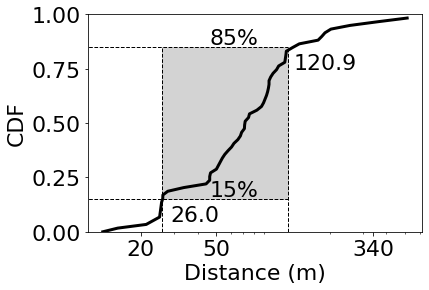

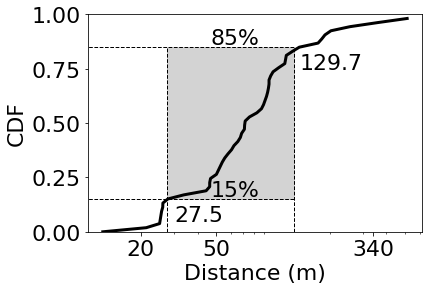

In [50]:
linewidth = 1
linestyle = "--"
text_shift = 0.015
linecolor = "black"
upper_threshold = 0.85
lower_threshold = 0.15
yshift = 0.1
background_color = "lightgrey"
km = ["gps", "network", "gsm"]
xlim = {"gsm": 1050, "gsm_neighbor": 620, "network": 750, "sensor_wifi": 2600, "network-gps": 850}
xticks = {"bluetooth": [20, 50, 340],
          "bluetooth-filtered": [20, 50, 340]
         }

print(user_distances.keys())

for sensor, distances in user_distances.items():
    distance_unit = "m"
    if any(data in sensor for data in km):
        distance_unit = "km"
        distances = [dist/1000.0 for dist in distances]
    
    fig, ax = plt.subplots()
    upper_quantile = pd.Series(distances).quantile(upper_threshold)
    lower_quantile = pd.Series(distances).quantile(lower_threshold)
    powerlaw.plot_cdf(distances, ax=ax, color=default_color)
    
    ax.vlines(lower_quantile, ymin=0, ymax=upper_threshold, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
    ax.vlines(upper_quantile, ymin=0, ymax=upper_threshold, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
    ax.hlines(upper_threshold, xmin=0, xmax=upper_quantile, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
    ax.hlines(lower_threshold, xmin=0, xmax=upper_quantile, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
    
    ax.axvspan(xmin=lower_quantile, xmax=upper_quantile, ymin=lower_threshold, ymax=upper_threshold, color=background_color)
    
    mid = pd.Series(distances).quantile(0.25)
    ax.annotate(s="{:.0%}".format(lower_threshold), xy=(mid, lower_threshold+text_shift))
    ax.annotate(s="{:.0%}".format(upper_threshold), xy=(mid, upper_threshold+text_shift))
    
    ax.annotate(s='{:.1f}'.format(upper_quantile), xy=(upper_quantile+lower_quantile*0.32, upper_threshold-yshift))
    ax.annotate(s='{:.1f}'.format(lower_quantile), xy=(lower_quantile+lower_quantile*0.1, lower_threshold-yshift))
    
    ax.set_yscale("linear")
    ax.set_ylim(0, 1)
    ax.set_ylabel("CDF")
    ax.set_xlabel("Distance ({})".format(distance_unit))
    
    if sensor in xticks:
        ax.set_xticks(xticks[sensor])
    if sensor in xlim:
        ax.set_xlim(right=xlim[sensor])
    
    formatter = ticker.ScalarFormatter()
    formatter.set_scientific(False)
    ax.xaxis.set_major_formatter(formatter)
    
    fig.savefig(get_plot_path(os.path.join('bigdata',"user-walking-distance-per-day-" + sensor.replace("_", "-"))),
                format=plot_format, bbox_inches="tight")

In [52]:
user_distances['bluetooth-filtered']

[25.778639459382507,
 26.14001733146177,
 91.06591818047099,
 62.33592227142537,
 89.44295203472396,
 65.35003681422586,
 44.364710568602064,
 27.802392687418887,
 21.36739761933259,
 181.9598788573345,
 360.7775818463556,
 515.8677268826204,
 60.512251203809626,
 55.72952984215204,
 82.42236810430127,
 138.36204644048186,
 25.15917536250197,
 50.31835072500394,
 50.31835072500394,
 71.49036583965938,
 26.18970761125176,
 68.45721407538788,
 25.15917536250197,
 12.5795843198503,
 33.78296450903985,
 25.15917536250197,
 87.20695126242443,
 50.31835072500394,
 46.841709151438195,
 100.45459657355384,
 54.09093657712154,
 127.50006486215659,
 75.34094718572842,
 70.99358644183657,
 115.90915006334578,
 97.56857993298118,
 107.57782368429665,
 256.8378921882025,
 203.52957236741113,
 95.62354675307905,
 118.09067373628392,
 57.954575031672896,
 46.36365988732955,
 94.92844468172017,
 70.80812556575395,
 173.97079169114795,
 93.98995550890808,
 189.26974808681027,
 46.36365988630827,
 92.72

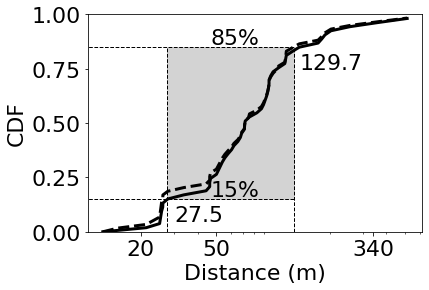

In [55]:
distance_unit = "m"

distances = user_distances['bluetooth-filtered']
reference = user_distances['bluetooth']
    
fig, ax = plt.subplots()
upper_quantile = pd.Series(distances).quantile(upper_threshold)
lower_quantile = pd.Series(distances).quantile(lower_threshold)
powerlaw.plot_cdf(distances, ax=ax, color=default_color)
powerlaw.plot_cdf(reference, ax=ax, color=default_color, linestyle='--')
    
ax.vlines(lower_quantile, ymin=0, ymax=upper_threshold, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
ax.vlines(upper_quantile, ymin=0, ymax=upper_threshold, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
ax.hlines(upper_threshold, xmin=0, xmax=upper_quantile, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
ax.hlines(lower_threshold, xmin=0, xmax=upper_quantile, linestyle=linestyle, linewidth=linewidth, color=linecolor, zorder=3)
    
ax.axvspan(xmin=lower_quantile, xmax=upper_quantile, ymin=lower_threshold, ymax=upper_threshold, color=background_color)
    
mid = pd.Series(distances).quantile(0.25)
ax.annotate(s="{:.0%}".format(lower_threshold), xy=(mid, lower_threshold+text_shift))
ax.annotate(s="{:.0%}".format(upper_threshold), xy=(mid, upper_threshold+text_shift))

ax.annotate(s='{:.1f}'.format(upper_quantile), xy=(upper_quantile+lower_quantile*0.32, upper_threshold-yshift))
ax.annotate(s='{:.1f}'.format(lower_quantile), xy=(lower_quantile+lower_quantile*0.1, lower_threshold-yshift))
    
ax.set_yscale("linear")
ax.set_ylim(0, 1)
ax.set_ylabel("CDF")
ax.set_xlabel("Distance ({})".format(distance_unit))
    
if sensor in xticks:
    ax.set_xticks(xticks[sensor])
if sensor in xlim:
    ax.set_xlim(right=xlim[sensor])
    
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
    
fig.savefig(get_plot_path(os.path.join('bigdata',"user-walking-distance-per-day-bluetooth-reference")),format=plot_format, bbox_inches="tight")